In [ ]:
# import attention
from attention import AttentionLayer

In [1]:
import pandas as pd
import numpy as np
import re
import time
from nltk.corpus import stopwords

In [2]:
import tensorflow as tf
from tensorflow.python.layers.core import Dense
from tensorflow.python.ops.rnn_cell_impl import _zero_state_tensors
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
from bs4 import BeautifulSoup 
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 2.1.0


In [3]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\lkw06\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
news_summary = pd.read_csv("news_summary_more.csv",encoding='ISO-8859-1')
news_summary.shape

(98401, 2)

# Data Preprocessing

In [5]:
print('Story: ' + str(news_summary['Full Stories'][1]))
print('Summaries: ' + str(news_summary['Summary'][1]))
news_summary.head()

Story: Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
Summaries: Delhi techie wins free food from Swiggy for one year on CRED


Summary  \
0    upGrad learner switches to career in ML & Al with 90% salary hike   
1         Delhi techie wins free food from Swiggy for one year on CRED   
2     New Zealand end Rohit Sharma-led India's 12-match winning streak   
3             Aegon life iTerm insurance plan helps customers save tax   
4  Have known Hirani for yrs, what if MeToo claims are not true: Sonam   

                                                                                                                                                                                              Full Stories  
0  Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...  
1  Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...  
2  New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...  
3  With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...  
4  Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement will get derailed." "I...

In [6]:
news_summary.dropna(axis=0,inplace=True)
news_summary.shape

(98401, 2)

In [7]:
news_summary.drop_duplicates(subset=['Full Stories'],inplace=True)  #dropping duplicates
news_summary.shape

(98360, 2)

In [8]:
CURRENCIES = {
    "$": "USD", "zł": "PLN", "£": "GBP", "¥": "JPY", "฿": "THB", "₡": "CRC", "₦": "NGN","₩": "KRW",
    "₪": "ILS", "₫": "VND", "€": "EUR", "₱": "PHP", "₲": "PYG", "₴": "UAH", "₹": "INR"}

CURRENCY_REGEX = re.compile(
    "({})+".format("|".join(re.escape(c) for c in CURRENCIES.keys())))

EMAIL_REGEX = re.compile(
    r"(?:^|(?<=[^\w@.)]))([\w+-](\.(?!\.))?)*?[\w+-]@(?:\w-?)*?\w+(\.([a-z]{2,})){1,3}(?:$|(?=\b))",
    flags=re.IGNORECASE | re.UNICODE,)

In [9]:
#English Contraction
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [10]:
def clean_text(text, remove_stopwords = True):
#     text = text.replace('(CNN) -- ', '')
    text = text.lower()
#     text = BeautifulSoup(text, "lxml").text
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    #Remove website url
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    #Remove Email
    text = EMAIL_REGEX.sub('',text)
    #Remove currency symbol
    text = CURRENCY_REGEX.sub('',text)
    #Convert short forms to full text
    text = ' '.join([contractions[t] if t in contractions else t for t in text.split(" ")])    
    #Remove Special Characters
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    #Remove number from string
    text = re.sub(r'[0-9]', "", text) 
    #Remove 's and backspace
    text = re.sub(r"'s\b","", text)
    #Remove ampersand
    text = re.sub(r'&amp;', '', text)
    #Remove newline
    text = re.sub('\n', ' ', text)
    # Remove multiple spaces
    text = re.sub("(\s+)", " ", str(text)).lower()
    # Remove the single character hanging between any two spaces
    text = re.sub("(\s+.\s+)", " ", str(text)).lower()
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    return text

In [11]:
cleaned_full_text = []
cleaned_summary = []
for fullText in news_summary['Full Stories']:
    cleaned_full_text.append(clean_text(fullText, remove_stopwords=False))
print("Full Text are complete.")

for summary in news_summary['Summary']:    
    cleaned_summary.append(clean_text(summary, remove_stopwords=False))
print("Summary are complete.")

Full Text are complete.
Summary are complete.


# Data Understanding

In [ ]:
def count_words(count_dict, text):
    '''Count the number of occurrences of each word in a set of text'''
    for sentence in text:
        for word in sentence.split():
            if word not in count_dict:
                count_dict[word] = 1
            else:
                count_dict[word] += 1

In [ ]:
# Find the number of times each word was used and the size of the vocabulary
word_counts = {}

count_words(word_counts, cleaned_summary)
count_words(word_counts, cleaned_full_text)
            
print("Size of Vocabulary for both text and summary:", len(word_counts))

In [ ]:
embeddings_index = {}
with open(r'C:\Users\lkw06\Desktop\numberbatch-en.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = embedding
print('Word embeddings:', len(embeddings_index))

In [ ]:
# Find the number of words that are missing from the word embeddings, and are used more than our threshold.
missing_words = 0
threshold = 20

for word, count in word_counts.items():
    if count > threshold:
        if word not in embeddings_index:
            missing_words += 1
            
missing_ratio = round(missing_words/len(word_counts),4)*100
            
print("Number of words missing from Word Embeddings:", missing_words)
print("Percent of words that are missing from vocabulary: {}%".format(missing_ratio))

In [ ]:
# Limit the vocab that we will use to words that appear ≥ threshold or are in GloVe

#dictionary to convert words to integers
vocab_to_int = {} 

value = 0
for word, count in word_counts.items():
    if count >= threshold or word in embeddings_index:
        vocab_to_int[word] = value
        value += 1
# Special tokens that will be added to our vocab
codes = ["<UNK>","<PAD>","<EOS>","<GO>"]   

# Add codes to vocab
for code in codes:
    vocab_to_int[code] = len(vocab_to_int)

# Dictionary to convert integers to words
int_to_vocab = {}
for word, value in vocab_to_int.items():
    int_to_vocab[value] = word

usage_ratio = round(len(vocab_to_int) / len(word_counts),4)*100

print("Total number of unique words:", len(word_counts))
print("Number of words we will use:", len(vocab_to_int))
print("Percent of words we will use: {}%".format(usage_ratio))

In [ ]:
embedding_dim = 300
nb_words = len(vocab_to_int)
word_embedding_matrix = np.zeros((nb_words, embedding_dim), 
                                 dtype=np.float32)
for word, i in vocab_to_int.items():
    if word in embeddings_index:
        word_embedding_matrix[i] = embeddings_index[word]
    else:
        # If word not in CN, create a random embedding for it
        new_embedding = np.array(np.random.uniform(-1.0, 1.0, embedding_dim))
        embeddings_index[word] = new_embedding
        word_embedding_matrix[i] = new_embedding
print(len(word_embedding_matrix))

In [ ]:
def convert_to_ints(text, word_count, unk_count, eos=False):
    '''Convert words in text to an integer.
       If word is not in vocab_to_int, use UNK's integer.
       Total the number of words and UNKs.
       Add EOS token to the end of texts'''
    ints = []
    for sentence in text:
        sentence_ints = []
        for word in sentence.split():
            word_count += 1
            if word in vocab_to_int:
                sentence_ints.append(vocab_to_int[word])
            else:
                #UNK Means the the word didn't exist in the word embeddings
                sentence_ints.append(vocab_to_int["<UNK>"])
                unk_count += 1
        if eos:
            sentence_ints.append(vocab_to_int["<EOS>"])
        ints.append(sentence_ints)
    return ints, word_count, unk_count

In [ ]:
# Apply convert_to_ints to clean_summaries and clean_texts
word_count = 0
unk_count = 0

int_summaries, word_count, unk_count = convert_to_ints(cleaned_summary, word_count, unk_count)
int_texts, word_count, unk_count = convert_to_ints(cleaned_full_text, word_count, unk_count, eos=True)

unk_percent = round(unk_count/word_count,4)*100

print("Total number of words in Story and Summary:", word_count)
print("Total number of UNKs in Story and Summary:", unk_count)
print("Percent of words that are UNK: {}%".format(unk_percent))

In [ ]:
def create_lengths(text):
    '''Create a data frame of the sentence lengths from a text'''
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

In [ ]:
lengths_summaries = create_lengths(int_summaries)
lengths_texts = create_lengths(int_texts)

print("Summaries:")
print(lengths_summaries.describe())
print()
print("Texts:")
print(lengths_texts.describe())

In [ ]:
def unk_counter(sentence):
    '''Counts the number of time UNK appears in a sentence.'''
    unk_count = 0
    for word in sentence:
        if word == vocab_to_int["<UNK>"]:
            unk_count += 1
    return unk_count

In [12]:
news_summary['cleaned_text']=cleaned_full_text
news_summary['cleaned_summary']=cleaned_summary
news_summary['cleaned_text'] = news_summary['cleaned_text'].str.findall('\w{2,}').str.join(' ')
news_summary['cleaned_summary'] = news_summary['cleaned_summary'].str.findall('\w{2,}').str.join(' ')
news_summary['cleaned_summary'] = news_summary['cleaned_summary'].apply(lambda x : 'sostok '+ x + ' eostok')

In [13]:
print('Story: ' + str(news_summary['cleaned_text'][1]))
print('Summaries: ' + str(news_summary['cleaned_summary'][1]))

Story: kunal shah credit card bill payment platform cred gave users chance to win free food from swiggy for one year pranav kaushik delhi techie bagged this reward after spending cred coins users get one cred coin per rupee of bill paid which can be used to avail rewards from brands like ixigo bookmyshow ubereats cultfit and more
Summaries: sostok delhi techie wins free food from swiggy for one year on cred eostok


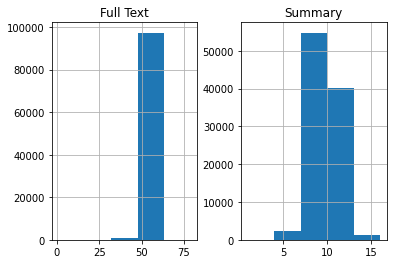

In [14]:
import matplotlib.pyplot as plt #pip install matplotlib

text_word_count = []
summary_word_count = []

for i in cleaned_full_text:
    text_word_count.append(len(i.split()))
for i in cleaned_summary:
    summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'Full Text': text_word_count, 'Summary': summary_word_count})
length_df.hist(bins=5)
plt.show()

In [15]:
count = 0
for i in cleaned_full_text:
    if(len(i.split()) <= 70):
        count += 1
print(count/len(cleaned_full_text))

count = 0
for i in cleaned_summary:
    if(len(i.split())<=13):
        count += 1
print(count/len(cleaned_summary))

0.9999898332655551
0.9978446522976819


In [16]:
max_text_len = 70
max_summary_length = 13

cleaned_full_text = np.array(news_summary['cleaned_text'])
cleaned_summary = np.array(news_summary['cleaned_summary'])

short_full_text = []
short_summary = []

for i in range(len(cleaned_full_text)):
    if(len(cleaned_summary[i].split())<=max_summary_length and len(cleaned_full_text[i].split())<=max_text_len):
        short_full_text.append(cleaned_full_text[i])
        short_summary.append(cleaned_summary[i])

df=pd.DataFrame({'full_text':short_full_text,'summary':short_summary})

from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(df['full_text']),np.array(df['summary']),test_size=0.1,random_state=0,
                                       shuffle=True)
df.head()

full_text  \
0  saurav kant an alumnus of upgrad and iiitb pg program in machine learning and artificial intelligence was sr systems engineer at infosys with almost years of work experience the program and upgrad...   
1  new zealand defeated india by wickets in the fourth odi at hamilton on thursday to win their first match of the fivematch odi series india lost an international match under rohit sharma captaincy ...   
2  with aegon life iterm insurance plan customers can enjoy tax benefits on your premiums paid and save up to ã¢ââ¹^ on taxes the plan provides life cover up to the age of years also customers have ...   
3  pakistani singer rahat fateh ali khan has denied receiving any notice from the enforcement directorate over allegedly smuggling foreign currency out of india it would have been better if the autho...   
4  weeks after excbi director alok verma told the department of personnel and training to consider him retired the home ministry asked him to join work on the last day of his fixed tenure as director...   

                                                                           summary  
0        sostok upgrad learner switches to career in ml al with salary hike eostok  
1         sostok new zealand end rohit sharmaled india match winning streak eostok  
2           sostok aegon life iterm insurance plan helps customers save tax eostok  
3  sostok rahat fateh ali khan denies getting notice for smuggling currency eostok  
4     sostok govt directs alok verma to join work day before his retirement eostok

In [17]:
print(len(x_tr))
print(len(x_val))
print(len(y_tr))
print(len(y_val))

83680
9298
83680
9298


In [18]:
x_tokenizer = Tokenizer() 
x_tokenizer.fit_on_texts(list(x_tr))  

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in x_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
x_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
x_tokenizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences
x_tr_seq    =   x_tokenizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tokenizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

% of rare words in vocabulary: 67.56459224797297
Total Coverage of rare words: 2.112249207753945
Size of vocabulary in X = 33884


In [19]:
#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer()   
y_tokenizer.fit_on_texts(list(y_tr))

thresh=4
cnt=0
tot_cnt=0
freq=0
tot_freq=0

for key,value in y_tokenizer.word_counts.items():
    tot_cnt=tot_cnt+1
    tot_freq=tot_freq+value
    if(value<thresh):
        cnt=cnt+1
        freq=freq+value
    
print("% of rare words in vocabulary:",(cnt/tot_cnt)*100)
print("Total Coverage of rare words:",(freq/tot_freq)*100)

#prepare a tokenizer for reviews on training data
y_tokenizer = Tokenizer(num_words=tot_cnt-cnt) 
y_tokenizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences
y_tr_seq    =   y_tokenizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tokenizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_length, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_length, padding='post')

#size of vocabulary
y_voc  =   y_tokenizer.num_words +1

y_tokenizer.word_counts['sostok'],len(y_tr)
print("Size of vocabulary in Y = {}".format(y_voc))

% of rare words in vocabulary: 65.26167040249489
Total Coverage of rare words: 4.106157185829021
Size of vocabulary in Y = 14259


In [20]:
ind=[]
for i in range(len(y_tr)):
    cnt=0
    for j in y_tr[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)
x_tr=np.delete(x_tr,ind, axis=0)

ind=[]
for i in range(len(y_val)):
    cnt=0
    for j in y_val[i]:
        if j!=0:
            cnt=cnt+1
    if(cnt==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [21]:
print(len(x_tr))
print(len(x_val))
print(len(y_tr))
print(len(y_val))

83680
9298
83680
9298


# Hyperparameters for Seq2Seq LSTM Model
1. 1 layer of LSTM model for encoder
2. Latent_dim with hidden size with a power of 2 (1,2,4,8....) 
3. Only Drop out to encoder with 0.2 or 0.8

In [22]:
from keras import backend as K 
K.clear_session()

latent_dim = 128
embedding_dim = 128
print("Size of vocabulary from the w2v model = {}".format(x_voc))

# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output1, state_h, state_c = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.2,recurrent_dropout=0.2)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.2,recurrent_dropout=0.2)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()

Using TensorFlow backend.


Size of vocabulary from the w2v model = 33884
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    4337152     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, None, 128),  131584      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
________________________________________________

In [32]:
!pip install pickle-mixin

  Created wheel for pickle-mixin: filename=pickle_mixin-1.0.2-py3-none-any.whl size=5998 sha256=eb02f6e8adf8eb4150a0a292571fd907a0f3087529766e0d4db7953bae195ac5
  Stored in directory: c:\users\lkw06\appdata\local\pip\cache\wheels\82\53\b0\6f80da2d461fa5f582eb274b0158ce81d01b977cbb59a2ae6a
Successfully built pickle-mixin


In [23]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es], batch_size = 128, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Train on 83680 samples, validate on 9298 samples
Epoch 1/50
83680/83680 [==============================] - 440s 5ms/sample - loss: 5.7226 - val_loss: 5.3090
Epoch 2/50
83680/83680 [==============================] - 425s 5ms/sample - loss: 5.2437 - val_loss: 5.0248
Epoch 3/50
83680/83680 [==============================] - 474s 6ms/sample - loss: 4.9647 - val_loss: 4.7992
Epoch 4/50
83680/83680 [==============================] - 518s 6ms/sample - loss: 4.7582 - val_loss: 4.6485
Epoch 5/50
83680/83680 [==============================] - 542s 6ms/sample - loss: 4.6005 - val_loss: 4.5279
Epoch 6/50
83680/83680 [==============================] - 443s 5ms/sample - loss: 4.4736 - val_loss: 4.4312
Epoch 7/50
83680/83680 [==============================] - 441s 5ms/sample - loss: 4.3672 - val_loss: 4.3549
Epoch 8/50
83680/83680 [==============================] - 451s 5ms/sample - loss: 4.2731 - val_loss: 4.2924
Epoch 9/50
83680/83680 [==============================] - 453s 5ms/sample - loss: 4.192

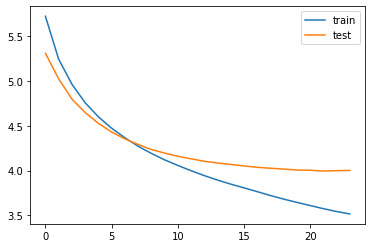

In [24]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [25]:
reverse_target_word_index = y_tokenizer.index_word
reverse_source_word_index = x_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [55]:
# Inference Models

# Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs,
                      state_h, state_c])

# Decoder setup

# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim, ))
decoder_state_input_c = Input(shape=(latent_dim, ))
decoder_hidden_state_input = Input(shape=(max_text_len, latent_dim))

# Get the embeddings of the decoder sequence
dec_emb2 = dec_emb_layer(decoder_inputs)

# To predict the next word in the sequence, set the initial states to the states from the previous time step
(decoder_outputs2, state_h2, state_c2) = decoder_lstm(dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_outputs2 = decoder_dense(decoder_outputs2)

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,
                      decoder_state_input_h, decoder_state_input_c],
                      [decoder_outputs2] + [state_h2, state_c2])

In [56]:
def decode_sequence(input_seq):

    # Encode the input as state vectors.
    (e_out, e_h, e_c) = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1
    target_seq = np.zeros((1, 1))

    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''

    while not stop_condition:
        (output_tokens, h, c) = decoder_model.predict([target_seq]
                + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if sampled_token != 'eostok':
            decoded_sentence += ' ' + sampled_token

        # Exit condition: either hit max length or find the stop word.
        if sampled_token == 'eostok' or len(decoded_sentence.split()) \
            >= max_summary_length - 1:
            stop_condition = True

        # Update the target sequence (of length 1)
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        (e_h, e_c) = (h, c)

    return decoded_sentence

In [57]:
# To convert sequence to summary
def seq2summary(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0 and i != target_word_index['sostok'] and i != target_word_index['eostok']:
            newString = newString + reverse_target_word_index[i] + ' '

    return newString


# To convert sequence to text
def seq2text(input_seq):
    newString = ''
    for i in input_seq:
        if i != 0:
            newString = newString + reverse_source_word_index[i] + ' '

    return newString


In [ ]:
rouge=Rouge()
rouge1_prec = 0
rouge1_recall = 0
rouge1_f = 0

rouge2_prec = 0
rouge2_recall = 0
rouge2_f = 0
for i in range(0,len(x_tr)):
    print ('Review:', seq2text(x_tr[i]))
    print ('Original summary:', seq2summary(y_tr[i]))
    print ('Predicted summary:', decode_sequence(x_tr[i].reshape(1,max_text_len)))
    print ('\n')
    
    rouge_scores = rouge.get_scores(seq2summary(y_tr[i]),decode_sequence(x_tr[i].reshape(1,max_text_len)))
    rouge1_prec +=rouge_scores[0].get('rouge-1').get('p')
    rouge1_recall +=rouge_scores[0].get('rouge-1').get('r')
    rouge1_f +=rouge_scores[0].get('rouge-1').get('f')
    
    rouge2_prec +=rouge_scores[0].get('rouge-2').get('p')
    rouge2_recall +=rouge_scores[0].get('rouge-2').get('r')
    rouge2_f +=rouge_scores[0].get('rouge-2').get('f')

Review: the state election commission has issued directive to the chief secretary and all the three municipal commissioners seeking removal of the word from all forms of displays including hoardings and aam aadmi clinic delhi bjp delegation led by leader of opposition vijender gupta had made the demand and the ec has sought compliance report within hours 
Original summary: remove word from government hoardings delhi ec 
Predicted summary:  ec issues notice to govt for not in k'taka


Review: youtube has said it did not find any evidence of russian interference during the uk brexit vote in there is no constraint on the resources we will put into getting this right youtube global head of public policy downs said this comes after twitter reported that russian accounts tweeted times collectively during the brexit campaign 
Original summary: found no interference from russia in brexit vote youtube 
Predicted summary:  we are not in the world war russia


Review: facebook has launched its to

Exception ignored in: <bound method ScopedTFGraph.__del__ of <tensorflow.python.framework.c_api_util.ScopedTFGraph object at 0x000001EA56A16BE0>>
Traceback (most recent call last):
  File "C:\Users\lkw06\Anaconda3\envs\ev_2\lib\site-packages\tensorflow_core\python\framework\c_api_util.py", line 52, in __del__
    c_api.TF_DeleteGraph(self.graph)
AttributeError: 'ScopedTFGraph' object has no attribute 'graph'


Review: the nobel prize in physiology or medicine has been awarded jointly to american scientist james allison and japanese researcher for their discovery of cancer therapy by of negative immune regulation the discovery made by the two medicine laureates takes advantage of the immune system ability to attack cancer cells by releasing the brakes on immune cells 
Original summary: james win nobel prize in medicine 
Predicted summary:  nobel prize life in raping yearold


Review: gold manufacturing giant rajesh exports is among the biggest jumpers on the fortune global list jumping as much as ranks from the previous year the company featured on the list at the th spot with revenue of over billion moreover as many as seven indian companies featured on the list including mukesh ambaniled reliance industries 
Original summary: rajesh exports jumps ranks on fortune global list 
Predicted summary:  kg of the world largest bank stock falls


Review: police on tuesday said that at least people d

Predicted summary:  india beat australia to win their first test series


Review: the bcci has doubled the cash rewards to ã¢ââ¹ crore each for indian cricket team members after they managed to secure four series victories in row during the home test season however the board has kept the cash rewards unchanged for coach anil kumble and support staff who will get ã¢ââ¹ lakh and ã¢ââ¹ lakh respectively 
Original summary: bcci doubles rewards for team india for straight series wins 
Predicted summary:  bcci announces ã¢ââ¹ crore for indian team


Review: congress president rahul gandhi on thursday posted prime minister narendra modi card' and gave him an in the of agriculture in karnataka he added that there was no contribution by the bjp to the congressled state government ã¢ââ¹crore farm loan waiver and that farmers were suffering because of the pm crop insurance scheme 
Original summary: rahul posts on pm gives in agriculture 
Predicted summary:  pm modi rahul gandhi calls for kar

Predicted summary:  delhi airport to get ã¢ââ¹ lakh from airport


Review: karnataka cm hd kumaraswamy on saturday expanded his cabinet inducting eight members from coalition partner congress whereas two others were removed the decision was taken to ensure proper caste and regional representation in view of lok sabha elections an official said the congress has share of berths in the member ministry whereas the jds has 
Original summary: congress ministers inducted in k'taka cabinet removed 
Predicted summary:  k'taka cm mamata banerjee launches new party in gujarat


Review: talking about the protests against the tamil nadu sterlite plant actorturnedpolitician rajinikanth said the attack on the collector office and setting on fire sterlite quarters was not done by common people some antisocial elements infiltrated the government should crush such antisocial elements with an iron it will result in great danger for tamil nadu he added 
Original summary: antisocial elements sterlite stir

Predicted summary:  pm modi is the world largest congress


Review: a team of international scientists has claimed to have discovered star identical to the sun named hd the star formed in the same cluster as the sun about billion years ago the team claimed studying these stars can help us understand where in the galaxy and under which conditions the sun was formed one of the scientists said 
Original summary: scientists claim to have discovered star identical to sun 
Predicted summary:  scientists find to find black hole in space


Review: a us man was convicted on all charges in the death of his yearold daughter who was shot by constable serving eviction papers with bullet that went through her father arm the constable shot after the man pointed loaded rifle at him parents are supposed to protect their put them in harm way an attorney said 
Original summary: man convicted in daughter death from bullet that hit him first 
Predicted summary:  man kills wife for not wearing mother in us


Predicted summary:  yearold girl raped by men in delhi


Review: peoples democratic party mla qamar hussain choudhary and three of his bodyguards on tuesday were charged with attempt to murder in jammu and kashmir rajouri district the mla and his guards allegedly thrashed the complainant because the victim did not vote for him in the assembly elections police officials said however choudhary has called the fir against him conspiracy 
Original summary: pdp mla bodyguards charged with attempt to murder in jk 
Predicted summary:  bjp mla booked for raping killing in jk


Review: researchers have reported the discovery of new ant species from the southeast asian island of borneo that explodes to defend its colony named the species its body wall to release sticky toxic liquid from its glands to either kill or hold off the enemy it was previously nicknamed yellow for its 
Original summary: ant species that explodes to defend its colony discovered 
Predicted summary:  scientists find new spec

Predicted summary:  man who is the electric car service


Review: formula one has hired brian tyler the american composer of several fast and furious movies to write new theme tune for the organisation alongside the fast and furious franchise tyler has also written music for movies including avengers age of iron man and thor the dark world formula one recently abolished 'grid girls' from races 
Original summary: formula hires fast and furious composer for new theme song 
Predicted summary:  singer who is the new year


Review: former indian captain mohammad azharuddin was barred from attending the hyderabad cricket association meeting on sunday azharuddin was stopped and made to wait for an hour at the main gate of the rajiv gandhi international stadium the meeting convened to adopt the lodha panel recommendations ended abruptly amid chaos after azharuddin arrival 
Original summary: azharuddin barred from hyderabad cricket association meeting 
Predicted summary:  former aus captain ban

Predicted summary:  oneplus to launch its own cryptocurrency


Review: the tmc in west bengal has put up posters slamming the bjpled centre that read ram ka naam na karo don't malign the name of ram the excerpt is taken from bollywood song from the which was sung by kishore kumar the tmc said that it is the beginning and more such innovative posters will come soon 
Original summary: tmc posters slam bjp saying ram ka naam na karo 
Predicted summary:  bjp leader calls it on twitter


Review: elon muskled spacex falcon rocket which was launched carrying government satellite has survived the descent despite making no landing attempt this rocket was meant to test very high landing in water so it did not hurt the droneship but amazingly it has survived musk tweeted the rocket landed in the atlantic and will be towed back to shore 
Original summary: spacex rocket survives descent despite no landing attempt 
Predicted summary:  spacex rocket crashes into rocket launch in pakistan


Review: he

Predicted summary:  sachin tendulkar is to be me for my life n


Review: a trams transport system was introduced in delhi in by delhi reportedly had about kilometres of tram track with functioning trams the system was however stopped due to congestion in the the government in planned to reintroduce trams as public transport in chandni chowk area but abandoned the idea citing high infrastructure cost 
Original summary: delhi once had system of 
Predicted summary:  delhi delhi records its first ever


Review: minister of state for railways rajen gohain on wednesday said the railways cannot be compared to airlines adding that train fares may or may not be higher than airfares he said railways is not losing passengers to airlines this comes after comptroller and auditor general report said travelling in was cheaper than travelling in trains for several routes 
Original summary: cannot compare railways with airlines minister 
Predicted summary:  govt asks air india to open on flight


Revie

Predicted summary:  saudi arabia to get its own school


Review: actor shah rukh khan has shared video where he goes underwater and is seen attempting to recite his popular dialogues from some films including 'devdas' and 'dilwale dulhania le jayenge' for his fans the actor said that he did it to celebrate the milestone of gaining over million followers on twitter 
Original summary: srk tries his dialogues underwater for his fans 
Predicted summary:  shah rukh khan shares video of his world cup with


Review: pm narendra modi will address the nation on may on completion of years of the nda government at the centre modi will give the speech from assam guwahati as the first anniversary of the bjp government in the state will also be celebrated on may the first bjp government in assam took over on may 
Original summary: modi to address nation on completion of years of nda govt 
Predicted summary:  pm modi to visit to years in india


Review: five indians have made it to the world economic

Predicted summary:  india test is the world best test captain


Review: a usbased study suggests that headsets that allow controlling robots and play video games need better security as hackers could guess user passwords by monitoring their researchers found algorithms within malicious could make educated based on user history to shorten the odds of cracking pin from one in to one in 
Original summary: hackers could use to steal passwords study 
Predicted summary:  users have been used to study


Review: germany foreign office issued travel advisory to its citizens living in canada on twitter asking them to be nice to the canadians and give hugs this comes after germany ice hockey team defeated ninetime winter olympics champions canada in the men semifinals just imagine how you would feel if canada beat us in soccer read part of the tweet 
Original summary: germany asks citizens to hug post win in olympics 
Predicted summary:  uk to stop women from world cup after not win


Review: egy

Predicted summary:  govt to set up in its own services by govt


Review: russian startup is aiming to launch cube satellites to create programmable display in the night sky with potential audience of billion people with sqkm area 'the orbital display' would show advertisements for sixminute intervals over particular region each satellite orbiting at nearearth altitude of km would reflect sunlight and represent one pixel 
Original summary: russian startup aims to put ads in orbit for global audience 
Predicted summary:  microsoft launches million to let users create


Review: the gst council on saturday approved quarterly filing of return for small taxpayers having turnover of up to ã¢ââ¹ crore as an optional facility the move is expected to benefit of the taxpayers who have turnover of less than ã¢ââ¹ crore however they will need to deposit the tax every month 
Original summary: taxpayers with up to ã¢ââ¹cr turnover to file returns quarterly 
Predicted summary:  govt approves ã¢ââ¹

Predicted summary:  trump calls russia for new york


Review: thai authorities overseeing an operation to rescue football team of kids and their coach stuck in cave have said that they have day window to attempt their rescue torrential rains forecast next week could lead to rise in water levels in the flooded cave possibly delaying the rescue operation till january next year 
Original summary: day window to save kids stuck in thai cave rescuers 
Predicted summary:  boys rescued from thai cave rescued after cave


Review: egyptian woman eman ahmed who had come to mumbai for her weight loss treatment left for abu dhabi on thursday for further treatment doctors at the saifee hospital claimed that ahmed lost kg over the course of her treatment notably ahmed weighed kg when she arrived in india and was reportedly the world heaviest woman then 
Original summary: egyptian woman leaves mumbai after losing nearly kg 
Predicted summary:  woman who was shot at the man in delhi


Review: at least 

Predicted summary:  ashwin takes wickets on day after th test match


Review: flipkart cofounder binny bansal has said the ecommerce startup is committed to going public despite its billion acquisition by walmart bansal said an ipo would help find the right partners and make the company way more competitive bringing such partners on board is important for success in the future he added counting tencent as partner and microsoft as prominent investor 
Original summary: flipkart committed to go public despite walmart deal binny bansal 
Predicted summary:  flipkart will buy stake in flipkart for data report


Review: sridevi daughter jhanvi kapoor will make her bollywood acting debut opposite shahid kapoor halfbrother ishaan khatter in the remake of marathi film 'sairat' as per bollywood trade analyst ramesh bala the film will go on floors from december and is being coproduced by karan johar notably 'sairat' is the first marathi film to have earned over ã¢ââ¹ crore 
Original summary: jhan

Predicted summary:  i do not have been my tweets user on metoo


Review: mira rajput while supporting tanushree dutta who accused nana patekar of sexual harassment shared sapna instagram post as her instagram story which said where were all the women when this was happening believe tanushree feel there is something we are missing here point that we fail to acknowledge and own up to the post further said 
Original summary: mira shares actress sapna post to support tanushree 
Predicted summary:  tanushree slams media for not on harassment row


Review: slamming us president donald trump for saying that talking is not the answer while dealing with north korea user tweeted then what is the death of war iii other users wrote talking is the only tweeting this is like slap in the face and the for you have to know how to 
Original summary: twitter slams trump over stance on talks with korea 
Predicted summary:  trump calls kim jongun not to his tweet


Review: using observations from alma radi

Predicted summary:  alibaba raises billion in its ipo


Review: a toilet paper wedding dress with butterflies and train won the first prize in new york fashion competition on thursday submitted by it was one of the entries for the th toilet paper wedding dress contest the finalists were judged on originality creativity and the use of toilet paper 
Original summary: new york hosts annual toilet paper wedding dress contest 
Predicted summary:  couple gets married to make world statue


Review: talking about the difficulties faced by startups while raising capital venture capital vc firm inventus capital india md samir kumar has said rejection from vc is not the end of the road for startup he also said that it is always tough for startups to raise capital from vcs but added that entrepreneurs should not feel disheartened 
Original summary: rejection isnã¢âât end of the road for startup vc firm md 
Predicted summary:  we are not in india to make uber chief


Review: russian president vla

Predicted summary:  myanmar calls for rohingya muslims in myanmar


Review: national president of the rajput organisation rajputana rp singh has said that the ceo of bhansali productions shobha sant has assured him that the 'padmavati' team will screen the film for the organisation before its release he further said once we see the film we can convince others that the film does not distort history in any way 
Original summary: bhansali to show us 'padmavati' before release rajput group 
Predicted summary:  i am not the new film on ceo of film on row


Review: the us ski and snowboard association is using virtual programs to train athletes for the upcoming winter olympic games in pyeongchang the virtual reality training helps athletes get accustomed to the pathways and terrain of the area where they are set to compete during the pyeongchang games 
Original summary: us skiers using vr to train for winter olympics 
Predicted summary:  us national anthem to be auctioned


Review: actor aks

Predicted summary:  tata steel sells ã¢ââ¹ crore stake in sale for ã¢ââ¹ crore


Review: a google employee and an organiser of the walkout to protest the company handling of sexual harassment cases has said hope still have career in silicon valley after thisã¢ââ ã¢ââi experienced sexual harassment at google and didnã¢âât feel safe talking about itã¢ââ she added the demands included ending forced arbitration and pay gap 
Original summary: hope still have career after google organiser 
Predicted summary:  google did not know sexual harassment at cannes


Review: indian premier league side delhi daredevils chose to release the likes of former captain gautam gambhir australian allrounder glenn maxwell and indian pacer mohammad shami ahead of the tournament edition the daredevils who have never won the ipl title have retained players including shreyas iyer prithvi shaw rishabh pant kagiso rabada and trent boult among others 
Original summary: delhi daredevils release their former 

Predicted summary:  dhoni has the best captain in australia


Review: posters were put up in gujarat featuring pictures of senior bjp leaders of the state with the caption reading identify the leaders or you will lose your job this comes after two workers in the state were suspended for failing to recognise bjp politicians the posters put up near the gujarat assembly were later removed by bjp workers 
Original summary: poster asks people to recognise bjp leaders or lose jobs 
Predicted summary:  bjp workers protest against me in gujarat


Review: electric carmaker tesla has been accused of racial discrimination in classaction lawsuit filed by former employee marcus vaughn in the lawsuit vaughn claims he was routinely called the nword by supervisors and coworkers after he began working at the fremont factory in california he said that he complained to human resources officials but they never investigated his claims 
Original summary: tesla accused of racial discrimination in suit 
Predi

Review: the comptroller and auditor general of india cag has warned that flexifare system in premium trains could force passengers to opt for airlines cag stated that while the scheme led to an increase in passenger earnings it has resulted in lower occupancy it also noted that railways had already lost its premium train passengers to other mail and express trains 
Original summary: forcing passengers to opt for airlines cag 
Predicted summary:  over people in india to get emergency landing


Review: bengalurubased premium tea selling startup has raised million in series funding from singaporeheadquartered venture capital firm rb investments as per reports existing investors including accel partners also participated in the ratan tatabacked startup funding founded in by kaushal through its online platform sells teas from darjeeling assam and 
Original summary: ratan tatabacked premium tea startup raises mn 
Predicted summary:  gurugram startup raises million


Review: in his st radio a

Predicted summary:  flipkart to buy stake in flipkart for sale


Review: maharashtra navnirman sena mns chief raj thackeray has decided to hold an rally in thane on november party officials said they will hold the rally even if they fail to secure permission as people are enthusiastic to hear thackeray notably the party has been forcibly evicting hawkers from railway stations since the elphinstone stampede claimed several lives 
Original summary: mns chief raj thackeray to hold rally in thane 
Predicted summary:  rajinikanth will be in tamil nadu after months


Review: after being transferred for the st time in his career haryana ias officer ashok khemka on sunday tweeted so much work planned news of another transfer crash landing again vested interests win khemka who was earlier posted in the social justice and empowerment department will now serve as the principal secretary in the youth affairs and sports department 
Original summary: interests win tweets ias after st transfer 
Predi

Review: a haryana court has sentenced woman to years in prison for murdering her husband by cutting him into eight pieces she wanted to get rid of her husband after she had an extramarital affair with another man the victim body parts were found in different places in the house 
Original summary: woman who cut husband into pieces sent to jail for yrs 
Predicted summary:  woman jailed for yrs for raping woman in uk


Review: us president donald trump and his staff are set to temporarily move out of the white house west wing as renovations on the building get underway adding that the massive renovation is more out of necessity than cosmetic white house official said that work has already begun to replace the west wing yearold heating ventilation and air conditioning system 
Original summary: white house to undergo renovation 
Predicted summary:  trump to get out of putin over hotel in paris


Review: sourav ganguly wife at an event said the former captain act at lord after india natwest 

Predicted summary:  cbi arrests bank of ã¢ââ¹ crore fraud accused of fraud


Review: mumbai indians eased to wicket win over defending champions sunrisers hyderabad in their indian premier league match on wednesday batting first sunrisers hyderabad put up with shikhar dhawan and david warner scoring and respectively in reply yearold nitish rana ball guided mumbai indians' chase which ended in overs 
Original summary: mumbai indians ease past sunrisers hyderabad 
Predicted summary:  mumbai mumbai beat sl to win against an league


Review: the iitdelhi administration has decided to make students from the next batch sign an undertaking during admissions that they will not drink alcohol smoke cigarettes or use drugs on campus the institute said its earlier approach to inform parents when students violated its ban on drinking and smoking had failed students found violating the undertaking will be penalised or expelled 
Original summary: iitdelhi asks for against drinking smoking 
Predicted

Predicted summary:  delhi hc refuses to move to delhi hc against


Review: apple has said it will employ human trafficking survivors to work in its retail stores it comes after the company won an international award in its efforts to help end slave labour as company whose work many people we feel we have an enormous turn our values into action apple retail head angela ahrendts said 
Original summary: apple to employ human trafficking survivors in retail stores 
Predicted summary:  apple to give up to help kids years ago


Review: renowned indian author bond has said that india has become much cleaner following swachh bharat mission the problem however is that people return to their old habits and it would take time to change that bond added while addressing an audience in jharkhand ranchi bond said he was amazed to see the cleanliness in the city 
Original summary: india much cleaner after swachh bharat mission bond 
Predicted summary:  india is the best actor in india


Review: the la

Predicted summary:  baahubali actor becomes highest paid actress


Review: upset with the behaviour of drunk tourists the residents of village in north goa have demanded that the bars in the area should be either closed or relocated the villagers claimed that tourists would harass them and even start fights with bar owners and alcohol vendors resolution has been signed by villagers to close the bars 
Original summary: goa villagers demand closure of bars over drunk tourists 
Predicted summary:  people in goa to stop using water from goa


Review: television actress sanjeeda shaikh sisterinlaw has filed domestic violence case against the actress her brother anas abdul rahim and her mother has accused her husband sanjeeda and her motherinlaw of physical abuse however sanjeeda lawyer has claimed that the court has passed judgement in favour of the actress 
Original summary: domestic abuse case filed against by sisterinlaw 
Predicted summary:  actress files complaint against her over remar

Predicted summary:  india has to be more than pm modi


Review: singer chinmayi sripaada who has sung for movies like chennai express recently tweeted about being robbed in the united states she said that the thief smashed the glass of her car and took away her laptop and other belongings chinmayi added that the local police said such incidents were common 
Original summary: chennai express singer chinmayi gets robbed in us 
Predicted summary:  singer claims he was fired at her


Review: questioning supreme court role in triple talaq issue an all india muslim personal law board member said the court work is to make decisions within the purview of law and to not make the law maulana ur rehman further said the interference of the apex court and the government in shariat the islamic religious law is also wrong 
Original summary: supreme court has no right to make laws muslim board member 
Predicted summary:  sc asks muslim women to be given triple talaq bill


Review: north korea has warn

Predicted summary:  mumbai cops steal fake job worth ã¢ââ¹ crore


Review: the power demand in delhi broke its previous record of megawatt by rising up to megawatt on friday the yamuna power limited and rajdhani power limited have longterm power purchase agreements and banking arrangements with other states to meet the growing power demand of over lakh consumers in the national capital 
Original summary: power demand in delhi rises to record 
Predicted summary:  delhi metro to get its own own after years


Review: jaydev unadkat who was sold for ã¢ââ¹ crore to become the costliest indian player at the ipl auction is now the indian player with the highest base price at the upcoming ipl auction unadkat whose base price is ã¢ââ¹ crore will be part of the auction alongside other indian cricketers 
Original summary: unadkat has highest base price for an indian at ipl auction 
Predicted summary:  who is the ipl most expensive indian players in


Review: american cartoonist shannon wheeler

Predicted summary:  yearold becomes st indian to score runs in cricket


Review: robotics usbased selfdriving trucking startup cofounded by former uber employee don has raised million in series round of funding the round was led by battery ventures with participation from lightspeed venture partners and tusk ventures as part of the deal battery general partner will join the threemonthold startup board 
Original summary: exuber employee selfdriving truck startup raises mn 
Predicted summary:  uber startup raises million


Review: saudi arabia on thursday paid billion riyals over ã¢ââ¹ crore to half of the kingdom population under new welfare scheme for low and middleincome families bank transfers were made to approximately million families reaching around million beneficiaries the ministry of labour and social development said while the maximum payment was ã¢ââ¹ the minimum was around ã¢ââ¹ 
Original summary: half of saudi population gets ã¢ââ¹cr in new welfare scheme 
Predicted sum

Predicted summary:  microsoft reveals its its own app


Review: the nawazuddin siddiqui starrer 'manto' biopic on writer saadat hasan manto is an experience that does not get over with the movie wrote the quint there is gap between the vision and the execution wrote indian express while times of india wrote nawazuddin your conscience 'manto' was rated the quint indian express and toi 
Original summary: nawazuddin siddiqui starrer 'manto' hits the theatres 
Predicted summary:  nawazuddin starrer hits the theatres


Review: usbased astronomers have discovered sunlike star dubbed kronos and its binary twin about lightyears away from earth they estimated kronos consumed around earth masses of rocky material the team based their claims on finding differences between kronos and for elements like iron silicon magnesium and lithium which make up rocky planets like earth 
Original summary: astronomers find sunlike star that its own planets 
Predicted summary:  scientists find star in space


Re

Predicted summary:  was told me to have sex with ranveer


Review: technology major apple has hired sony television executives jamie and zack van who oversaw the development of the emmy awardwinning show 'breaking the two will join apple in newly created positions to oversee all aspects of video programming the company said apple is reportedly planning to rival netflix and amazon prime with its apple tv service 
Original summary: apple hires sony executives behind 'breaking tv show 
Predicted summary:  apple exec accused of stealing flipkart report


Review: maharashtra navnirman sena mns leader sushant suffered head injuries on saturday after several hawkers allegedly beat him up with iron rods in mumbai malad the mns workers alleged that the hawkers were incited by congress leader sanjay nirupam who addressed rally earlier in the day in retaliation around mns workers vandalised the stalls of hawkers in dadar 
Original summary: mumbai hawkers beat up mns leader with iron rods 
Predict

Predicted summary:  how did not use to be called by


Review: india will have no internet subscribers left by june according to report by research firm research with the availability of cellular in smartphones is fast becoming the default internet access the report said the outcome was attributed to the cost of and competitive reduction in mobile data rates by service providers 
Original summary: india will not have internet users by june report 
Predicted summary:  india to ban on global body claims


Review: a advertisement campaign by media house has been slammed by twitter users for mentioning priyanka chopra name along with surnames of the men she has reportedly dated this is not women on top this is putting women down user commented priyanka you better sue them now wrote another user another comment read your private life is nobody business 
Original summary: ad mentions priyanka name with rumoured boyfriends 
Predicted summary:  facebook slammed for ad on her name


Review: the 

Review: ten mlas of the ruling naga people front have resigned from the nagaland assembly as well as the party this comes amidst growing calls to defer assembly elections scheduled for february until the naga insurgency issue is resolved this comes after political parties across nagaland issued joint declaration to not contest elections until the issue is resolved 
Original summary: mlas of ruling party in nagaland resign from assembly 
Predicted summary:  ec mlas mlas in wb assembly elections


Review: a white shark whose twitter page had garnered nearly followers over the last five years has gone missing according to usbased tracking organisation the footlong shark named mary lee was tagged in the atlantic ocean in but her transmitter has not sent out signal since june said adding it could remain alive for more years 
Original summary: shark with lakh twitter followers goes missing 
Predicted summary:  us man who was the youngest person


Review: anupam kher has said it is difficult 

Predicted summary:  bumrah was like bowler on me after being hit by warner


Review: comparing the war in iraq to throwing big fat brick into nest us president donald trump reportedly called former president george bush move to invade the middle east nation the worst decision ever last year bush described trump as guy who does not know what it means to be president 
Original summary: trump called invasion of iraq 'worst decision ever' reports 
Predicted summary:  trump slams white house as he is


Review: north korea has allowed south korean reporters to visit its punggyeri nuclear site south korean unification ministry said on wednesday north korea had invited media from other countries to witness the dismantling of the punggyeri to uphold its pledge to discontinue nuclear tests earlier it had declined south korean reporters' visit in protest against ussouth korea military drills 
Original summary: n korea allows south korean reporters to visit nuclear site 
Predicted summary:  north 

Predicted summary:  bjp cannot be used to use of its swamy


Review: afghanistan has ordered day suspension of instant messaging services whatsapp and telegram to resolve technical problems officials have said so far stateowned salaam network is the only internet provider to obey the order the move has ignited backlash on social media with users describing the blockage as an assault on their right to free speech 
Original summary: afghanistan orders day suspension of whatsapp telegram 
Predicted summary:  afghanistan to stop using whatsapp to fight against


Review: us president donald trump has put pakistan on notice for providing safe haven to terrorist organisations in its soil us vice president mike pence has said during his unannounced visit to afghanistan as the president said pakistan has much to gain from partnering with the us and pakistan has much to lose by continuing to harbour terrorists pence addednn 
Original summary: us puts pakistan on notice for giving safe haven to t

Predicted summary:  tata motors recalls lakh cars in years after liquor ban


Review: a ball of hair weighing kg was removed from yearold woman stomach after surgery at government hospital in indore on monday she had suffered from mental disorder leading her to tear out and chew her hair the hair would have caused serious medical problem if it had not been removed the doctor said 
Original summary: doctors remove kg ball of hair from woman stomach 
Predicted summary:  woman body found in hours at hospital


Review: after international court of justice icj told the us to lift sanctions on iran which are linked to humanitarian goods and civil aviation the us on wednesday pulled out of the treaty of amity with iran iran took the us to icj arguing that it violated terms of the treaty by reimposing sanctions following withdrawal from nuclear deal 
Original summary: us ends treaty with iran over world court decision 
Predicted summary:  iran rejects us sanctions against iran


Review: late a

Predicted summary:  russian firm makes ã¢ââ¹ crore for its first time


Review: a team of artists and palaeontologists has created an image of the trex which shows that the dinosaur had and no feathers it is the most accurately reconstructed image of the dinosaur the researchers claimed they added that the predator walked with its stomach very low to the ground due to its low centre of gravity 
Original summary: trex image shows it had no 
Predicted summary:  scientists create new


Review: there was brawl on plane in russia after yearold man demanded to be allowed off the aircraft for smoke just before takeoff the man believed to be drunk exchanged punches with fellow passenger who told him that he could smoke after the plane landed following this the man was taken off the plane and arrested 
Original summary: man demands to step outside plane for smoke sparks brawl 
Predicted summary:  man who killed plane for being hit by plane for the year


Review: facebook has reportedly asked l

Predicted summary:  north korea releases video of us with missile


Review: haryana cm manohar lal khattar has announced that the state will become stray cattle free by august the tagging of of cattle in gaushalas and shelters for bovine animals has been completed and the work to rehabilitate abandoned cattle is being undertaken in mission mode khattar said 
Original summary: haryana to become stray cattle free by august 
Predicted summary:  haryana cm to get free for


Review: india motorcycle manufacturer royal enfield has launched ã¢ââ¹ lakh motorcycle model inspired by the world war ii era called the classic pegasus each bike features and blue pegasus emblem on the fuel tank along with an individual serial number the bike also known as the flying flea was used by british behind enemy lines 
Original summary: india royal enfield launches ã¢ââ¹l bike based on ww ii era 
Predicted summary:  indian museum offers ã¢ââ¹ lakh to build victims


Review: a panel headed by retired sc judg

Review: nawazuddin siddiqui has dedicated his best supporting actor iifa award which he won for the film 'mom' to late actress sridevi it was once in lifetime opportunity to work with the first female superstar sridevi and dedicate my award as tribute to her he tweeted sridevi was posthumously named the best actress for 'mom' at iifa 
Original summary: nawazuddin dedicates his iifa award to late actress sridevi 
Predicted summary:  nawazuddin aishwarya rai only film to be given years ago


Review: chinese smartphone maker xiaomi is in talks with investment banks about an initial public offering ipo and seeks valuation of at least billion according to reports the reports also suggested that xiaomi is considering an ipo as early as the second half of xiaomi last raised money in at valuation of billion 
Original summary: xiaomi seeks valuation of billion in ipo report 
Predicted summary:  alibaba may buy stake in china for billion report


Review: india ended day two of the dharamsala tes

Predicted summary:  no aadhaar mandatory for money if it is


Review: islamist militant group boko haram has abducted more than children in nigeria since the unicef has claimed children were abducted to spread fear and show power the agency further claimed the conflict with boko haram which entered its tenth year has claimed more than lives and displaced more than lakh people 
Original summary: boko haram abducted children since unicef 
Predicted summary:  rohingya children found in myanmar


Review: ranveer singh on monday took to instagram to share caricature of his character in rohit shetty upcoming film 'simmba' and captioned it aala re aala simmba aala he will play cop in the film which is remake of telugu action film 'temper' also starring sara ali khan the film is scheduled to release on december 
Original summary: aala re aala simmba aala ranveer shares his caricature 
Predicted summary:  ranveer singh shares pic of his film on sets of ranbir


Review: actor anupam kher has rev

Review: six people including three women have been arrested for allegedly extorting money from man in haryana after filing false rape case against his son the accused had already taken ã¢ââ¹ from the man and had demanded another ã¢ââ¹ lakh to withdraw the complaint the crime occurred after the man son ended his relationship with one of the accused 
Original summary: false rape case filed to extort money from man arrested 
Predicted summary:  man arrested for raping yrold daughter in delhi


Review: supporting swara bhasker who was trolled for calling pakistan state' sonam kapoor said think people just like to troll her because she has an opinion swara had made the remark on being asked about her film 'veere di wedding' being banned in pakistan following her statement she was also slammed by pakistani actress 
Original summary: people like to troll swara because she has an opinion sonam 
Predicted summary:  i am not let me rishi on trolls with kareena


Review: three days after vishal

Predicted summary:  climate change could be study


Review: technology giant microsoft indiaborn ceo satya nadella has said that the choices that people make in will define what happens in speaking at recent event about artificial intelligence ai he also said that societies are and ai can empower us depending on the choices we make as designers of ai 
Original summary: choices people make in will define microsoft ceo 
Predicted summary:  microsoft working on face of staff on tech tech


Review: a couple got divorced minutes after their wedding ceremony got over in gujarat gondal as disagreement broke out and relatives from both sides started throwing dishes at each other during lunch the advocates representing both sides arrived at the marriage hall and got the couple divorced within minutes the couple even reportedly returned the gifts exchanged during the ceremony 
Original summary: couple divorces minutes after marriage as families fight over lunch 
Predicted summary:  couple gets m

Predicted summary:  us approves ã¢ââ¹ crore to japan nuclear weapons


Review: priyanka chopra wedding outfit will reportedly be designed by manish malhotra reports also suggested that priyanka met designers abu jani and sandeep khosla for discussing an outfit for prewedding functions priyanka will get married to nick jonas in jodhpur in december as per reports she recently said that her wedding outfit would be cute and comfortable 
Original summary: priyanka wedding outfit to be designed by manish reports 
Predicted summary:  priyanka nick to get married in reports


Review: in first for the suburban railways western railway on thursday launched breastfeeding room at bandra station the rooms were constructed after the railway ministry issued directive asking zonal heads to provide baby feeding within waiting halls at all and category stations the facility is also available at other mumbai stations handling longdistance trains 
Original summary: bandra becomes st suburban station to g

Predicted summary:  oneplus launches its first indian firm in ã¢ââ¹ crore


Review: there have been uk prime ministers during the reign of queen elizabeth ii who acceded to the british throne on february she became queen aged following the death of her father king george vi but was crowned when she was she is the longestserving living monarch and the wealthiest queen in the world 
Original summary: during queen elizabeth ii there have been uk pms 
Predicted summary:  uk parliament prince harry meghan markle


Review: a man has registered an fir with the delhi police claiming that he found fake ã¢ââ¹ note in the money he withdrew from an atm in south delhi the note is half original and half of it is plain paper as per reports police said that it was examining the cctv footage of the atm 
Original summary: man files fir after delhi atm dispenses fake ã¢ââ¹ note 
Predicted summary:  man held for fake notes to sell ã¢ââ¹ in delhi


Review: north korea has said it is still open to holdi

Predicted summary:  sbi to cut sbi term as as chairman of


Review: dr vijay nath mishra professor in the banaras hindu university has developed desktop app which plays devotional music when users try to access inappropriate websites containing pornography violence or other vulgar content the app which is named 'har har was launched on monday for laptops and desktops it will soon be available for android devices as well 
Original summary: app by bhu professor plays bhajans on searching for porn 
Predicted summary:  app lets users play in app in guj


Review: canadabased researchers studying over adults have identified nine genes that can make one with high body mass index bmi gain more weight the effect of these genes may be amplified by four times when compared with populations at the lower of bmi to at the higher end scientists noted of bmi is related to genetics 
Original summary: scientists identify genes that may increase obesity 
Predicted summary:  scientists create human cells


Predicted summary:  pak airlines launches its own food amid food firing


Review: the finance ministry on monday clarified that renting or leasing of land by farmers for agriculture forestry fishing or animal husbandry is exempt from gst it dismissed rumours that farmers would now have to pay gst when they lease out their land calling the reports factually incorrect and misleading are also exempted from gst registration it added 
Original summary: no gst on of land by farmers government clarifies 
Predicted summary:  govt has ã¢ââ¹ lakh people to farmers in tamil nadu


Review: aamir khan film dangal has become the highest grossing indian film in china after earning ã¢ââ¹ crore within week of its release the film beat pk which was the first indian film to earn over ã¢ââ¹ crore in china notably dangal also currently holds the first position at the chinese boxoffice ahead of guardians of the galaxy vol 
Original summary: dangal becomes highest grossing indian film in china 
Predicted 

Review: india saw the second highest number of millionaire outflow globally with individuals shifting overseas in according to report by new world wealth as many as chinese millionaires changed their domicile in the highest globally however the report said that both these countries are producing far more new individuals than they are losing 
Original summary: indian millionaires moved abroad in report 
Predicted summary:  india has most number of world bank


Review: us president donald trump on monday endorsed alabama republican candidate roy moore in us senate special election despite allegations by multiple women that moore had engaged in sexual misconduct adding that trump had offered his full support moore tweeted look forward to fighting alongside the president to referring to trump slogan make america great again 
Original summary: trump backs molestation accused roy moore for senate 
Predicted summary:  trump releases list of us state university


Review: french fashion house c

Predicted summary:  kohli has hit test runs in an odi series


Review: actor jackie shroff has said his son tiger is like horse as he focuses lot on his work if he gets into any kind of work he does not look anywhere as he only looks ahead and feel people should lead their life like that only he added he further said tiger mentality is different from his own 
Original summary: tiger is like horse he only on work jackie 
Predicted summary:  i am like tiger on my debut with salman


Review: ecommerce giants amazon and flipkart have been issued notices by the drugs controller general of india for allegedly selling fake cosmetics it comes after found indigenously manufactured cosmetics without manufacturing licenses and containing ingredients imported without registration certificates they have been warned of penal actions in case of failing to respond within days 
Original summary: amazon flipkart get notice for alleged sale of fake cosmetics 
Predicted summary:  amazon india fake fake ne

Review: mumbai terror attack survivor moshe holtzberg grandfather on tuesday said mumbai is lot safer now adding that it is very special day the grandfather said moshe is happy to be back to the city after years the boy was two years old when terrorists killed his parents at the nariman house 
Original summary: mumbai is lot safer now survivor grandfather 
Predicted summary:  mumbai police is an indian in uber


Review: a video showing meteor lighting up the night sky in the russian on tuesday has surfaced online the video shows bright flash followed by brief moment of daylight describing the speed of the meteor as monstrous witnesses claimed that the flash lasted for nearly seconds and that they heard loud booms 
Original summary: video meteor lights up night sky in russian 
Predicted summary:  video shows russian minister after his own food delivery


Review: student organisations and indigenous groups have called for an hour bandh across the northeastern states on january from am pm

Predicted summary:  mumbai civic body to get new rules


Review: philippines president rodrigo duterte has said that his american counterpart donald trump would not have become billionaire if he were stupid and called him realistic and pragmatic thinker you just think that you know both of us pretend that if we are insulted we speak that way the case of trump he thinks deeply duterte added 
Original summary: trump would not be billionaire if he were stupid duterte 
Predicted summary:  trump is not the time of us president


Review: in light of the eclipse on august google saw spike of searches for retina damage users searches included how to tell if you have damaged your eyes during the eclipse and why is the solar eclipse bad for your eyes the search giant also showed spike in searches for solar eclipse headache around peak viewing time 
Original summary: google search for damage on eclipse day 
Predicted summary:  google launches new store with in india


Review: researchers at the n

Predicted summary:  serena williams was years ago on serena


Review: actress madhuri dixit took to twitter to share the first look of her debut marathi film 'bucket list' directed by tejas prabha vijay deoskar the film is said to be sliceoflife drama based on woman who is on her path of also starring actress renuka shahane the film has been scheduled for summer release this year 
Original summary: st look of madhuri debut marathi film 'bucket list' out 
Predicted summary:  first look of sanjay dutt starrer out


Review: a tamil nadu traffic police constable has been suspended for allegedly hitting biker with lathi and seriously injuring him for not wearing helmet the victim suffered deep cut on his forehead and was treated at government hospital police said enraged over the constable action locals gathered at the spot and allegedly manhandled him 
Original summary: tn cop suspended for attacking man riding without helmet 
Predicted summary:  cop suspended for molesting woman in tamil 

Predicted summary:  st bowler to hit test runs in the innings of the


Review: reality television personality caitlyn jenner has revealed in her upcoming memoir titled 'the secrets of my life' that she underwent gender reassignment surgery in january this year the surgery was success and feel not only wonderful but liberated she wrote caitlyn further wrote that she was annoyed by fans who were constantly asking about her genitals n 
Original summary: reveals she underwent gender surgery 
Predicted summary:  i was born with cancer sunny on yrold


Review: the indian men hockey team defeated japan in their opening match of the four nations invitational tournament in new zealand on wednesday vivek prasad and dilpreet singh scored brace each while rupinder pal singh and harmanpreet singh netted one goal each the indian under cricket team along with coach rahul dravid attended the match 
Original summary: india thrash japan in first game of nation hockey meet 
Predicted summary:  india beat

Predicted summary:  delhi women to get st time in delhi


Review: oxford university hospitals surgeon andy recently talked about the effect when patients undergo risky and unnecessary surgeries due to the belief of better health after the surgery he said surgical procedures do not undergo rigorous testing as drugs do and cited vested interests of some communities for the same he added doctors need to communicate with patients about 
Original summary: many surgeries unnecessary risky oxford university surgeon 
Predicted summary:  do not have been given to save people


Review: defence minister nirmala sitharaman has called media report in the uk which claimed that uk secretary of state for defence gavin williamson had denied her meeting baseless story mutually convenient date is being worked out for meeting she said the report defence minister sitharaman was referring to had said india was spitting blood after being snubbed 
Original summary: baseless sitharaman on report of uk minister

Review: the ukrainian parliament on thursday approved bill to terminate the treaty on friendship cooperation and partnership with russia under the treaty both nations pledged to not use one territory to harm the other relations between ukraine and russia have been strained since the annexation of crimea and tensions escalated after russia seized ukrainian navy ships and sailors last month 
Original summary: ukraine parliament votes to end friendship treaty with russia 
Predicted summary:  eu to launch new of parliament


Review: keralabased startup and delhibased health have won the global impact challenge and will be going to the silicon valley us for week incubator programme it was jointly organised by the kerala startup mission and the usbased singularity university the challenge aimed at identifying startups working on solutions in learning healthcare and environment sectors 
Original summary: indian startups to go to us post startup challenge win 
Predicted summary:  us startup ge

Review: an iranian student has filed complaint that he was beaten up in jnu during celebrations after india victory over pakistan in the champions trophy on sunday while members of bjp student wing abvp were mentioned among the accused in the complaint the organisation the allegations saying its members were manhandled by those not happy with india win 
Original summary: iranian student beaten up in jnu after indopak match 
Predicted summary:  pak man who asked to take part in jail for talks


Review: the current maharashtra government cares for the farmers the most and has made most of the provisions for schemes related to farmers shiv sena minister deepak kesarkar has said of the over ã¢ââ¹ crore of supplementary demands tabled in the state of over ã¢ââ¹ are for the schemes related to the farmers he added 
Original summary: maha govt for farmers the most shiv sena minister 
Predicted summary:  farmers are the of farmers from pm modi


Review: policemen in the county in florida us h

Predicted summary:  up police station to be in uttar pradesh


Review: the market square tower residential building located in houston united states features swimming pool on the th floor with glass bottom view of the street below the suspended extends about feet away from the building and is reportedly made using an bottom 
Original summary: apartment in us gets glass bottom on th floor 
Predicted summary:  world largest hotel in australia


Review: congress leader mallikarjun kharge has accused lok sabha speaker sumitra mahajan of being 'unfair' after the party was allotted minutes to speak during the debate on the noconfidence motion against the government the allotted time is grossly inadequate to discuss issues affecting farmers women and dalits he alleged meanwhile bjp has been allotted minutes in the sevenhour debate 
Original summary: unfair congress on getting mins for noconfidence debate 
Predicted summary:  congress slams congress over not making emergency


Review: during t

Predicted summary:  india top fifa world cup squad for fifa wc


Review: swedish transport startup has unveiled its allelectric and selfdriving truck called 'the made to carry logs powered by nvidia selfdriving system the truck can access realtime traffic data to plan routes and can be controlled remotely in emergency situations the company claims it can travel km on single charge due to kwh battery pack 
Original summary: startup unveils selfdriving truck made to carry only logs 
Predicted summary:  startup unveils concept that can help people


Review: nba star lebron james wore one black and one white shoe with the word equality in capital gold letters on the back of each shoe during an nba game this is beautiful country and we are never going to let one person dictate how beautiful and how powerful we are lebron later said about us president donald trump 
Original summary: lebron james wears black shoe white shoe for 
Predicted summary:  model who was the youngest female


Review: 

Predicted summary:  nick to get married to priyanka reports


Review: pakistan interior ministry has suspended the licences for all prohibited bore weapons in move aimed at banning automatic weapons reports said the owners of automatic weapons will be able to get their weapons replaced with semiautomatic firearms or get pakistani rupees in return for their weapons according to notification by the ministry 
Original summary: pakistan suspends licences for automatic weapons 
Predicted summary:  pakistan bans use of military for


Review: twotime ipl champions chennai super kings who are returning to the tournament after two years have retained ms dhoni suresh raina and ravindra jadeja for ipl meanwhile royal challengers bangalore and champions mumbai indians retained virat kohli and rohit sharma respectively bhuvneshwar kumar david warner and steven smith were also retained by their respective franchises 
Original summary: csk retains ms dhoni rcb keeps virat kohli for ipl 
Predicted sum

Predicted summary:  un chief calls for un rights chief


Review: alshabaab militants on thursday captured the somalian town of in the semiautonomous region and killed soldiers at military base officials said and added that they recaptured the town later however the alqaedalinked militants claimed that they killed soldiers before leaving the town peacefully this comes after sentenced five alshabaab militants to death 
Original summary: alshabaab kills soldiers in somalia military base attack 
Predicted summary:  isis kills militants in syria in syria


Review: stating that the chain connecting india and sri lanka known as ram setu is an important part of india cultural legacy union law minister ravi shankar prasad said nobody should tamper with it this comes after science channel 'what on earth' show promotional video claimed that ram setu is manmade 
Original summary: nobody should tamper with ram setu union law minister 
Predicted summary:  ram temple should be the country of india se

Predicted summary:  i am not to be ready for film industry


Review: a yearold female ias aspirant named priyanka died hours after she checked into gurugram guest house facility on monday with male acquaintance the police said the man ravinder yadav was seen carrying the woman to hospital and later fled an autopsy revealed that the woman died due to partial rupture of liver leading to internal bleeding 
Original summary: ias aspirant found dead in gurugram house male friend booked 
Predicted summary:  woman dies after being run by men in mumbai


Review: maharashtra government on sunday approved bank guarantees and loanrelated sanctions for four mumbai metro projects they approved bank guarantee for metro and issued debt sustainability certificate for metro metro and metro projects this will help the loan agreements with asian development bank and asian infrastructure investment bank which are funding the projects 
Original summary: maharashtra approves bank guarantees for metro projec

Predicted summary:  scientists create new state of cells


Review: usbased ridehailing startup uber is building its own electric scooter according to reports jump bikes which uber acquired earlier in april for more than million is expected to oversee the project earlier uber ceo dara khosrowshahi said in an interview that the ridehailing startup is shifting its focus from cars to electric bikes and scooters for short trips 
Original summary: uber building its own electric scooter report 
Predicted summary:  uber rival lyft to launch electric car in


Review: world number one novak djokovic tweeted and posted picture with his chauffeur imran bashir who was standing with trophy that he won for being 'best batsman of the year' djokovic who stated in his tweet that bashir has been part of 'team for the past ten years called bashir strong candidate for the england cricket team 
Original summary: djokovic calls his for eng team 
Predicted summary:  time champ calls his th birthday to win


R

Predicted summary:  player who was shot by the world cup


Review: late actress sridevi was posthumously conferred with the brics business forum leadership award for lifetime achievement in indian cinema the award and memento were by union minister jitendra singh and sridevi husband boney kapoor sister reena marwah received the award on behalf of the family sridevi passed away in february this year due to accidental drowning 
Original summary: sridevi honoured posthumously with award by brics forum 
Predicted summary:  sridevi sridevi was st in film on yrs of age


Review: speaking at the inauguration of several initiatives including the system maharashtra chief minister devendra fadnavis told police personnel you deal with people from all walks of life be sensitive towards them others' behaviour should not lead you to be and insensitive he said the mumbai police can set an example by tackling complaints with sensitivity 
Original summary: be sensitive to people and their complaints ma

Review: a yearold australian woman said she surprised her with bouquets made of doughnuts instead of flowers on her wedding day kirk said everyone thought it was hilarious who dated her husband for three years before they got married added we wanted the wedding to be bit different and really reflect who we are as couple 
Original summary: australian bride gets married with made of 
Predicted summary:  woman who was born on her birth anniversary


Review: satyanarayana junior civil judge of court in telangana has been arrested by the police for allegedly raping female lawyer the woman alleged that the accused sexually exploited her on several occasions after promising to marry her the woman had been practising as junior advocate in the same court 
Original summary: judge accused of raping female lawyer arrested in telangana 
Predicted summary:  court rejects rape case against her daughter


Review: the rajasthan government will appeal before the rajasthan high court against the acquitta

Predicted summary:  uk court allows to use aadhaar for to jail


Review: former indian cricketer mohammad kaif has said that team india captain virat kohli is being unfairly targeted after he asked fan to leave india for not liking indian cricketers he added that kohli statement which was made in certain context was twisted to suit the agenda of people mischievous targeting is norm for few kaif added 
Original summary: he is targeted kaif defends kohli 'leave india' remark 
Predicted summary:  kohli is not the world cup of ipl kohli


Review: maharashtra has become the th state to enforce complete ban on the sale use and manufacture of plastic bags other states which have imposed complete ban include rajasthan jammu kashmir uttar pradesh among others goa gujarat kerala odisha and west bengal have partial bans on plastic use typically around sites of religious importance or during pilgrimage season 
Original summary: which indian states have banned plastic 
Predicted summary:  maharasht

Review: social media giant facebook ceo mark zuckerberg on friday posted he is planning to take two months of paternity leave as his wife priscilla chan is pregnant with their second child i'm going to take advantage of facebook option to take leave in parts zuckerberg added he also took two month leave following the birth of his daughter max 
Original summary: fb ceo mark zuckerberg to take two months of paternity leave 
Predicted summary:  zuckerberg to mark zuckerberg to visit us for th time


Review: singer kailash kher released the video for his song chale on his th birthday on friday deliberately waited for year to shoot the video there were few things that wanted to use in the visual medium to make it look perfect said kailash notably he released the song audio to mark his birthday last year 
Original summary: kailash kher releases video on his th birthday 
Predicted summary:  anupam kher shares video of his first look from pm


Review: filmmaker karan johar made his bollywood d

Predicted summary:  india killed in syria after years


Review: a kashmiri youth who was sent to pakistan in to study islam and cure his drug addiction returned to the valley as lashkaretaiba militant in he came in contact with let recruiter and subsequently received arms training at military camp he revealed to intelligence agencies he was caught during military operation in kashmir 
Original summary: jk youth sent to pak for drug addiction returns as militant 
Predicted summary:  pakistan youth to be held in the world largest


Review: the supreme court on wednesday said that people whose names have been excluded from the assam national register of citizens nrc draft can file their claims for inclusion from september onwards the filing of claims and objections will remain open for days over lakh names were excluded from the nrc draft released on july 
Original summary: filing of claims for inclusion in assam nrc from sep sc 
Predicted summary:  people are in india to get its own stud

Predicted summary:  sonam slams sonam for her marriage


Review: scientists have claimed to identify the oldest known drawing in human history at cave in south africa after seven years of research archaeologists concluded that human made the design with an crayon years ago believed to be part of larger design the pattern also features at nearby sites being engraved on 
Original summary: oldest drawing found on yearold rock in south africa 
Predicted summary:  scientists find to find world oldest person


Review: the election commission on tuesday announced repolling at poll stations in the srinagar parliamentary constituency on april the lok sabha constituency where bypolls were held on sunday had witnessed largescale violence wherein eight civilians died and only voter turnout was recorded earlier on monday the ec had deferred bypolls in anantnag constituency to may 
Original summary: ec orders at polling stations in srinagar 
Predicted summary:  ec bans on day of chhattisgarh cm


Re

Predicted summary:  softbank may invest mn in ai startup


Review: actress malaika arora who divorced arbaaz khan in may this year said he is very important to her and will always be integral to her life certain do not change overnight the things that happened should remain between us it is personal she added malaika further said meeting arbaaz makes my son happy and that makes me happy 
Original summary: arbaaz is very important to me malaika arora post divorce 
Predicted summary:  i will not have married to do with my life n actress


Review: former cricketer kapil dev has revealed that he used to bunk school in order to watch amitabh bachchan films in theatres he said this while interviewing bachchan on his bollywood journey and upcoming film not out' dev further revealed that he had seen the trailer of the film and was very excited for the movie release 
Original summary: school to watch big films in theatres kapil dev 
Predicted summary:  people should get over of films akshay kum

Predicted summary:  aus captain who was the most expensive kohli


Review: expressing displeasure at the illegal construction of the foot hanuman idol in delhi delhi high court on tuesday asked if prayer made from an illegal property reaches god courtappointed committee revealed largescale trespass on public land including the idol built in in the area the court said the officials responsible for allowing the construction will be prosecuted 
Original summary: will prayer reach god if you pray on illegal property hc 
Predicted summary:  delhi hc asks delhi to stop from


Review: alia bhatt took to instagram to share new stills from the th day of the shoot of 'raazi' on the occasion of her th birthday today movies or in this case my movies are not just something do for kinda the reason feel like am alive she wrote alia will be playing kashmiri girl in 'raazi' 
Original summary: alia bhatt shares new from raazi on her th birthday 
Predicted summary:  alia bhatt shares pic from sets of his

Predicted summary:  kejriwal has no one of kejriwal on aap mlas


Review: seventeenyearold indian golfer thomas equalled the record of registering nine consecutive while defending his title at the dubai creek open an official world golf ranking event the record was earlier held by american golfer mark who achieved the feat in the canadian open is score of under par on an individual golf hole 
Original summary: yrold indian golfer equals world record 
Predicted summary:  yearold indian man once lost in an race


Review: janhvi kapoor while praising her halfbrother arjun kapoor said arjun is very wise just like dad they can comfort and guide you in way that many people can't she added janhvi further said everyone has always things about arjun and the way he has been brought up he values honesty and tells me to be respectful towards people 
Original summary: arjun kapoor is wise just like dad janhvi kapoor 
Predicted summary:  arjun is you arjun on pic with ranbir kapoor


Review: pakista

Predicted summary:  facebook launches app for users to send them


Review: indian cricket team captain virat kohli was chosen as the international player of the year by england barmy army which is group of english cricket fans it feels nice to be recognised by fans of other from barmy army who made my life hell in england in when had tough time said kohli 
Original summary: english fans name kohli international player of the year 
Predicted summary:  kohli posts video of india team from


Review: last spring on women day levi celebrated stories of unstoppable women who have shaped their world after successful first season levi launches another season of with actor ileana d' cruz dancer shakti mohan and model bani seeks to empower and nation of powerful women by telling stories of fearless women their struggles and victories 
Original summary: celebrates women in the campaign 
Predicted summary:  women named in the world best woman


Review: mit researchers have developed devices that a

Predicted summary:  two arrested for ã¢ââ¹ lakh in delhi


Review: the supreme court on tuesday declined plea by karti chidambaram an accused in aircelmaxis case seeking an urgent hearing for permission to travel abroad we are not interested we have better things to do chief justice ranjan gogoi remarked earlier when chidambaram sought an urgent hearing for travelling abroad gogoi had said don't go stay back in india 
Original summary: have better things to do sc on karti urgent hearing plea 
Predicted summary:  sc rejects plea to move to rafale deal


Review: a day after refusing india plea to deport controversial islamic preacher zakir naik malaysian prime minister mahathir mohamad met him on saturday malaysian media aired pictures in which naik could be seen with pm mahathir india had earlier this week formally requested malaysia to deport naik who is wanted by the nia in cases of money laundering and terrorism 
Original summary: malaysian pm meets zakir naik after refusing to depo

Predicted summary:  kohli becomes highest odi batsman to score runs in


Review: a billboard urging liberals to leave has come up in the us state of texas liberals please continue on interstate highway until you have left our great state of texas the billboard read however the company that owns the billboard has said it would be immediately removed adding that the ad space was bought by an individual 
Original summary: billboard in us' texas urges to leave 
Predicted summary:  us state secy denies reports of being called


Review: a woman journalist accused comedian ahluwalia of behaving inappropriately during an interview and discussing what he likes to do while making out she alleged asked her if she is dating anyone and why journalists do not wear hot dresses in an apology said do not think there can be any acceptable explanation for making woman feel this way 
Original summary: comedian told what he likes while making out journalist 
Predicted summary:  i am not being called her by

Predicted summary:  was not the word of the word says it is


Review: on actor ranveer singh nd birthday today numerous celebrities including sachin tendulkar priyanka chopra and jacqueline fernandez wished him on social media happy birthday to the may nothing ever slow down tweeted priyanka his energy puts red bull to shame wrote riteish on facebook while jacqueline tweeted happy b'day you beauty stay crazy 
Original summary: sachin priyanka jacqueline wish ranveer on his nd b'day 
Predicted summary:  ranveer shares pic of his shares pic with his mother


Review: irrfan khan film 'hindi medium' is set to release in china and taiwan seeing that 'hindi medium' has performed well major international territory is testament to its potential in china and taiwan as well said vibha chopra head of zee studios international film marketing distribution and acquisition she added china theatrical market is huge and growing rapidly 
Original summary: irrfan khan film 'hindi medium' to release in ch

Predicted summary:  air force crew member arrested on plane for hours


Review: north korean leader kim jongun did not meet us state secretary mike pompeo as he was reportedly visiting potato farm the north korean state media reported kim was visiting the potato farm in the county situated on the border with china pompeo visited north korea last week in step towards making progress on the denuclearisation deal 
Original summary: kim skipped meeting us official to visit potato farm report 
Predicted summary:  kim jongun meets us for his korean war


Review: icc ceo dave richardson has said that balltampering and sledging threatens dna and would not be tolerated by fans in the wake of the australia balltampering scandal richardson further said the public reaction to the incidents in the south africaaustralia series was an winning must obviously be the not when it means compromising the integrity he added 
Original summary: balltampering sledging threaten cricket dna icc ceo 
Predicted su

Predicted summary:  pic shows ranbir kapoor kareena starrer starrer released


Review: reacting to yearold prithvi shaw ton on his test debut mohammad kaif tweeted is mein kuch toh bahut hai looked that he belongs here from the very first ball he faced it been the shaw show congratulations prithvi shaw abhi toh bas hai mein bahut dum hai tweeted india former test opener virender sehwag 
Original summary: is mein kuch toh hai kaif tweets about shaw 
Predicted summary:  i am like my tweets user on ashwin


Review: quashing the uttar pradesh law granting permanent accommodation to former state chief ministers the supreme court on monday said that former cms are not entitled to government bungalows asserting that the law passed by the previous akhilesh yadavled government was unconstitutional the court said once person public office there is nothing to distinguish them from common man 
Original summary: former cms not entitled to government bungalows sc 
Predicted summary:  no law on tripl

Predicted summary:  priyanka chopra shares pic of from school in school


Review: public sector lender bank of baroda net profit for the september quarter fell nearly yearonyear to ã¢ââ¹ crore however its net interest income rose to ã¢ââ¹ crore this quarter the bank asset quality improved with gross bad loans as percentage of total loans contracting to from in first quarter 
Original summary: bank of baroda profit falls to ã¢ââ¹ crore 
Predicted summary:  banks profit rises to ã¢ââ¹ crore in june quarter


Review: indian cricketer mohammed shami was slammed by various twitter users for posting pictures of indian team visit to ashok in sri lanka many users commented that he might receive fatwa for visiting the place while others said he should have added the word after in the tweet 
Original summary: mohammed shami trolled for tweeting pics of ashok 
Predicted summary:  shami slams trolls on twitter over remark


Review: five jharkhand policemen were suspended for escorting jailed l

Review: the jammu kashmir government and the amarnath shrine board have announced reward of ã¢ââ¹ lakh for the driver of the bus which came under attack from terrorists on monday the driver saleem mirza displayed exemplary alertness and courage as he kept driving even when the terrorists opened fire on the bus saving around lives 
Original summary: amarnath attack bus driver to get ã¢ââ¹ lakh reward 
Predicted summary:  jk police to give ã¢ââ¹l to kill pak police


Review: pdp mp muzaffar hussain baig has said the killings of muslims in the name of cows and should stop or the consequences will not be good india has already witnessed partition in he further claimed the pdp had entered into an alliance with the bjp not for power but so that it would trust muslims 
Original summary: india witnessed partition once pdp mp on muslims' lynchings 
Predicted summary:  muslims should be like to be congress on india


Review: taking dig at congress leader sonia gandhi bjp karnataka unit referr

Predicted summary:  aadhaar data on twitter account for months


Review: human rights group amnesty international has developed an application to save people from and gun battles in brazil rio de janeiro the application tracks the number of gun battles and where they occur in realtime based on eyewitness accounts media and police notably people were murdered in the state of rio in the first five months of 
Original summary: app developed in brazil to save people from 
Predicted summary:  us women use to avoid using


Review: university of washington researchers have developed device which consumes up to times less power to stream videos they claimed to most of the work to another device using wireless the device which can be attached to glasses was able to broadcast p signal at frames per second from customised camera researchers added 
Original summary: device streams videos using times less power 
Predicted summary:  startup makes device to detect cancer without


Review: actor rishi

Predicted summary:  priyanka chopra starrer hits the theatres


Review: amazon ceo jeff bezos has overtaken bill gates to become the richest person in the world with net worth of billion surge in amazon shares on thursday in anticipation of its earnings report propelled bezos' fortune million past that of gates microsoft cofounder bill gates topped forbes billionaires list for of the past years 
Original summary: jeff bezos overtakes bill gates as the world richest man 
Predicted summary:  ceo becomes world richest person to get th


Review: dortmund defender marc revealed in an instagram post that tuesday attack on the team bus which left him with an arm injury were the longest and hardest minutes of his life three explosions had gone off as the dortmund team bus made its way to the stadium shortly before their champions league clash with as monaco 
Original summary: my life hardest mins on dortmund bus attack 
Predicted summary:  man who killed while driving in football


Review: up 

Predicted summary:  scientists make new study


Review: five zones of the national park were opened to tourists on sunday after gap of three months the park is divided into different zones with five of the zones open all year round however the other five zones are closed annually during the months of july august and september 
Original summary: national park fully opens after three months 
Predicted summary:  world largest people in public


Review: former england captain kevin pietersen confirmed retiring from his cricket career with tweet that read boots up thank you the yearold represented england in tests scoring runs at an average of with centuries and halfcenturies pietersen last represented quetta gladiators in the ongoing pakistan super league 
Original summary: boots up thank you pietersen confirms retirement 
Predicted summary:  steve smith takes wickets on his th birthday


Review: the tripura cricket association in association with bcci will build cricket stadium with seati

Predicted summary:  injured in pictures of military drill in russia


Review: a lunar sample returned by the apollo astronauts in may contain fragments of earth oldest rock from about billion years ago nasa study has found the rock about km beneath the earth surface and was launched into space by large impact events when the moon was relatively much closer to the planet researchers said 
Original summary: earth oldest rock found in moon samples brought years ago 
Predicted summary:  nasa telescope finds first ever ever sun


Review: actor arjun kapoor on thursday took to instagram to share childhood picture of himself with ranbir kapoor and shraddha kapoor brother siddhanth from birthday party garden birthday parties were as well attended as award shows as can jeans were tad bit too high if ask me though part of the caption read 
Original summary: arjun kapoor shares childhood pic with ranbir kapoor 
Predicted summary:  arjun kapoor shares pic with ranbir kapoor her birthday


Review: 

Predicted summary:  i am the biggest ever in years of


Review: babita kumari phogat won silver medal in the women freestyle kg nordic system event on thursday to claim india first wrestling medal at the commonwealth games this is the yearold third commonwealth medal after winning gold at glasgow and silver in delhi three other indian wrestlers will be fighting for medal today 
Original summary: babita phogat wins india st wrestling medal at cwg 
Predicted summary:  wins india st medal at cwg gold


Review: actress esha deol took to instagram to share picture with husband bharat takhtani from her pregnancy photo shoot in greece esha can be seen in white dress with neckline and floral i'd suggest that every get maternity shoot done to smile over with their child in later years said esha 
Original summary: esha deol shares picture from her pregnancy photo shoot 
Predicted summary:  sunny leone shares pic with husband of her


Review: a deputy superintendent of police dsp in assam bora wa

Predicted summary:  no one killed in encounter with police chief


Review: australian legend sir donald bradman scored runs in the ashes which ended on august setting the record for most runs scored in test series which has remained unbroken for years bradman hit runs in seven innings at an average of smashing his highest individual score of runs in the third match 
Original summary: bradman record of most runs in series unbroken for years 
Predicted summary:  kohli once took wickets to hit in an odi series


Review: the cbi on monday told court in delhi that it has got sanction to try three former isro officials including exchairman madhavan nair in the deal case the court listed june to consider the chargesheet filed by the cbi last year in the case alleging loss of ã¢ââ¹ crore to the exchequer in the deal 
Original summary: cbi gets sanction to act against exisro chief 
Predicted summary:  cbi files fir against him for fraud in delhi


Review: indian spinner axar patel while playin

Predicted summary:  i am like to be shah rukh khan on rajinikanth row


Review: facebook ceo mark zuckerberg net worth dropped by billion in one day following reports that cambridge analytica exploited over million users' personal data to support donald trump election campaign zuckerberg current net worth now stands at billion further facebook lost nearly billion in market value after shares plunged nearly its biggest drop in three years 
Original summary: zuckerberg loses billion in day amid data controversy 
Predicted summary:  facebook ceo loses billion in day in day


Review: karnataka deputy cm parameshwara has urged the centre to formulate law awarding death penalty to those accused of peddling drugs adding that the government should take the initiative after consulting with states stating that antinarcotics wing of bengaluru police will increase patrols around schools and colleges he added we will not allow karnataka to go the punjab way 
Original summary: award death penalty to

Predicted summary:  hotel with people


Review: the supreme court on wednesday asked the committee of administrators coa to draft new constitution for the board of control for cricket in india bcci the apex court further issued show cause notices to bcci acting president ck khanna secretary amitabh choudhary and treasurer anirudh chaudhry in regard to the nonimplementation of its order on the lodha committee reforms 
Original summary: supreme court asks coa to draft new constitution for bcci 
Predicted summary:  sc asks bcci to bcci for illegal students


Review: a group of people protesting the suicide of yearold school girl in delhi mayur vihar blocked the road on thursday resulting in kmlong traffic jam the protestors demanded action against the teachers who have been accused of sexually harassing the victim leading to her suicide the girl was found hanging at her residence on tuesday 
Original summary: kmlong traffic jam as protestors block road 
Predicted summary:  delhi school te

Predicted summary:  turkey airport attack on syria after trump


Review: the supreme court on friday said election candidates will have to disclose their source of income along with that of their spouse and dependents the court was hearing an ngo petition seeking to make it mandatory for candidates to disclose their and their family sources of income currently candidates are required to disclose their and their family assets and 
Original summary: election candidates spouses must declare income source sc 
Predicted summary:  sc to ban on those who are the world largest govt


Review: russian president vladimir putin arrived in india for twoday visit on thursday and was received by external affairs minister sushma swaraj the visit is likely to focus on the two countries signing billion deal for india to procure russia most advanced longrange surfacetoair missile defence system putin and pm narendra modi will also discuss key global issues 
Original summary: russian prez vladimir putin a

Predicted summary:  tata group denies claims of its own women


Review: iran has banned all government bodies from using foreignbased messaging apps to communicate with citizens iran state media reported the banned messaging apps include telegram which is used by more than crore iranians several messaging apps were used in iran to mobilise support for the antigovernment protests last year 
Original summary: iran bans govt bodies from using foreign messaging apps 
Predicted summary:  iran bans use of military military leak in us


Review: michael avenatti the lawyer for pornstar stormy daniels has said that he is seriously considering running for us presidency in adding that the democratic party needs to put up fighter against president donald trump i'm very wellversed in lot of issues at the forefront of our so think that also me he further said 
Original summary: pornstar stormy lawyer may run against trump in 
Predicted summary:  trump has not become us president


Review: an all nip

Predicted summary:  google may make new tech to be in years


Review: taking dig at pm narendra modi fitness video samajwadi party leader azam khan said he was busy doing while our soldiers were getting killed adding that soldiers journalists students and innocent people were getting murdered khan said fit desh unfit pm modi fitness video was in response to challenge by cricketer virat kohli 
Original summary: pm modi busy doing while jawans get killed sp leader 
Predicted summary:  i am not the killed pm modi on death of afghan war


Review: the petrol price in mumbai on monday hit an alltime high of ã¢ââ¹litre from ã¢ââ¹litre while diesel hit fresh high of ã¢ââ¹litre from ã¢ââ¹litre meanwhile the price of petrol in delhi hit ã¢ââ¹litre and diesel hit ã¢ââ¹litre the fuel prices have been witnessing steady increase since the past few weeks which the central government blamed on international factors 
Original summary: petrol price crosses ã¢ââ¹ per litre mark in mumbai 
Predicte

Predicted summary:  google shows google search for search for


Review: after bjp president amit shah claimed the party will rule for years congress mla randeep surjewala termed the claim as ke referencing tv serial wherein the main character would surjewala added we want to tell them india cannot become north korea as there are awakened journalists awakened political parties and very awakened public 
Original summary: bjp daydreaming of india is not korea congress 
Predicted summary:  congress is not the biggest congress


Review: us newspaper the capital gazette left its opinion section blank on friday to honour its five employees who were killed in the shooting today we are this page will return to offer our readers opinion about the world around them that they might be better citizens the page read four journalists and one staffer were killed in the shooting 
Original summary: us newspaper publishes blank page to honour shooting victims 
Predicted summary:  us state secy who shot d

Review: the gujarat high court on monday commuted the death sentence of convicts in the godhra train burning case to life imprisonment special investigation team sit court had in sentenced the to death and awarded life imprisonment to others in the case sabarmati express train coach was set on fire in killing 
Original summary: godhra convicts' death sentences reduced to life 
Predicted summary:  hc judge shot dead in bihar


Review: the income tax department recovered ã¢ââ¹ crore in cash from karnataka minister dk shivakumar delhi residence after it raided places linked to the incharge of hospitality for gujarat congress mlas in bengaluru meanwhile karnataka chief minister siddaramaiah said in order to meet political conspiracies it department has been used this is not fair in politics 
Original summary: it dept recovers ã¢ââ¹ cr from k'taka min hosting gujarat mlas 
Predicted summary:  it dept spent ã¢ââ¹ crore on k'taka govt scam


Review: congress candidate zubair won the ramgar

Predicted summary:  us court to pay mn to settle dispute


Review: indian spinner and former national junior chess champion yuzvendra chahal beat new zealand bowler ish sodhi in recreational game of chess on flight sodhi posted picture on instagram stating that chahal was chess champion for reason chahal was the national chess champion in and represented india at the world youth chess championship 
Original summary: cricketer and junior champ chahal beats nz player at chess 
Predicted summary:  yrold fan who won the first indian player to play


Review: pakistan supreme court upheld the acquittal of christian woman asia bibi in blasphemy case rejecting petition by hardline islamists to review its earlier decision bibi was sentenced to death in after she was found guilty of insulting prophet mohammed her conviction was overturned by the top court last year prompting protests by islamists calling for her death 
Original summary: pakistan sc upholds asia bibi acquittal in blasphemy case 


Predicted summary:  study claims of the most powerful women in


Review: author jk rowling in post on website revealed that there were two characters named harry potter in the world rowling revealed that henry potter also known as harry was harry henry potter harry to his was direct descendant of and and served on the from wrote rowling 
Original summary: jk rowling reveals there were two harry 
Predicted summary:  jk govt has an issue of world champ


Review: patna high court judge justice ravi ranjan on wednesday pronounced judgement on cases in hours he was unable to clear the remaining listed cases only due to the absence of advocates related to the cases further the patna hc announced verdicts on cases out of the cases filed in only months 
Original summary: patna hc judge delivers judgement on cases in hours 
Predicted summary:  sc orders hc orders of cji in gurugram to


Review: police has arrested around people in the violent protests that ensued after the rape conviction of de

Predicted summary:  fir against modi over fake news on whatsapp


Review: the allahabad high court on thursday acquitted nupur and rajesh talwar in the murder case of their daughter aarushi and domestic help hemraj special cbi court in ghaziabad awarded life sentence to the couple in the talwars had moved the hc challenging the cbi court verdict and had been serving their sentence in dasna jail since 
Original summary: allahabad hc acquits parents in aarushi talwar murder case 
Predicted summary:  hc judge who raped yrold in bihar


Review: russian president vladimir putin has appointed anatoly antonov who is blacklisted by the eu over the ukrainian crisis as the new russian ambassador to the us antonov previously served as russia deputy foreign minister the appointment comes amid diplomatic tensions between the us and russia over alleged russian intervention in the us presidential elections last year 
Original summary: russia appoints diplomat as new us ambassador 
Predicted summary: 

Review: kamal haasan while addressing rumours that his daughter akshara has changed her religion tweeted he loves her even if she has done so replying to this akshara wrote still an atheist although agree with buddhism as it is way of life and in an individual way of life earlier there were reports that akshara had converted to buddhism 
Original summary: love you even if you have changed religion haasan to daughter 
Predicted summary:  my father can be like me rajinikanth on her birthday


Review: usbased developer has developed dating app which matches its users based on dna obtained from the taken from their cheek the app then combines the information about the users' genes with their social media posts to find match the app which focusses on age group is expected to launch on february 
Original summary: dating app which matches users based on dna developed 
Predicted summary:  app lets users share data with videos


Review: the word that us voters most commonly associate with presi

Predicted summary:  india st indian firm to buy billion in


Review: a class action lawsuit filed against taxihailing startup uber by drivers in california claims that it uses sophisticated software to charge customers more while paying drivers less than the full fare and pocketing the difference according to the lawsuit the app deliberately shows customers slightly longer route than the one provided in the driver application 
Original summary: uber sued for charging riders more paying drivers less 
Predicted summary:  uber drivers accused of using fake cars


Review: facebook has announced it will label all political advertisements and the label will include information on who has paid for them advertisers who want to run political or issue ads political topics that are being debated across the country will need to be verified facebook said earlier it was found that facebook users' data was exploited to influence the us elections 
Original summary: facebook to label political ads disp

Predicted summary:  it dept to pay ã¢ââ¹ lakh for


Review: the maldives has rejected reports that it will allow the permanent deployment of indian troops in the country in return for financial aid reports had stated that india offered the maldives an aid of billion in exchange for stronger security ties with the island nation the aid would help the maldives repay its debt to china the reports further claimed 
Original summary: maldives rejects reports of deployment of indian troops 
Predicted summary:  eu rejects india billion to return to un


Review: a case of criminal contempt was filed in uttarakhand high court on tuesday against justice lokpal singh over allegedly making derogatory remarks against other lawyers and former judge the petition has bee filed by lawyer ck sharma who along with his colleague was reportedly humiliated by justice singh in an open court and threatened with jail sentence 
Original summary: petition against hc judge over foul remarks against lawyers 
Predi

Predicted summary:  bcci has not become india head coach


Review: congress leader shashi tharoor was trolled for his tweet which had pun on miss world manushi chhillar name user wrote this just shows how you look at women chhillar is manushi family name not something to make fun of tharoor later apologised for the joke while tweeting certainly no offence was meant to bright young girl 
Original summary: tharoor trolled for using miss world name in note ban pun 
Predicted summary:  pm modi trolled for calling her national anthem


Review: speaking on late actor shashi kapoor who passed away on monday yesteryear actress simi garewal has said that he hated the stuff in bollywood but he just to keep working and earning she added simi further said as an actor shashi were always too refined for bollywood 
Original summary: shashi kapoor hated the stuff in b'wood simi 
Predicted summary:  i am on the same time in my life rishi


Review: using gps trackers and onboard videos oxford university

Predicted summary:  pak player takes catch while playing with him


Review: a court in algeria has sentenced man to two years imprisonment for dangling toddler out of window the man captioned picture of the incident likes or will drop him following which facebook users reacted with shock and anger the toddler father asked the court to pardon the man saying it was game 
Original summary: man jailed for toddler out of window for fb 
Predicted summary:  man jailed for yrs for killing woman in bengaluru


Review: uk prosecutors have admitted to destroying key emails related to the rape case against wikileaks founder julian assange an email exchange between the uk crown prosecution service and swedish lawyers who were pursuing the case was deleted in after lawyer from the uk side retired sweden had dropped the charges against assange earlier this year 
Original summary: uk prosecutors deleted key emails in julian assange case 
Predicted summary:  uk court rejects plea over fake accounts of


Predicted summary:  i am like my life on death penalty kapoor


Review: ranveer singh will move into deepika padukone house in mumbai after their marriage as per reports they do not want to rush into choosing the wise and practical decision by the duo because deepika stays alone in prabhadevi stated reports the couple is set to get married on november and reportedly at lake como in italy 
Original summary: ranveer to move into deepika house after marriage reports 
Predicted summary:  ranveer to ranveer singh for his wedding reports


Review: real estate firm omaxe on tuesday said that its promoters will take salary cut of and also forgo their dividend leading to an annual saving of ã¢ââ¹ crore the decision has been taken keeping in mind the challenges faced by the real estate industry post demonetisation and implementation of and gst the company said 
Original summary: promoters of real estate firm to take salary cut 
Predicted summary:  i am in the world bank of


Review: barclays ce

Predicted summary:  bjp workers protest against bjp in mp


Review: a british man has been found guilty of plotting to assassinate pm theresa may by first detonating an explosive device to get into her official residence and then using knife or gun to attack her the plot was foiled by undercover officers from the us federal bureau of investigation and britain mi security service 
Original summary: british man plotted to assassinate pm theresa may 
Predicted summary:  man jailed for years after trump


Review: actor ranbir kapoor has said that nepotism exists in bollywood and he would like to work hard so that his children get the right first film he then added after that it is about your talent ranbir further said that nepotism exists everywhere but more so in the film industry 
Original summary: nepotism exists want my kids to get right st film ranbir 
Predicted summary:  i am in the alia is now alia bhatt


Review: television actress amita who was last seen in the show 'kuch rang pya

Review: accusing the us of pretending to fight terrorism in the middle east the russian defence ministry on tuesday said that the us is providing defacto cover for islamic state units in syria it further said that the us air force had tried to obstruct russian strikes on islamic state militants around the syrian town of albu kamal 
Original summary: us providing cover for islamic state in syria russia 
Predicted summary:  us military asks us to syria after syria war


Review: a yearold man was crushed to death after toilet wall collapsed in the second class passengers' waiting room on platform at the patna junction railway station on tuesday reportedly construction work was going on in the toilet where new tiles were being installed probe has been ordered into the incident 
Original summary: yrold man dies as toilet wall collapses at patna station 
Predicted summary:  man dies after falling into train in delhi


Review: former rbi governor rangarajan has said the central bank has enoug

Predicted summary:  amazon ceo booked for not wearing new bank after years


Review: days after pm narendra modi said that karnataka government loan waiver was cruel joke on farmers cm hd kumaraswamy said ã¢ââ¹crore has already been paid to about farmers he added that pm modi remarks were factually incorrect insensitive and very unfortunate pm modi on saturday had said that only farmers benefited from the loan waiver in karnataka 
Original summary: k farmers k'taka cm on pm joke' remark 
Predicted summary:  pm modi announces ã¢ââ¹ lakh for farmers in k'taka


Review: a us couple has been charged with child abuse for allegedly putting their fourmonthold son in microwave the incident was discovered when the baby was taken to hospital and was found to have first and seconddegree facial burns and head injuries the couple had claimed the baby wound was caused by chemical cleaner 
Original summary: couple charged with child abuse for putting son in microwave 
Predicted summary:  us couple 

Predicted summary:  former bjp leader booked for not political party


Review: in facebook post kerala cm pinarayi vijayan has urged across the world to contribute month salary to rebuild the floodhit state everyone will not be able to give their one month salary together you can give it in ten month time he wrote the total loss due to the floods is estimated to be around ã¢ââ¹ croren 
Original summary: kerala cm urges worldwide to donate month salary 
Predicted summary:  kerala cm seeks help of women in world cup


Review: the delhi police arrested people and seized nearly kg of illegal crackers on the day of diwali further over police cases were registered on the day the supreme court had allowed the bursting of only green crackers in the national capital between pm to pm on diwali 
Original summary: kg illegal crackers seized in delhi on diwali held 
Predicted summary:  arrested in delhi for years of seized in


Review: police opened fire at protesting farmers in selfdefense in mad

Predicted summary:  google us not google search for search for


Review: the centre on thursday informed the supreme court that it is in the midst of framing guidelines on keeping foreign nationals in detention centres stating that it will be completed within three months remarking that the matter required urgency the apex court directed the centre to prepare the detention manual within two months 
Original summary: framing manual to keep foreigners in detention centres govt 
Predicted summary:  centre asks states to stop cow in uttarakhand


Review: bengaluru metro has announced that its first creche will be available at the staff quarters of metro depot in line with maternity benefit amendment bill officials said the service will be extended to other stations depending on the demand metro employees' union said that they had demanded creche facilities at stations 
Original summary: bengaluru metro to have its first 
Predicted summary:  bengaluru metro to get its first public


Review:

Predicted summary:  andhra cm announces ã¢ââ¹ lakh for tax on k'taka polls


Review: six indians along with sherpas on saturday became the first group to scale mount everest this season organiser transcend adventures has revealed marathon runner was the first person in the group to make the summit of the metrehigh peak at around am local time reportedly over climbers are waiting to scale the mount everest 
Original summary: indian climbers first to scale mount everest this season 
Predicted summary:  indian wins st woman in the world history


Review: the international court of justice on monday began hearing mauritius' case against the uk claim over the chagos islands in the indian ocean the un court will hear from countries over the uk territorial claims over the islands which it calls the british indian ocean territory mauritius claims the uk unlawfully took over the islands in 
Original summary: mauritius challenges uk claim on islands at un court 
Predicted summary:  india reject

Predicted summary:  woman dies after being beaten up for ã¢ââ¹ lakh


Review: according to reports singer chris brown punched photographer during promotional appearance at nightclub the photographer was reportedly attempting to take photos of brown when his team told him to stop he then moved behind the dj booth but brown allegedly spotted him and started punching him the photographer claimed he injured his lips in the brawl 
Original summary: singer chris brown punches photographer at nightclub report 
Predicted summary:  actor apologises for sonam attend his concert


Review: former england pacer bob willis has said that indian cricket team captain virat kohli should be made to suffer in england and should not be allowed to play county cricket terming kohli county move as nonsense willis added they're going to pay figures match so he can hone his skills in english conditions before test series 
Original summary: kohli should be made to suffer in england exengland pacer 
Predicted su

Predicted summary:  scientists develop new develops system


Review: farmers across punjab and haryana use mechanical that from the top and leave of the paddy plant on the field the residue paddy straw is of no use to the farmer and cannot also be used as animal fodder due to its high silica content the farmers thereby resort to residue burning to save labour and money 
Original summary: why do farmers burn crop in punjab and haryana 
Predicted summary:  maharashtra govt asks people to stop


Review: karnataka health minister ramesh kumar has said that he will resign if the karnataka private medical establishment amendment bill adversely affects poor his remarks come amid the ongoing strike by private medical practitioners across the state demanding withdrawal of the proposed amendments the bill is for the benefit of people and not against private medical establishments he added 
Original summary: will resign if medical bill is karnataka min 
Predicted summary:  will not be allowed to 

Predicted summary:  killed in suicide attack in afghanistan


Review: a dalit organisation held protests on tuesday after two students of the community were booked for allegedly hurting religious sentiments through facebook posts in madhya pradesh in his post one of the students questioned why people worshipped ganesh and laxmi on diwali when they should be worshipping ram on his return the organisation claimed the posts were not objectionable 
Original summary: dalit students booked for facebook posts on hindu 
Predicted summary:  muslim students protest against facebook over


Review: facebook will start using postcards sent by mail to verify identities of the us election ad buyers company executive has said recipients will have to enter code on the postcard to prove that they are living in the us it comes after the company faced criticism for failing to detect russian intervention during the us presidential elections 
Original summary: facebook to use to verify us election ad buyers

Predicted summary:  i am the first time to be years ago trump


Review: a yearold wanted man from rajasthan was found disguised as fakir in gujarat on wednesday punjabi who was on the run for eight years has several cases against him for liquor smuggling and possessing illegal arms he was living under the alias of as fakir offering divine solutions to people ailments at dargah in gujarat 
Original summary: wanted man from rajasthan found as in gujarat 
Predicted summary:  man who was raped in gujarat in gujarat


Review: actress hema malini has revealed that during the initial days of shooting for the film rajesh khanna would behave strangely with her he was the reigning superstar and women would him for his charm but did not give him any special as coactor added hema she further said was too full of himself 
Original summary: rajesh khanna would behave with me initially hema 
Predicted summary:  i was like to my life on sridevi death anniversary


Review: amazon has revealed new deliv

Predicted summary:  no aadhaar mandatory for not to be mandatory for


Review: claiming that the instant triple talaq bill seeks to ban all forms of divorce the all india muslim personal law board aimplb said it will welcome the bill only after all its flaws are removed the bill is against the constitution of india and the supreme court verdict on triple talaq the board spokesman maulana sajjad said 
Original summary: will welcome triple talaq bill if flaws removed muslim body 
Predicted summary:  triple talaq bill to be banned from triple talaq


Review: the bahamas has elected free national movement hubert as its new prime minister defeating incumbent progressive liberal party leader perry christie in parliamentary split according to reports we have been given mandate for change who campaigned to implement term limits on the pm and promote ownership in the economy said in victory rally 
Original summary: elects as new prime minister 
Predicted summary:  wins new york pm modi launches

Predicted summary:  world cup was the biggest ever ever


Review: the centre on tuesday selected hyderabad charminar as 'swachh iconic and directed the national thermal power corporation ntpc to ensure cleanliness around the monument the ntpc will reportedly collaborate with local authorities for the project we will draw up plan that will bring glory to the monument greater hyderabad municipal corporation commissioner reddy said 
Original summary: to get makeover after being chosen as swachh icon 
Predicted summary:  govt to set up for free


Review: finance secretary hasmukh adhia has said that investors in unlisted firms with suspicious deals are under the income tax department scanner we will protect genuine investors in startups he added the government introduced angel tax in which is levied on investments made in unlisted firms at valuations considered higher than fair market valuation 
Original summary: investors with suspicious deals on it scanner finance secy 
Predicted summary

Predicted summary:  player dies after being hit by car during race


Review: juan pedro franco the world heaviest man who once weighed kg has undergone successful gastric bypass surgery for weight loss in mexico the procedure on the patient is intended to reduce his weight by half and is expected to be followed up with another operation the doctors said franco had to lose considerable weight to be eligible for operation 
Original summary: world heaviest man undergoes weight loss surgery 
Predicted summary:  world largest man fined for his own own


Review: zimbabwean president robert mugabe on friday made his first public appearance since the military takeover of the country government on wednesday the president was seen arriving at graduation ceremony in the capital city of harare this comes amid reports that mugabe who has refused to step down from the post for nearly years may be impeached 
Original summary: zimbabwean prez seen for st time since military takeover 
Predicted summary

Predicted summary:  cong mps mlas to get special status for polls


Review: the ipl governing council has increased minimum auction reserve price for players ahead of the season the reserve price for uncapped players was escalated from ã¢ââ¹ lakh ã¢ââ¹ lakh and ã¢ââ¹ lakh to ã¢ââ¹ lakh ã¢ââ¹ lakh and ã¢ââ¹ lakh respectively for the capped new reserve prices are ã¢ââ¹ lakh previously ã¢ââ¹ lakh and ã¢ââ¹ lakh previously ã¢ââ¹ lakh 
Original summary: ipl hikes minimum auction reserve price for players 
Predicted summary:  ipl auction fined ã¢ââ¹ crore for ã¢ââ¹ lakh


Review: one person was killed and six others were injured after man holding gun in one hand and bottle of beer in the other opened fire on people during pool party in san diego us the gunman was shot dead after he exchanged gunfire with two police officers who had arrived on the scene 
Original summary: gunman kills one injures at pool party in us 
Predicted summary:  killed in us at least killed by mob in afgha

Predicted summary:  pak army chief to be india for talks with pak


Review: australian commentator kerry o'keeffe mocked india debutant mayank agarwal and ranji trophy during the melbourne test on wednesday saying mayank highest firstclass score of must have come against some canteen staff or waiters reacting to it journalist tweeted it pretty to ridicule the fc competition of another country while using dubious stereotypes for cheap laugh 
Original summary: aus commentator insults mayank says he hit against waiters 
Predicted summary:  aus players in protest against australia


Review: fbi agent peter strzok who investigated the alleged russian interference in us presidential elections texted his lover that the agency would stop donald trump from becoming president the message sent out to fbi attorney lisa page in was disclosed on thursday conduct by these employees cast cloud over the entire investigation the justice department report said 
Original summary: we will stop trump from b

Predicted summary:  wife of husband in pakistan gets life over


Review: i have resolved to devote myself to fulfilling dream of developed india by prime minister narendra modi said on friday while addressing gathering at uttarakhand kedarnath shrine he further urged the corporate world to take up corporate social responsibility activities to help in the restoration work of kedarnath after the destruction caused by the uttarakhand floods 
Original summary: resolved to fulfil the dream of developed india by pm 
Predicted summary:  india will not be the world largest pm modi


Review: with conviction rate for rape in only one in four accused of rape were convicted in india last year according to national crime data this was the lowest conviction rate since in further nearly lakh rape cases have been reported in india over the last ten years reports said 
Original summary: only in rape accused were convicted in india in 
Predicted summary:  indian women have been years since


Review: the

Predicted summary:  not to have been my career for not kajol


Review: kareena kapoor khan and sonam kapoor starrer 'veere di wedding' has replaced alia bhatt starrer 'raazi' to become this year fifth highest opening weekend grosser with collection of ã¢ââ¹ crore 'raazi' had earned ã¢ââ¹ crore as its first weekend collection meanwhile deepika padukone and ranveer singh starrer 'padmaavat' continues to be the top opening weekend grosser of 
Original summary: 'veere becomes th highest st weekend grosser 
Predicted summary:  alia bhatt st film to get highest awards in mumbai


Review: kangana ranaut will be sharing the stage with former us first lady michelle obama and american television host oprah winfrey at the 'gandhi going summit kangana will represent india at the summit to be held in usa in august sharing the stage with them will be inspiring have never been anybody fan but women like oprah said kangana 
Original summary: kangana to share stage with michelle obama oprah at summit

Predicted summary:  pm modi is the of us president trump


Review: fashion designer masaba gupta posted photograph of herself on instagram while captioning it the of beauty is burden have come to realise that beauty is different kind of burden as you keep growing she wrote she also said that the photograph was taken on mobile phone and was completely 
Original summary: the whole idea of beauty is burden masaba gupta 
Predicted summary:  i am like an actor in years


Review: after claiming responsibility for friday first terror attack in spain which killed people the islamic state militant group also claimed responsibility for the second terror attack which killed another person on the same day soldiers of the caliphate were responsible for attacks killing or wounding more than the militants said through their amaq news agency 
Original summary: islamic state claims second terror attack in spain 
Predicted summary:  isis claims responsibility for syria in syria


Review: social media gi

Predicted summary:  french coach who asked to wear to stop


Review: reacting to pm narendra modi speech in the lok sabha congress mp shashi tharoor said the pm might be terrific orator but this speech is farrago of misrepresentations and half truths claiming that crore indians are suffering because of the congress pm modi accused the party of dividing india years ago for its petty gains 
Original summary: pm lok sabha speech of tharoor 
Predicted summary:  pm modi wishes on twitter to sonia gandhi


Review: the richest in india held of the wealth generated in india in survey released by the international rights group oxfam has revealed the survey also showed that crore people constituting india poorer half increased their wealth by last year meanwhile the wealth of the richest increased by over ã¢ââ¹ lakh crore in 
Original summary: india richest held wealth generated in survey 
Predicted summary:  india has most number of world largest bank


Review: an anonymous philanthropist has 

Predicted summary:  google paid to pay ã¢ââ¹ lakh for google


Review: india and france have agreed to fight terrorism together india external affairs minister sushma swaraj and french minister for europe and foreign affairs jeanyves le drian said in joint statement on saturday india and france also agreed to enhance their strategic partnership through cooperation in the indopacific civil nuclear defence and security space trade and economic sectors 
Original summary: india france agree to fight terrorism jointly 
Predicted summary:  india to hold india in un chief secy un meet


Review: actress deepika padukone has revealed that she began dating at the age of however she has never casually dated anyone whether it was one year two years or three years they were always proper relationships padukone said i'd been in several relationships before and many times my trust was broken she added 
Original summary: started dating when was never dated anyone deepika 
Predicted summary:  i am dee

Review: while celebrating his th birthday madhya pradesh chief minister shivraj singh chouhan on monday promised to bear the education cost of differentlyabled children if these children want to get admission in medical college engineering college iit iim polytechnic or wherever they want will pay their education fee the chief minister said 
Original summary: will bear education cost of differentlyabled kids mp cm 
Predicted summary:  will be like to school kids up cm on iday


Review: a man who has been operating jcb machine for decade karnataka took his newlywed bride home in jcb machine decorated with balloons she was scared and refused to sit on it said his wife agreed to sit on the machine when assured he has been working with the machine every day for years 
Original summary: operator takes wife home in machine after wedding 
Predicted summary:  man gets stuck in floor test for days after days


Review: a ukbased team led by indian researcher rahul nair have tailored graphene d f

Predicted summary:  infosys india top largest salary of ã¢ââ¹ crore


Review: indian allrounder hardik pandya who scored ball in the th odi against australia hit six that resulted in lip rupture for yearold spectator agarwal had tried catching the ball as it sailed into the stands before his effort and getting hit by it on his lips and teeth 
Original summary: hardik pandya six in th odi spectator lip 
Predicted summary:  pandya takes wickets in balls in balls in


Review: on the eve of the birth anniversary of india first pm jawaharlal nehru upa chairperson sonia gandhi said on tuesday this precious legacy is being undermined daily by those who rule us today she added they express and contempt for nehru for all that he did to build the india they are bent upon changing for the worse 
Original summary: nehru legacy being by india sonia 
Predicted summary:  india is the best of the best pm of in the country


Review: srh handed mi their second successive defeat in the ipl after registe

Predicted summary:  us women to pay ã¢ââ¹l for free wifi by women


Review: facebook should legally be considered like any other media house us attorneys claimed on sunday over case related to the social media giant advertising policies they argued that facebook collects user data to create and customise an audience for particular this amounts to creating user content the attorneys said 
Original summary: treat facebook as content creator us 
Predicted summary:  facebook faces lawsuit over us ban on android


Review: the kajol and dhanush starrer tamil film 'vip is tiring watch despite dhanush trying to hold his strong screen presence wrote hindustan times firstpost wrote sequel lacks the punch of the original while times of india wrote the film feels like it is running around in circles it was rated ht and firstpost toi 
Original summary: dhanush kajol tamil film hits the theatres 
Predicted summary:  rajinikanth starrer hits the theatres


Review: the official trailer of ajay devgn 

Predicted summary:  mp who is the first indian women in the country


Review: after the government estimated gdp growth at congress leader chidambaram said the worst fears of an imminent economic slowdown have come true in slowdown how will jobs be created and how will the promised crore jobs per year be created he said he added that government claims of robust growth have in thin air 
Original summary: fears of economic slowdown came true chidambaram 
Predicted summary:  gst is the biggest economy in india says congress


Review: lg electronics has announced it is replacing the president of its mobile business after one year he will be replaced by brian kwon who is head of lg home entertainment business from december it comes after lg mobile business posted loss of million this year including million net loss in the last quarter 
Original summary: lg replaces its mobile business president after year 
Predicted summary:  appoints its new ceo


Review: us president donald trump has said

Predicted summary:  army chief wife of police custody report


Review: a muslim man on thursday sued us restaurant little caesars for million for allegedly serving him halal pepperoni pizza which contained pork the lawsuit claims the plaintiff and his wife became sick to their stomach after eating the pizza however little caesars said it cherishes our customers from all religions and believes the lawsuit is without merit 
Original summary: muslim man sues restaurant over pork pizza 
Predicted summary:  man sues for ã¢ââ¹l for stealing food in


Review: bengalurubased car rental startup zoomcar has raised million in series investment round led by mahindra and mahindra the startup has been valued at around million after the funding round according to reports founded in zoomcar is selfdrive car rental platform and also allows car owners to share their car when it is not in use 
Original summary: car rental startup zoomcar raises million in series c 
Predicted summary:  startup raises mn 

Predicted summary:  yearold man kills yearold daughter for yrs


Review: a radio station in sweden city played the isis recruitment song 'for the sake of on loop for nearly minutes after being hacked the song includes lyrics which aim to attract to join the militant group calling it serious incident officials said they would report it to concerned authorities 
Original summary: swedish radio station hacked to play isis recruitment song 
Predicted summary:  isis releases video with isis


Review: the bombay lawyers association has filed petition in the supreme court seeking review of its judgment in the case calling for an investigation into the death of judge loya in april this year the apex court had dismissed plea for an independent probe into the case the court had slammed the petitioners for maligning the judiciary 
Original summary: lawyer body files review petition on judge loya case in sc 
Predicted summary:  court rejects plea against cbi probe into ram rahim


Review: nearly i

Predicted summary:  govt launches new rules for tax on


Review: ranveer singh will reportedly star in filmmaker maneesh sharma musical drama which will be love story the music will play pivotal part in the narrative like it does in hollywood such as 'la la land' stated reports ranveer who will reportedly play musician in the film had earlier collaborated with maneesh for 'ladies vs ricky bahl' 
Original summary: ranveer to star in sharma musical drama reports 
Predicted summary:  ranveer to play his film on reports of film


Review: the income tax department has released panindia list of defaulting entities who owe it about ã¢ââ¹ crore in taxes but have either gone untraceable or have reported inadequate assets for recovery delhibased ms stock guru india and its partner dev have maximum it default at ã¢ââ¹ crore kolkatabased individual arjun sonkar has default of over ã¢ââ¹ crore 
Original summary: it dept publicly names defaulters owing ã¢ââ¹ crore in taxes 
Predicted summary:  i

Predicted summary:  us state secy calls for un


Review: farooq takla an accused in the mumbai blasts case and close aide of underworld don dawood ibrahim got an indian passport under fake identity in the cbi has said he was living under the identity of mushtaq mohammed in dubai the agency added takla escaped to dubai after the blasts which killed over people 
Original summary: mumbai blasts accused got indian passport under fake name cbi 
Predicted summary:  mumbai man who was an indian arrest of fake scam


Review: canadian citizen karim baratov has pleaded guilty in us court to aiding russian intelligence officers in hack of yahoo that exposed around million accounts according to his testimony baratov gained access to users' accounts by phishing them with fake baratov was indicted in february this year along with three other individuals who remain in 
Original summary: canadian charged in yahoo hacking case pleads guilty in us 
Predicted summary:  russian court allows us to use of f

Review: the bangladesh government has reportedly warned india that over jihadis have entered india through its border with bangladesh and are hiding in west bengal assam and tripura there is certainly an increase in terrorist activity because over the last six months we have arrested operatives additional dgp assam reportedly said 
Original summary: over jihadis have entered india bangladesh govt 
Predicted summary:  india has not last of pakistan killed un


Review: the european parliament has praised india for its contribution in rebuilding wartorn afghanistan since the ouster of the taliban regime in hailing india as regional partner helping to maintain peace and development in afghanistan the european parliament said india economic assistance has funded the building of over schools and over scholarships for students in afghanistan 
Original summary: europe praises india for helping rebuild afghanistan 
Predicted summary:  india top military for


Review: the supreme court on thursd

Predicted summary:  woman booked for sexually assaulting woman in kerala


Review: provincial armed constabulary pac officials shot men believed to be from muslim community in meerut hashimpura on may national human rights commission termed it as 'india worst custodial killing confirming that victims were killed after being abducted in pac truck court in acquitted all accused officials citing lack of evidence against them 
Original summary: india worst custodial death case took place years ago 
Predicted summary:  indian women hockey team shot dead in west bengal


Review: police in saudi arabia arrested man for speaking to woman after she approached him outside fast food restaurant according to reports the man was detained after video of his interaction with the woman went viral on social media women in saudi arabia are forbidden to talk to men without the approval of their spouse or guardian 
Original summary: man arrested in saudi arabia for talking to woman 
Predicted summary:  man

Predicted summary:  amazon india data breach report


Review: national green tribunal will hold twoday world conference to discuss issues related to climate change municipal solid waste and forests from november in delhi it will be organised in association with the united nations environment programme among others notably vicepresident venkaiah naidu will inaugurate the conference which will be held at manekshaw centre and auditorium 
Original summary: ngt to hold twoday environment conference with un in delhi 
Predicted summary:  ngt to hold th of talks with his house in delhi


Review: a team of four students from manipal institute of technology has designed an automated paani puri dispensing machine to make the snack more hygienic starting with the dispensing of the device makes holes on fills it with stuffing and dips it in the paani it also has multiplayer mode to track who has eaten how much 
Original summary: students design puri machine 
Predicted summary:  iit students make bi

Predicted summary:  salman khan to star in tiger remake of report


Review: an attempt to murder case has been registered against two policemen in madhya pradeshã¢ââs bhind for firing into crowd of protesters leading to the death of one person police officials claimed the protesters had surrounded the police post and the firing was in selfdefence the crowd was protesting against the alleged dilution of the scst act 
Original summary: cops booked as protester dies in police firing in mp 
Predicted summary:  cops in up for killing of cop who killed him


Review: the police on friday arrested hyderabadbased job portal ceo ajay and other employees for cheating over one lakh job seekers of nearly ã¢ââ¹ crore police said crore people had registered online with the job portal fake interviews were conducted by the employees sitting in their office impersonating the officials of different global companies offering the jobs 
Original summary: hyderabad job portal cheats lakh people of ã¢ââ¹ 

Predicted summary:  fir against kids for refusing to get married in


Review: with the implementation of goods and service tax gst from july the fares of ac and first class train travel will see marginal increase service tax which is levied only on ac and first class travel fare in the railways will increase from to after gst is rolled out 
Original summary: ac first class train fares to go up after gst 
Predicted summary:  gst on petrol diesel and diesel by


Review: team india opener shikhar dhawan has revealed he was nicknamed 'gabbar' by former cricketer vijay dahiya as he used to say dialogues from films like sholay to boost the morale of his team during ranji matches the yearold batsman added that he used to say dialogues like bahut lagta hai and ke while fielding near the batsmen 
Original summary: used to say sholay lines on field dhawan on nickname 
Predicted summary:  i am the best and dhawan on being used in


Review: tcs has displaced accenture as the world largest it firm 

Predicted summary:  rohingya muslims are not let muslims to fight rohingya crisis


Review: check point security has revealed whatsapp vulnerability allowing attackers to hijack users' accounts through malicious image the image appears normal in preview but redirects users to an html page which can retrieve the user message history and photos and spread the virus to their contacts however whatsapp issued patch few hours after the flaw was revealed 
Original summary: whatsapp flaw to hijack accounts through images revealed 
Predicted summary:  whatsapp launches feature on whatsapp in us


Review: arunima sinha former nationallevel volleyball player and the first female amputee to scale mount everest claimed that her disability was mocked at the temple in ujjain felt greater pain in visiting temple at ujjain than scaling the everest part of arunima tweet read arunima is reportedly yet to file complaint about the matter 
Original summary: world st female amputee to scale everest mocked in

Review: the unique identification authority of india uidai has deactivated lakh aadhaar numbers till date to help people verify if their aadhaar number is deactivated the uidai has provided aadhaar number' section under the 'aadhaar services' tab on its website it can be checked after entering the digit aadhaar number and the security code on the following web page 
Original summary: how can you verify if your aadhaar number is still active 
Predicted summary:  aadhaar mandatory for aadhaar data leak on aadhaar


Review: thirtysixyearold mother of three on thursday hung by her teeth feet over niagara falls successfully breaking the world record for the highest suspension over the waterfalls broke height record her husband set six years ago when he hung by his teeth feet above silver dollar city in branson united states 
Original summary: wife hangs by teeth over waterfall breaks husband record 
Predicted summary:  woman who lost his th floor to be auctioned


Review: gautam gambhir has

Predicted summary:  man held for raping yearold girl in mp


Review: the election commission of pakistan said on thursday that the final result of the general elections will be announced within hours the commission added that it had received of results out of the announced by returning officers in the field the commission further denied accusations that the elections were rigged 
Original summary: pak election commission to declare election result in hrs 
Predicted summary:  pak to contest elections from to vote


Review: legendary australian batsman donald bradman got out on zero in his last innings and failed to achieve an average of in tests ballon d'or winner zinedine zidane headbutted an italian player and got sent off in the world cup final eighttime olympic gold winner sprinter usain bolt failed to complete the final race of his career 
Original summary: what have been the most tragic in sports history 
Predicted summary:  kohli only player in the world cup history


Review: a n

Predicted summary:  sebi to pay ã¢ââ¹ crore to settle dispute


Review: mexican soldiers and police have arrested lopez sinaloa cartel leader who was once mexican drug lord joaquin el chapo guzman righthand man lopez who was caught in an upper middleclass mexico city neighbourhood on tuesday is accused of helping el chapo slip out of the prison in in the first of his two prison escapes 
Original summary: mexican authorities capture cartel boss 
Predicted summary:  french police arrest isis as driver arrested


Review: riots broke out in malaysia over the relocation of the sri maha hindu temple in the jaya township the violence broke out after devotees protesting against the relocation of the temple were attacked by group of intruders total of people have been arrested over the rioting 
Original summary: riots break out over relocation of hindu temple in malaysia 
Predicted summary:  muslims in rajasthan


Review: india yearold batsman prithvi shaw said that he was thinking about his f

Predicted summary:  google search for china search for workers


Review: special police officer adil bashir who fled with seven ak rifles while on duty at pdp mla residence has reportedly joined terror outfit hizbul mujahideen photograph purportedly showing him with the outfit commanders also surfaced police said they are investigating the veracity of the photograph bashir was involved in stonepelting incidents before he was recruited as an 
Original summary: who stole ak from mla house joins terrorism report 
Predicted summary:  bjp leader booked for calling him in up


Review: the government has reversed its decision to issue orangecoloured passports to people requiring check amid criticism that it might lead to discrimination and segregation the orange passports identify people who do not file taxes and are not educated beyond class this comes after the kerala high court issued notice to the centre over plea challenging the proposal 
Original summary: government reverses plan to iss

Predicted summary:  yearold son son arrested for molesting woman in us


Review: a british antarctic team will investigate marine ecosystem hidden for up to years beneath the larsen ice shelf which lost trilliontonne iceberg last year they will investigate the of seabed left exposed by the separation the team plans to conduct the research before sunlight alters the undersea environment giving birth to new species 
Original summary: uk team to study ice shelf that lost trilliontonne iceberg 
Predicted summary:  uk to open st in years


Review: an injured egyptian which is globally endangered species was rescued after it sought shelter at delhi temple the bird was struggling to fly when it was spotted by priest after which an ngo was contacted the bird is currently under treatment and will be released into its natural habitat upon complete recovery the ngo said 
Original summary: endangered rescued after taking shelter in temple 
Predicted summary:  dead after boat carrying kerala temple

Predicted summary:  govt bans use of students from wearing


Review: talking about his vision of what the future cities would look like uber ceo dara khosrowshahi has said that in years hopefully you will not own car adding that uber is not company whose goal is to double in size khosrowshahi also said this is company who we grow times bigger times bigger 
Original summary: you will not own car in next years uber ceo 
Predicted summary:  uber ceo is not to make uber ceo


Review: actor arbaaz khan while opening up about his relationship status said that although he is dating someone he feels single really do not know whether have it in me at this point to go through the entire scenario of commitment he added arbaaz and his estranged wife malaika who were married for years announced their split in 
Original summary: i am dating but feel single arbaaz on relationship status 
Predicted summary:  i am on my life in my career janhvi kapoor


Review: india defeated malaysia in final of the h

Predicted summary:  fans got notice for calling her boyfriend


Review: shiv sena spokesperson manisha kayande has said the alliance with the bjp is not on the priority list of the party she added the issues like farmers' rights loan waivers and ram temple are the issues on priority for the sena she said uddhav thackeray has made it very clear that sena will be contesting polls on its own 
Original summary: alliance with bjp not on priority list shiv sena leader 
Predicted summary:  bjp will not be the opposition of opposition leader


Review: popup sleeping rooms where guests can take naps ranging from minutes to two hours have come up in london features showers and rooms called 'sleep the service allowing guests to nap meditate and shower costs ãâ approximately ã¢ââ¹ per minutes and can be booked via email 
Original summary: popup sleeping rooms come up in london 
Predicted summary:  london opens its own after record


Review: jharkhand chief minister raghubar das was spotted ridin

Predicted summary:  ronaldo to pay ã¢ââ¹ crore for fraud cases in uk


Review: the international court of justice has announced that it will conduct public hearings on former indian naval officer kulbhushan jadhav death sentence in pakistan this comes after the un court stayed jadhav death sentence which had been handed by pakistani military court india claims that pakistan had abducted jadhav from iran and falsely accused him of spying for india 
Original summary: un court to hold public hearing on kulbhushan execution 
Predicted summary:  pakistan court rejects plea for jadhav


Review: school children were among the at least people killed in flash floods near jordan shore of the dead sea officials said the bus carrying the children and teachers to the popular tourist spot was swept away in the floods helicopters divers and teams with sniffer dogs were deployed in the search and rescue operation 
Original summary: school kids among killed in jordan flash floods 
Predicted summary:  

Predicted summary:  saudi arabia kills isis in syria


Review: congress vice president rahul gandhi on thursday said that prime minister narendra modi believes all indian citizens are thieves terming demonetisation as disaster gandhi said that the basic concept of the indian economy is all cash is not black and all black is not cash he slammed the government for not listening to the pain of the people 
Original summary: pm modi believes all citizens are thieves rahul gandhi 
Predicted summary:  pm modi used to people in rahul on rahul gandhi


Review: the himachal pradesh congress committee on saturday expelled rebel leaders including former ministers vijay singh and singhi ram from the party the leaders had reportedly announced that they will contest against the party candidates in the upcoming assembly polls it also revoked the suspension of two senior leaders who were expelled in for antiparty activities 
Original summary: himachal pradesh congress expels leaders ahead of polls 
Pre

Predicted summary:  mumbai to get free wifi to after traffic rules


Review: the andhra pradesh government has made aadhaar card mandatory for people wanting to visit the state secretariat in an order issued on monday the direction which was issued by the general administration department asked security personnel to only accept aadhaar card as an id proof and to issue passes only after proper verification 
Original summary: aadhaar card mandatory now to visit andhra secretariat 
Predicted summary:  aadhaar mandatory for students in k'taka govt


Review: the cbdt on tuesday extended the deadline to file income tax return for residents of floodhit kerala from august to september this year however the deadline for filing tax returns across the country except for kerala is august last month the last date for filing returns was extended by month from july to august 
Original summary: tax return filing deadline in floodhit kerala extended to sept 
Predicted summary:  ã¢ââ¹cr income tax on n

Predicted summary:  kohli becomes highest odi batsman has hit sixes in


Review: manchester united players bill and harry who survived the munich air disaster on february played match days after the crash which they won captained the team comprising new and reserve players as eight senior players had died in the crash nearly spectators attended the match at united home old trafford 
Original summary: footballers who survived air crash played after days 
Predicted summary:  man who killed in air crash was not the world cup


Review: after video of former karnataka cm siddaramaiah with party worker surfaced online siddaramaiah called it an accident and said the woman is like her sister tried to stop our party worker from taking more known her for years he added meanwhile said roughly should not have spoken like 
Original summary: she is like sister siddaramaiah on with woman 
Predicted summary:  k'taka cm calls bjp leader who asked to him


Review: prime minister narendra modi on tuesday

Predicted summary:  of the country are of indians are naidu


Review: railway minister piyush goyal on monday travelled from mysuru to bengaluru in general coach of the express and inspected the amenities available to passengers he also sought feedback from passengers and commended the railway staff for their dedication and hardwork goyal had flagged off the palace queen humsafar express along with pm narendra modi in mysuru 
Original summary: railway minister travels in general coach to check 
Predicted summary:  railway minister gets free wifi after flight hits theatres


Review: uttar pradesh haj committee secretary rp singh was removed from his post on tuesday over his decision to paint the exterior wall of lucknow haj house in saffron colour the committee had repainted the wall white day after painting it saffron the state government has issued sevenpoint notice seeking clarification from the committee over its decision 
Original summary: up haj committee secy sacked for painting 

Review: actor akshay kumar has said that he received feedback from people that his film 'toilet ek prem katha' actually changed the mindset of people he further said that commercial cinema creates such an impact because audiences relate with actors akshay added documentary films will not help because people want to see falling in love fighting with parents fighting with villains 
Original summary: people said toilet ek prem katha changed mindset akshay 
Predicted summary:  people do not want to make films akshay kumar


Review: technology giant apple has confirmed some ipad pro models were delivered with slightly frame the company called the issue of its manufacturing process and asserted it is not defect and should not impact the performance of the device apple claimed the cooling process during manufacturing resulted in the bent frames 
Original summary: some ipad pros delivered slightly confirms apple 
Predicted summary:  apple is the biggest iphone claims


Review: gurugrambased ho

Predicted summary:  russian rocket crashes into space station in russia


Review: in an alleged reference to the muzaffarpur shelter home rape case bihar chief minister nitish kumar said some incidents have recently come to light the guilty will not be spared he added our emphasis is on quick investigation arrests of the accused and speedy trial we will try to uphold law and order under all circumstances 
Original summary: those guilty in recent incidents will not be spared nitish 
Predicted summary:  bihar cm should not be given to bihar cm nitish kumar


Review: a yearold man has been arrested for allegedly raping an eightyearold girl in public toilet in maharashtra kalyan the police said on monday the accused was arrested the same day after the victim family filed complaint nearly of survivors in rape cases registered in mumbai last year are minors 
Original summary: yrold man rapes yrold girl in public toilet arrested 
Predicted summary:  yearold man arrested for raping yearold gir

Predicted summary:  ec appoints new party as party chief


Review: usbased startup that sells sleep products online has launched store in new york that offers naps at over ã¢ââ¹ for minute session called 'the it features lockers private washrooms and coffee lounge among additional amenities like pyjamas the is about making sleep part of regular wellness coo neil parikh 
Original summary: us store 'the offers minute naps for ã¢ââ¹ 
Predicted summary:  startup makes ã¢ââ¹ lakh for users


Review: a man in bengaluru was caught on cctv camera stealing women lingerie from girls' hostel at midnight after he sneaked into the building wearing women underwear the principal of the concerned college kumar said complaint has been lodged at police station moreover she added that the accused was youth 
Original summary: man in womenã¢ââs underwear steals lingerie from girls' hostel 
Predicted summary:  man who get ã¢ââ¹l to be held for raping yearold girl


Review: karan johar has become the f

Predicted summary:  ã¢ââ¹ notes worth ã¢ââ¹ lakh user on phone


Review: fans shut down twitter trolls who tried to mock indian women cricket team captain mithali raj over picture she had shared troll wrote delete it it is not good people you but this dressing sense is thumbs down emoji to which user replied her choice delete ur comment change ur mentality 
Original summary: fans shut down trolls over tweets on mithali dress 
Predicted summary:  fans troll slams for tweet on twitter


Review: us president donald trump on friday said he is planning changes to hb visas that would create simplicity and certainty to your stay including potential path to citizenship we want to encourage talented and highly skilled people to pursue career options in the us trump added nearly of hb visa holders as of september were indian citizens 
Original summary: to could be coming soon trump to hb holders 
Predicted summary:  trump may face deal with russia report


Review: toyota and have standard safe

Predicted summary:  centre to release of violence in afghanistan


Review: prime minister narendra modi on thursday took metro ride from dhaula kuan to dwarka to lay the foundation stone for the india international convention and expo centre in delhi earlier in july pm modi and south korean president moon jaein took metro ride from mandi house to botanical garden station in noida to inaugurate samsung 
Original summary: pm modi takes delhi metro to lay foundation stone of 
Predicted summary:  pm modi launches metro with in new york


Review: anil ambani on friday announced the merged entity of reliance communications and aircel will be called rcom will hold stake in the new company he also spoke about the brookfield acquisition stating that both the deals will help rcom reduce its debt by ã¢ââ¹ crore notably lenders are allowing the company to pause debt repayments until december 
Original summary: merged firm to be called anil ambani 
Predicted summary:  tata group to buy stake in ta

Review: the brother and family of bsp mla anil singh who crossvoted in favour of the bjp in the rajya sabha polls were allegedly thrashed by miscreants at gunpoint in uttar pradesh unnao the accused fled the spot after the incident notably singh was suspended from bsp after he openly declared he had voted for bjp 
Original summary: brother of bsp mla who voted for bjp thrashed at gunpoint 
Predicted summary:  bjp mla son booked for killing in muslims


Review: australia charles bannerman record for the highest percentage of runs by batsman in completed test innings set in the firstever test that started on march is still unbroken bannerman slammed constituting of australia further england james who featured in the test is still the oldest debutant at years and days 
Original summary: which records set in the firstever test are still unbroken 
Predicted summary:  australia record most odi tons for years of


Review: facebook ceo mark zuckerberg on friday shared photograph of himself hav

Predicted summary:  launches campaign to curb fake news


Review: model rachel has claimed that she was fired from her job of representing car maker hyundai at an auto show for being on her period rachel reportedly was not allowed to take break due to which her clothes were stained when she asked for change of clothes was asked to leave for the day and eventually fired 
Original summary: model claims hyundai fired her for being on her period 
Predicted summary:  model sues for her over his own food in video


Review: google is facing legal action over claims that it tracked and recorded users' locations without consent even after has been turned off the company is under investigation by arizona attorney general who is looking into whether the search firm deceived its users google could allegedly face huge fines up to per violation if the claims are confirmed 
Original summary: google faces legal action for tracking users without consent 
Predicted summary:  google employees to stop goo

Predicted summary:  should not be allowed in haryana to be cases


Review: google cofounder larry page is believed to have suggested accepting goats as form of legitimate payment from those seeking to buy google ads in uzbekistan when google was introducing its ad system page reportedly suggested google could take the local currency of countries as solution to help develop payment infrastructure notably larry page turned on 
Original summary: google cofounder once suggested accepting goats as payment 
Predicted summary:  google india top app for not n year


Review: a yearold retired government employee was allegedly murdered using pressure cooker and hammer at his navi mumbai residence on monday his yearold son who is suffering from schizophrenia was also found injured in the house police said they are probing son role in the murder as he turns violent but no evidence has been found against him yet 
Original summary: yrold man hit with cooker dies son probed 
Predicted summary:  man k

Predicted summary:  salman is the first film with salman khan


Review: indian army soldier ummer fayaz father fayaz ahmed said in an interview my son was born in and was about to turn just in few weeks he was very good boy my only ummer younger sister said he was an exceptionally brilliant student and was was not scared he would roam around freely 
Original summary: he was very good boy my only one martyred soldier father 
Predicted summary:  my son is on my son death penalty army chief


Review: iranian women for the first time since the islamic revolution were allowed to watch football match between male teams at the country stadium the iranian authorities allowed several dozens of women to attend friendly match between national teams of iran and bolivia held in the evening of october in tehran 
Original summary: women attend football match in iran for st time in years 
Predicted summary:  saudi arabia allows women to play in world cup


Review: major nikhil handa searched 'how to d

Predicted summary:  was not the biggest ever game of thrones says kohli


Review: reebok has mocked us president donald trump after he told french president emmanuel macron yearold wife you're in such good shape beautiful reebok posted graphic on twitter labelled when is it appropriate to say 'you're in such good the chart had several scenarios listed including are you world leader greeting the spouse of head of state 
Original summary: reebok mocks trump for remarks on french prez wife looks 
Predicted summary:  trump calls his wife with his name


Review: speaking about google burger emoji issue at the company recent event ceo sundar pichai said never knew so many cared about where the cheese is last year user pointed out how google places the cheese underneath the burger while apple puts it on top pichai had responded by saying that he will drop everything address the issue 
Original summary: never knew many cared about cheese pichai on burger emoji 
Predicted summary:  google is no

Predicted summary:  us envoy house in hafiz saeed party


Review: a kolkata court on wednesday sentenced bangladeshi man convicted of raping yearold nun during robbery at convent in to life imprisonment till death the court also sentenced four others accused in the case to years imprisonment for robbery sixth accused was given sevenyear term for providing shelter to the others 
Original summary: man convicted of raping kolkata nun given life sentence 
Predicted summary:  man jailed for yrs for raping yrold girl in mp


Review: cafe coffee day and former karnataka cm sm krishna soninlaw vg siddhartha premises have been raided by incometax department on thursday over locations in bengaluru mumbai chennai and chikmagalur have been raided apart from some ccd outlets reportedly raids were conducted in relation to new case to verify if there was any undisclosed income or not 
Original summary: ccd owner premises raided by it department 
Predicted summary:  karnataka govt launches new fake ne

Predicted summary:  dhoni gets out of ipl for ipl auction


Review: qatar has approved an unprecedented law that will grant permanent residency to expats fulfilling certain conditions permanent residency cardholders will be treated like qatari nationals for staterun educational and healthcare services and will be given priority after locals for military and civilian public jobs this comes amid ongoing diplomatic boycott of qatar by saudiled alliance 
Original summary: qatar passes landmark law to grant permanent residency 
Predicted summary:  qatar bans from qatar after years


Review: rbi governor urjit patel could resign on the apex bank next board meeting on november reports said reports further claimed that patel is tired of the feud with the government as it has been impacting his health in big way the government has sought relaxation in lending norms to msme and access to rbi surplus reserves 
Original summary: rbi governor urjit patel could resign on november reports 
Predicted 

Predicted summary:  twitter users troll who called her


Review: a yearold boy in village in madhya pradesh told the national commission for protection of child rights he consumed insecticide to fulfil his hunger as there was no food at home senior state official revealed the boy is currently undergoing treatment and is out of danger his father has accused the administration of trying to suppress the matter 
Original summary: yrold consumes says there was no food at home 
Predicted summary:  mp boy who asked to leave for not wearing


Review: after scoring with two in barcelona match against espanyol forward lionel messi said that being snubbed for the ballon d'or this year did not serve as an extra motivation for his performance in the match messi teammate alba said the ballon d'or is lie leo is always the best in the world 
Original summary: ballon snub no extra against messi 
Predicted summary:  messi calls for not playing with messi


Review: a panchayat in haryana kheri village ha

Review: the congress sacked one of its leaders from uttar pradesh for referring to party vice president rahul gandhi as 'pappu' on whatsapp he praised gandhi visit to mandsaur saying pappu could have been minister or even the prime minister but he did not go down that road instead he put his life on the line by going to mandsaur 
Original summary: congress leader sacked for calling rahul gandhi 'pappu' 
Predicted summary:  congress workers who called india on twitter rahul


Review: a united airlines flight was forced to turn around after passenger initiated an altercation with crew member raising safety concerns the airline said the flight which was carrying over passengers returned to the beijing airport about hours after taking off meanwhile united added that the passenger voluntarily deplaned without incident 
Original summary: united plane turns around over flyer with crew 
Predicted summary:  united airlines flight was told to off flight


Review: netherlands scored fifa world cu

Predicted summary:  video shows chinese people with water on road


Review: lianna the former assistant of mariah carey has claimed she was physically sexually and racially abused by carey former manager stella while working for the singer alleged that she was held down and urinated on and claims that stella slapped her buttocks and breasts in lawsuit she further claimed that the singer stella behaviour 
Original summary: was on abused while working for exassistant 
Predicted summary:  was not an actor who was raped by


Review: has published user manual of an alleged cia hacking tool that allowed smses on android phones to be on or redirected the tool has been described as an application called that ran on smartphones running android to and used as the password once activated it would run in the background listening for events 
Original summary: cia app to spy on smses used password wikileaks 
Predicted summary:  users use fake news on android devices


Review: protestors on thursday 

Predicted summary:  nasa finds new ice cream in ice cream in india


Review: snapdeal founders kunal bahl and rohit bansal and early investor nexus venture partners have reportedly reached an agreement with its biggest investor softbank for sale to flipkart flipkart is expected to sign the term sheet and start due diligence of snapdeal earlier reports claimed the deal hit logjam as founders and investor nexus did not agree to softbank terms 
Original summary: flipkart to buy snapdeal as investor founders agree report 
Predicted summary:  flipkart snapdeal founders quit after merger talks


Review: a key witness in the sohrabuddin sheikh encounter case has told trial court in mumbai that the suspected gangster was given contract to kill late gujarat minister pandya by officer dg vanzara he added that the cbi did not include this statement in his testimony the cbi earlier claimed pandya was killed in revenge for riots 
Original summary: officer ordered sohrabuddin to kill minister witnes

Predicted summary:  apple new iphone release on its release in


Review: talking about finalising the right film for bobby deol salman khan said am personally looking into the the director for the film the script will bring bobby back as greek god salman further said if bobby thought he worked hard for 'race he does not know what is coming 
Original summary: planning to bring back bobby as greek god in film salman 
Predicted summary:  salman is the most film industry salman


Review: the song new song from the arjun kapoor and anil kapoor starrer mubarakan has been released the song has been sung by sonu nigam armaan malik amaal mallik tulsi kumar neeti mohan with music by amaal mallik and lyrics by kumaar directed by anees bazmee mubarakan is scheduled to release on july 
Original summary: the song from arjun kapoor mubarakan released 
Predicted summary:  song from arjun kapoor starrer released


Review: pope francis has opened free in rome which provides detergent and tumble dryers a

Review: american racer justin gatlin who defeated jamaican eighttime olympic gold winner usain bolt in his career final race said that he believes bolt will come back out of retirement in year or two bolt pulled up in his career final race with an apparent hamstring injury and failed to finish the final leg of the xm relay race 
Original summary: usain bolt will be back in year or justin 
Predicted summary:  i am not the time since years former actor


Review: with million tweets chadwick boseman starrer superhero film 'black panther' has become the most film of all time twitter announced on tuesday it broke the record of the film 'star wars the force awakens' the film 'star wars the last jedi' holds the third place among the films of all time 
Original summary: black panther becomes most film of all time 
Predicted summary:  first poster of film on unveiled


Review: vice president venkaiah naidu on saturday inaugurated the eighth theatre olympics at red fort in delhi the day internat

Predicted summary:  google india may buy stake in uber for fy


Review: a group of female law students from pune has moved plea in delhi high court seeking directions to the centre to permit entry of women in delhi hazrat nizamuddin dargah the plea claimed there is notice put up outside the dargah saying women are not allowed inside it said other shrines like ajmer sharif dargah did not prohibit women entry 
Original summary: pil in delhi hc to permit women into nizamuddin dargah 
Predicted summary:  hc rejects plea against women in delhi


Review: flipkart on tuesday announced that one of its employees who works as designer at the ecommerce startup padmini will be its ceo for day flipkart had organised competition for its employees to become day ceo to mark its th anniversary as of the day' will attend key meetings alongside flipkart ceo kalyan krishnamurthy 
Original summary: padmini becomes flipkart ceo for day 
Predicted summary:  flipkart ceo to be held for calling flipkart


Revi

Predicted summary:  assam students protest against cow slaughter


Review: according to apple employee statistics only of the company overall employees are female the ratio falls further in its technology division with only female workforce apple executive team includes angela ahrendts as senior vice president of retail lisa jackson as vice president of environment policy and denise young smith as vice president of inclusion and diversity 
Original summary: only of employees at apple are female 
Predicted summary:  apple iphone claims apple employees are not in


Review: the chinese parliament has incorporated president xi jinping thought on with chinese characteristics for new era' into the country constitution president xi thought was the latest achievement in adapting marxism to the chinese context officials said this coincided with the constitutional amendment to remove the presidential term limit allowing xi to serve indefinitely 
Original summary: china president xi thought into 

Predicted summary:  congress leader arrested for woman on police officer


Review: following the recent social media post by eightyearold international kickboxing champion tajamul islam the jammu and kashmir government has decided to release ã¢ââ¹ lakh for her academy the decision was taken by cm mehbooba mufti who is also the president of the state sports council islam had recently slammed the government for not providing basic facilities in her academy 
Original summary: jk govt releases ã¢ââ¹ lakh for islam academy 
Predicted summary:  jk govt to pay ã¢ââ¹l for defamation case against sidhu


Review: nationalist congress party ncp chief sharad pawar on tuesday said there is no need to think about the prime ministerial candidate of the proposed grand alliance of opposition parties before polls we upa had not declared candidate before election but we managed to government for years he added he further said bjp had failed to keep its promises 
Original summary: opposition need not p

Predicted summary:  man arrested for molesting woman in bengaluru


Review: ousted uber ceo travis kalanick appreciated dara khosrowshahi the newly elected ceo on his first day as the ridehailing startup chief kalanick tweet came in response to khosrowshahi stance in support of the 'dreamers' after trump scrapped the deferred action for childhood arrivals program the program protected nearly eight lakh immigrants who were brought to the us illegally as kids 
Original summary: kalanick praises khosrowshahi on his first day as uber ceo 
Predicted summary:  uber ceo shares hit of its first car with


Review: eight undertrials aged between and have escaped from juvenile observation home by breaking open toilet window in bengaluru one of the returned to the facility while the rest are still missing reports said officials said this was the second such incident in month and attributed shortage of staff as the reason for repeated escapes 
Original summary: juveniles escape from bengaluru obser

Predicted summary:  pm modi announces award for national award


Review: the central board of direct taxes has said the income tax collection stood at record ã¢ââ¹ lakh crore during cbdt added that record number of crore returns were filed in which was crore more than the previous year it further said that new offices are being opened in areas to deliver taxpayer services 
Original summary: income tax collection at record ã¢ââ¹ lakh crore in 
Predicted summary:  ã¢ââ¹ crore in note ban on gst


Review: france has passed law banning all exploration and production of oil and natural gas by within the country and its overseas territories claiming it as the world first such ban the law aims to fulfil france commitments under the paris climate agreement to curb global warming notably france oil and gas production represents only of domestic consumption 
Original summary: france imposes world st ban on oil and gas production 
Predicted summary:  france to launch its first ever iran


Revi

Predicted summary:  flipkart flipkart sale of flipkart sale to


Review: a report by the comptroller and auditor general of india has revealed three iits made wasteful payments amounting to ã¢ââ¹ crore in fy spent ã¢ââ¹ crore for construction of sewer lines which was delayed by four years besides paying ã¢ââ¹ crore service tax for services which were exempted iitmadras paid ã¢ââ¹ crore avoidable penal charges on electricity consumption 
Original summary: iits made payments of ã¢ââ¹ cr in cag 
Predicted summary:  ã¢ââ¹ crore spent on sale of ã¢ââ¹ crore


Review: has claimed to have audio tapes which reveal that pakistan is funding terror outfit hizbul mujahideen for carrying out chemical attack in kashmir according to the transcript the weapons for the attack have already been received we will plan our next move after use chemical weapons hizbul operative reportedly says in the tapes 
Original summary: pakistan aiding hizbul for chemical attack in kashmir report 
Predicted summa

Predicted summary:  railway minister shares video of women on road accident


Review: telecom regulator trai has refused to reconsider its order imposing fines adding up to ã¢ââ¹ crore on telcos airtel idea and vodafone trai cited wilful violation of quality of service norms by the telcos possibly with the ulterior motive to stifle competition it stated that incumbents deliberately delayed in providing sufficient interconnection points as requested by reliance jio 
Original summary: trai firm on ã¢ââ¹cr fine on airtel idea vodafone 
Predicted summary:  airtel to make ã¢ââ¹ crore as jio chairman


Review: the delhi police today arrested man named pulkit mishra for allegedly seeking favours by posing as prime minister narendra modi spiritual advisor he was arrested based on complaint received from the prime minister office pulkit dancer who operated from ghaziabad often posed as highlevel official of different ministries and sought vip benefits from various administrations 
Original s

Predicted summary:  startup makes ã¢ââ¹ crore for first time


Review: a hunter shot dead his yearold son after mistaking him for moose in russia the authorities said the hunter fired rifle into moving object in poor visibility authorities added he was charged with causing death by negligence and faces prison sentence of up to two years 
Original summary: russian hunter shoots son dead after mistaking him for 
Predicted summary:  yearold kills son after being shot at his home


Review: south african cricketer ab de villiers who retired from international cricket today sang in two languages in music album called make your dreams come true in the album included songs nine in and five in english de villiers had collaborated with south african singer du for the pop album 
Original summary: ab de villiers once in two languages in music album 
Predicted summary:  hardik pandya takes wickets on


Review: a scottish family has posted job advertisement for new livein nanny who will receive ãâ

Predicted summary:  i am my sexual harassment at cannes tech festival


Review: aap mp sanjay singh on monday filed petition in the supreme court seeking review of the verdict wherein several pleas demanding courtmonitored cbi probe into the alleged irregularities in the rafale deal were dismissed claiming the judgment was based on misinformation by the government singh asked the apex court to initiate contempt proceedings against officials responsible for it 
Original summary: aap mp files petition in sc for review of rafale verdict 
Predicted summary:  sc rejects plea to ban lalu yadav in bihar


Review: a mock living room with sofa television and plant was made on the johan cruyff arena pitch for netherlands midfielder and his family after he played his international career final match on thursday and his family watched some of his career highlights and messages from his former teammates and managers 
Original summary: mock living room made onfield for player after farewell match 
P

Predicted summary:  trump meets his house as he is the world tallest statue


Review: hotel leela palace suite number where congress leader shashi tharoor wife sunanda pushkar was found dead in has been delhi police informed city court on monday the hotel had claimed it suffered loss of over ã¢ââ¹ lakh over the last three years as the suite which costs between ã¢ââ¹ and ã¢ââ¹ night was sealed 
Original summary: hotel room where pushkar was found dead after yrs 
Predicted summary:  uk court found dead in uk murder case


Review: the song 'ek ladki ko dekha toh aisa laga' from the movie a love story' will be recreated for an upcoming film with the same title as that of the song we want to replicate the iconic status of the original song said director shelly chopra dhar it will star anil kapoor sonam kapoor rajkummar rao and juhi chawla 
Original summary: 'ek ladki ko song to be recreated for upcoming film 
Predicted summary:  new release date of sidharth starrer out


Review: motor co

Predicted summary:  yearold son who hit in the first time in years


Review: the trailer of the upcoming film 'poster boys' starring reallife brothers sunny deol and bobby deol and actor shreyas talpade has been released the film revolves around three characters and how their lives change when they find their pictures on poster promoting directed by shreyas talpade the film is scheduled to release on september 
Original summary: trailer of sunny deol bobby deol 'poster boys' released 
Predicted summary:  trailer of irrfan khan starrer released


Review: reacting to pirated version of 'aiyaary' being played in maharashtra state bus on the mumbai to pune route the film coproducer jayantilal said that the makers were planning to take legal action he added how can governmentrun division make such mistake if the government will give way to piracy then who will stop it 
Original summary: planning legal action maker on aiyaary playing in govt bus 
Predicted summary:  no need to make film on m

Predicted summary:  china jailed for yrs for killing in us


Review: technology giant google is planning to launch mobile payment service next week in india according to reports the service called google 'tez' will reportedly offer more payment options than google wallet or android pay tez will also include support for unified payments interface upi and other payment services including paytm and mobikwik the reports added 
Original summary: google to launch mobile payment service in india report 
Predicted summary:  google to launch google for free data in india


Review: the delhi police which has accused congress leader shashi tharoor of abetment to suicide in his wife sunanda pushkar death case said they investigated the case professionally we will defend the case in the court and do proper followup of the court proceedings the police added the chargesheet alleged that tharoor flirtatious nature had forced pushkar to commit suicide 
Original summary: we probed sunanda pushkar case d

Predicted summary:  air force chief accused of who was part of tata


Review: google parent alphabet research organisation verily has announced that it will release lakh sterile male mosquitoes every week for weeks in california the project will target female aedes aegypti mosquitoes that are known to spread dengue chikungunya and zika virus verily expects aedes aegypti population to drop if the females mate with the sterile mosquitoes 
Original summary: google to release crore mosquitoes in us 
Predicted summary:  google to pay for free to help students


Review: usbased scientist brian brown has discovered new fly species in the brazilian amazon which he named due to its as soon as saw those legs knew had to name this one after arnold said brown brown also claimed his discovery as the world smallest fly having mm of body length 
Original summary: 'world smallest named after arnold schwarzenegger 
Predicted summary:  amazon yearold son passes away aged


Review: in suspected case of h

Predicted summary:  we will not be allowed to the company ceo


Review: passengers of malaysia airlines flight overpowered mentally ill sri lankan flyer who tried entering the cockpit and threatened to blow the plane up after takeoff on wednesday the lumpur flight made an emergency landing while passengers and crew tied him up with belts he had tried entering the cockpit with bluetooth speaker in plastic bag 
Original summary: flyers man who threatened to bomb flight midair 
Predicted summary:  man who saved flight after emergency landing


Review: the uae on sunday began collecting new sin taxes on tobacco products energy drinks and soft drinks tobacco and energy drinks will be taxed at while tax will be levied on soft drinks this comes as the country aims to diversify revenue generation from sources other than oil and cope with low global energy prices 
Original summary: uae begins charging tax on tobacco energy drinks 
Predicted summary:  uk launches new tax collection after it


Re

Review: jeep compass suv was not meant to come to india but was launched here due to real warm relationship between tata sons chairman emeritus ratan tata and fiat chrysler former ceo sergio marchionne the revelation was made by jeep design head mark allen marchionne who was diagnosed with type of cancer passed away on wednesday at 
Original summary: jeep came to india due to exceo friendship 
Predicted summary:  indian firm to be st time in years


Review: pictures of bollywood actor and producer arbaaz khan sitting with alleged bookies including sonu jalan have surfaced on the internet earlier in the day arbaaz had been summoned by thane police as part of an investigation into the ipl betting scam case sonu had allegedly fixed matches in as well as during the sri series in 
Original summary: pictures of arbaaz khan with alleged bookies surface online 
Predicted summary:  video shows how did the film with the ipl


Review: authorities in nigeria have arrested eight boko haram militant

Predicted summary:  sl captain takes wickets in test


Review: canadian authorities have issued recall of brand of gin after it was discovered that some bottles may contain alcohol rather than listed on the bottle liquor authorities said that an investigation on bombay sapphire london dry gin revealed it was not safe for consumption bacardi canada which manages the product distribution said it does not recommend its consumption 
Original summary: canada recalls bombay with alcohol content 
Predicted summary:  uk food used to stop delivery of people


Review: the government has amended income tax rules to recognise transgenders as an independent category of applicants for obtaining permanent account number pan the application forms only had male and female gender categories until now transgenders were facing problems linking their pan and aadhaar since only aadhaar had the third gender category reports said 
Original summary: pan forms to now have independent category for transgenders 


Predicted summary:  alia bhatt attend indian film festival in jail


Review: targeting the opposition rally in kolkata pm narendra modi on saturday said the entire opposition had gathered in west bengal and was shouting bachao bachao leaders from across the country are assembled in my actions against corruption have infuriated some people he added consequently they have formed the mahagathbandhan he further saidn 
Original summary: all hear is bachao bachao pm modi on opposition rally 
Predicted summary:  people who are pm modi on opposition rally


Review: a study conducted by the researchers at usa washington university has found that air pollution leads to significantly increased risk of diabetes according to the study air pollution levels even when deemed by agencies like who lead to reduction in insulin production which the body ability to convert blood glucose into energy 
Original summary: air pollution significant behind diabetes study 
Predicted summary:  air pollution claims 

Predicted summary:  air india staff may get over ã¢ââ¹ lakh crore in


Review: novelist twinkle khanna while speaking about her writing style in blogs said that humour is like deodorant she added you can live without it but if you use it you help not just yourself but others around you twinkle further said that she wraps her message with entertainment as she wants people to laugh and notice around themselves 
Original summary: humour is like twinkle on her writing style 
Predicted summary:  i am not like rishi kapoor on row with his name


Review: a thai man has been jailed for years under the country laws for facebook posts deemed insulting to the royal family the man accused of using the account to slander former friend was initially sentenced to years but it was reduced by half after he confessed notably suspects are rarely acquitted or granted bail 
Original summary: thai man jailed for yrs for insulting on fb 
Predicted summary:  man jailed for years for calling her own


Review:

Review: bengalurubased lending startup slicepay has raised nearly million in an ongoing series funding round led by chinabased finance technology group existing investors such as blume ventures das capital and ventures also participated in the round founded in slicepay enables students to buy products and services online on monthly payment plans without any collateral 
Original summary: lending startup raises nearly mn in series a 
Predicted summary:  bengaluru startup raises million


Review: ahead of completing three years as maharashtra cm devendra fadnavis claimed the state growth would be much better if bureaucrats did not let petty reasons such as ego stop them from performing to their optimum capacity there is an attitude among bureaucrats in maharashtra that we are the best in the country no one can teach us anything he added 
Original summary: maha growth slow because of ego cm fadnavis 
Predicted summary:  will not be allowed to fight in maharashtra cm


Review: saudi arabia 

Predicted summary:  us sanctions on iran as us defence secy


Review: indian squash player harinder pal sandhu won the south australian squash championship in adelaide on saturday to register his eighth professional squash association career title sandhu ranked th in the world defeated australian who was playing his third final in row sandhu who returned from back injury earlier won two tournaments in may 
Original summary: india sandhu wins south australian squash c'ship 
Predicted summary:  india wins st ever medal at cwg


Review: pharmaceutical giant pfizer originally synthesised the chemical to treat hypertension and heart conditions however in trials male participants reported of within minutes of consumption pfizer then branded the drug as viagra which was approved by the us food and drug administration on march to treat erectile dysfunction 
Original summary: viagra was originally made to treat heart conditions 
Predicted summary:  scientists find to make on human


Review: aft

Predicted summary:  delhi civic body body to ban on strike


Review: england women cricket team defeated india by runs at lord cricket ground on sunday to clinch their fourth world cup title besides the inaugural edition in england had won the world cup in and as well notably this was india second appearance in the women world cup final having lost to australia in the edition 
Original summary: england defeat india to lift their fourth women world cup 
Predicted summary:  india beat women in world cup final of women


Review: srh became the first team to qualify for ipl playoffs after registering their highest successful chase against dd on thursday srh were helped by captain kane williamson and shikhar dhawan who registered the highest partnership for any wicket for srh in ipl further dd rishabh pant is now the highest score in losing cause in ipl 
Original summary: srh first team to qualify for playoffs after record chase 
Predicted summary:  st indian to play in ipl in ipl history



Predicted summary:  i am the most expensive in bollywood in film


Review: rajkummar rao while talking about the physical transformation he underwent for his roles said he is not doing something extraordinary gaining or losing my head half is part of the job and nothing extra he added rajkummar further said as an actor it helps the drive because do not see my real self in the mirror but my character 
Original summary: not anything extraordinary rao on physical transformation 
Predicted summary:  i am not in the last film industry rajkummar rao


Review: indian captain virat kohli who was rested for the series against sri lanka has returned to the indian squad for the sixmatch odi series against south africa pacers shardul thakur mohammed shami and allrounder kedar jadhav have also been included in the member squad allrounders ravichandran ashwin and ravindra jadeja were not named for fifth straight odi series 
Original summary: kohli returns to india squad for match odi series vs sa 
P

Predicted summary:  cbse to give students to school students


Review: television actor amit tandon estranged wife ruby who is dermatologist has reportedly been released from dubai jail after months she was reportedly arrested for threatening some government officials amit who had been trying to get her out on bail had earlier said ruby was framed and falsely accused in the case 
Original summary: amit wife released from jail after months reports 
Predicted summary:  actor wife death penalty for yrs of rape case


Review: urvashi rautela while speaking about punishment for rapists and paedophiles said feel that chemical castration will be good castration is intended to have deterrent effect and prevent sexual offenses she added urvashi further said there is growing sense of frustration on our collective failure to protect our women and children 
Original summary: castration should be good for rapists urvashi rautela 
Predicted summary:  will not be allowed to be the first time in years

Predicted summary:  i have to be mahindra on th anniversary of


Review: the us state department on tuesday said that the country is not paying for north korean officials' stay in singapore during next week summit between president donald trump and north korean leader kim jongun earlier nobel prizewinning nuclear disarmament group ican offered to pay for the cost of the summit calling it once in generation opportunity 
Original summary: not paying for korean stay in singapore us 
Predicted summary:  us not to give up to north korea


Review: pm narendra modi during his recent visit to portugal launched the international startup hub with his portuguese counterpart antonio costa it will strengthen the connection between the startup ecosystem of the two countries and will be accessible through an app it will also give information on subjects including government initiatives policy tax system and visa process 
Original summary: pm modi launches international startup hub 
Predicted summary:

Predicted summary:  terrorists killed in encounter in jk army chief


Review: more than monkeys have died in the last week in uttar pradesh amroha district due to suspected poisoning meanwhile the local residents have claimed that they died due to the bodies of the monkeys have been sent for postmortem and the actual cause of the death is yet to be ascertained 
Original summary: over monkeys die in up locals blame 
Predicted summary:  dead after die in bihar as doctors


Review: delhi daredevils' quinton de kock has been ruled out of the indian premier league owing to an injury to the index finger on his right hand the south african highest scorer for delhi last year with runs will start the recovery process after the third test in order to be fully fit for the icc champions trophy 
Original summary: delhi last year top scorer de kock out of ipl 
Predicted summary:  delhi hc slams for ipl match


Review: virat kohli while talking about online trolls that he and his wife actress anushka

Review: a yearold man allegedly hanged himself after killing yearold woman in rented apartment in south delhi police officials recovered suicide note where the man mentioned that there were some relationship issues between the two he has mentioned that he was furious with the girl and has committed the murder police official said 
Original summary: delhi man kills woman over relationship issues hangs self 
Predicted summary:  delhi man kills self after being raped by


Review: andhra pradesh has decided to criminalise purchase of sexual services in brothels as part of crackdown on the sexual slavery of women and children reports said the state has appointed panel of legal experts and campaigners to study laws which could be applied to buyers of sex and to make recommendations within days nn 
Original summary: andhra to criminalise sexual services at brothels 
Predicted summary:  kerala to get sex sex with victims


Review: the centre has directed the officials in the information and br

Predicted summary:  people who are the only of women is not priyanka


Review: swedenbased archaeologists studying clothing worn by ancient have found evidence of links between the nordic tribes and islam the fabrics uncovered at th and thcentury burial sites were found to be woven with words like and burial customs were presumably influenced by islam and the idea of an eternal life in paradise after death researchers said 
Original summary: found with words 
Predicted summary:  scientists find human rights body on


Review: actor andrew garfield has said his comment about being gay man without the physical act was taken out of context he had made the remark while talking about his gay role in the play in america' andrew explained his statement meant that he was fully prepared and committed to the role by immersing himself in modern lgbtq 
Original summary: my 'gay without physical remark andrew 
Predicted summary:  i was once called me for me tanushree


Review: australia anthony stua

Predicted summary:  my daughter shares pic of mother with mother


Review: the heart retrieved from monthold braindead boy from gujarat was transplanted into mumbai girl suffering from cardiomyopathy the heart was transported across kilometres in less than hours to bring it to mumbai fortis hospital the deceased kidneys were donated to the institute of kidney diseases and research centre in ahmedabad 
Original summary: monthold braindead boy heart saves life of yearold 
Predicted summary:  yearold girl dies after falling into temple


Review: the jury presiding over english cricketer ben stokes' affray case from september bristol pub brawl has been told by one of the defendants in the case that the yearold cricketer could have killed someone he was not acting in selfdefence was in the army know what selfdefence is you can use reasonable force the defendant added 
Original summary: ben stokes could have killed someone 
Predicted summary:  was shot dead in the ball of indian cricket


Re

Predicted summary:  jet airways shares reports of husband to buy stake in


Review: commenting on the sexual harassment allegations made by tanushree dutta against nana patekar pooja bhatt said do not think we should silence those voices if there is complaint about someone you should not count it out she added pooja further said that if any individual with her she will directly go to court of law 
Original summary: we should not silence the voices pooja on tanushree row 
Predicted summary:  do not want to do not tanushree tanushree


Review: us' national park is putting microchips in some of its variety of capable of growing over feet tall and living for more than years an official said could be sold for per foot adding people think that they can just come take the iconic for which the park is 
Original summary: to get to prevent theft at us national park 
Predicted summary:  us state has to be called


Review: the terminals of tokyo airport will be scattered with robots who will help 

Predicted summary:  startup launches its first mobile phones in india


Review: two women married centuryold tree to save it from being cut down in florida us the city officials had decided to cut the tree and replace it with smaller trees as its roots extended to neighbouring lot that was listed for sale an official later stated the city is moving forward to save the park tree 
Original summary: two women marry tree to stop it from being cut down 
Predicted summary:  women in us open food delivery after ban on sale


Review: south africa needed runs off balls to win the world cup semifinal against england on march when rain stopped play when the play resumed south africa target was revised to off ball due to the rain rule according to which reduction in target was proportionate to overs of side batting first 
Original summary: sa once needed off balls rain rule made it off 
Predicted summary:  england beat india to reach world cup final


Review: rape convict gurmeet ram rahim singh h

Predicted summary:  man who was the first woman of stealing from train


Review: the north korean diplomatic mission to the united nations owes the new york city more than for unpaid parking tickets making them one of the biggest offenders in the city the unpaid tickets date back to the other countries including syria iran russia and china owe more than million in unpaid dues collectively 
Original summary: north korea owes new york city over in parking tickets 
Predicted summary:  north korean plane to get its own security in us


Review: china ban on the sale of ivory came into effect on sunday closing factories and retail outlets the move would help end the poaching of african elephants which claims about elephants each year and reverse the decline of wild african elephant populations officials said notably china is one of the world largest importers of ivory 
Original summary: china bans on ivory trade to curb poaching takes effect 
Predicted summary:  china bans use of service fro

Predicted summary:  death toll rises to in indonesia


Review: prime minister narendra modi on monday claimed that only crore families had lpg connections till most of whom were rich people in the last four years crore new connections have been added for the benefit of the poor he added pm modi said this while interacting with beneficiaries of the ujjwala yojana through the namo app 
Original summary: only cr given lpg till we gave cr in years pm 
Predicted summary:  ã¢ââ¹ crore in pm modi has become most number of


Review: telecom major bharti airtel has filed an appeal before the advertising standards council of india seeking review of its decision that sought modification or withdrawal of the company 'fastest advertisement by april earlier reliance jio contested the ad claim and moved the asci against it asci then told airtel that its officially fastest network claim was misleading 
Original summary: airtel appeals against order to remove ad 
Predicted summary:  airtel files compl

Predicted summary:  i am the biggest model of tesla founder


Review: photosharing app snapchat has said it is testing change that puts the users' friends' stories in the discover section along with content from brands and celebrities snapchat had earlier redesigned the app separating media and social communications the company had faced criticism for the redesign where users complained that the app became more confusing 
Original summary: snapchat tests rolling back its redesign after criticism 
Predicted summary:  snapchat may launch feature in android


Review: former australian cricketer shane warne has been cleared over allegations that he hit pornstar valerie fox in the face at london nightclub warne said he was shocked to be accused of assaulting fox and he fully cooperated with police who cleared him after talking to witnesses fox had tweeted pictures of bruises and had called warne vile creature 
Original summary: shane warne cleared over pornstar assault allegations 
Predicte

Predicted summary:  walmart to invest billion in flipkart report


Review: the government has announced that it has reduced additional borrowing target for this fiscal by to ã¢ââ¹ crore from the earlier announced ã¢ââ¹ crore the government had pegged its aggregate gross market borrowing at ã¢ââ¹ lakh crore in the budget notably the government fiscal deficit was of the ã¢ââ¹ lakh crore target for from april to november 
Original summary: govt cuts additional borrowing target by to ã¢ââ¹ cr 
Predicted summary:  govt approves ã¢ââ¹ crore of revenue in fy


Review: the unique identification authority of india uidai has extended the deadline for service providers to implement the virtual id system to july the aims to give users the option of not sharing their aadhaar number with service providers and give them digit temporarily generated instead agencies which undertake aadhaar authentication have to mandatorily accept 
Original summary: uidai extends deadline to deploy virtual id sys

Review: congress president rahul gandhi on saturday called for reservation for youths in all organisational positions in the party bodies the congress already has reservation for women and reservation for scheduled castes reports said the quota for youth would be over and above this meaning among women and should be youth reports added 
Original summary: rahul gandhi calls for reservation for youth in congress 
Predicted summary:  rahul gandhi calls for class exams in mp


Review: a working with madrasa in uttar pradesh ghaziabad has been arrested over his alleged involvement in the rape of yearold girl in the institution last week yearold boy had allegedly raped the victim and confined her for day police are investigating if the cleric knew about the victim being confined to the madrasa 
Original summary: arrested over alleged rape of yearold in madrasa 
Predicted summary:  man arrested for raping yearold girl in up


Review: a scottish town named patna celebrated bihar diwas last wee

Predicted summary:  will not contest lok sabha polls if they are not


Review: uk aircraft carrier hms queen elizabeth that costs over ãâ billion could be sunk by russian and chinese missiles costing less than half million pounds uk security thinktank has warned notably russia has called the carrier big convenient marine target likening it to queen bee incapable of defending itself without hive of warships 
Original summary: uk ãâ bn aircraft carrier could be by cheap missiles 
Predicted summary:  uk uk biggest aircraft in pakistan


Review: a yearold boy in bengaluru scored in his ii exam after battling learning disorder that affects reading and writing he got distinction in all five exams scoring in psychology and in sociology and english the boy was one of the students who appeared for the exams this year 
Original summary: yrold bengaluru boy scores in board exam 
Predicted summary:  yearold boy gets out for class exam


Review: volunteerbased organisation robin hood army and ins

Predicted summary:  big shares pic with ranbir and daughter


Review: two jetblue flights were forced to make emergency landings on the same day last week after passengers smelled fumes and crew members became unwell firefighters walked on board us' diego jetblue flight with carbon monoxide detector after it landed fort jetblue flight was forced to make an emergency landing after three crew members also fell ill 
Original summary: planes make emergency on same day as crew unwell 
Predicted summary:  flight makes emergency landing after being hit by


Review: up tourism officials have been asked to develop the blueprint of land' theme park on the lines of disneyland the proposed park will be located in mathura the birth place of lord krishna an official said there will be an artificial river and jail where and vasudev were imprisoned as it was here that krishna was born 
Original summary: up to develop of krishna land park 
Predicted summary:  up to get new zealand for st time in years


Predicted summary:  delhi cops suspended for not wearing fee hike


Review: in letter to employees on her last day as pepsico ceo indra nooyi quoted poet rumi and wrote are only for those who love with their eyes because for those who love with heart and soul there is no such thing as separation she added indiaborn nooyi will remain as pepsico chairman until early next year 
Original summary: only for those who love with eyes nooyi quotes 
Predicted summary:  if you are not want to be crore ceo


Review: two brothers were killed in delhi after they allegedly got into brawl with each other over parking space outside their house police said that during the scuffle the elder brother attacked his sibling with sharp object following which two security personnel shot the attacker dead the elder brother wife was also shot dead in the indiscriminate firing 
Original summary: brothers killed in fight over parking spot in delhi 
Predicted summary:  delhi man killed by taliban and fight over figh

Review: the enforcement directorate ed has arrested kanishk gold md bhupesh jain for alleged money laundering the jewellery chain is under investigation for allegedly cheating consortium of banks to the tune of ã¢ââ¹ crore he may certainly try to tamper the evidences and the records in order to manipulate the facts in favour of his cause the agency said 
Original summary: kanishk gold md arrested for defrauding banks of ã¢ââ¹ cr 
Predicted summary:  ed arrests ã¢ââ¹ cr fraud after bank fraud accused


Review: mukesh ambaniled reliance jio has clarified that they have not launched any app called jiocoin the company said it would take legal action against people who to make investments under jio name and the public notably following reports that jio is planning to create its own cryptocurrency over fake jiocoin apps appeared on the google play store 
Original summary: reliance jio clarifies that they have no app called 
Predicted summary:  reliance jio offers to jio with fake news air

Predicted summary:  twitter reacts to ec ban on muslim group


Review: mumbai indians player kieron pollard took deliberate short run in the ipl match against kings xi punjab on thursday so that he could retain strike by cricket laws deliberate short run may be punishable the onfield umpires may warn the batsman runs on that delivery and in case of repeat instances award penalty runs to the opposition 
Original summary: is kieron pollard short run punishable by cricket laws 
Predicted summary:  ipl match being hit by an ball of ipl


Review: describing jews as malaysian prime minister mahathir mohamad on tuesday blamed them for creating the troubles in the middle east he also challenged historical accounts that lakh jews were killed in the holocaust arguing that the figure was lakh the yearold has been in the past accused of antisemitism for his attacks against jews 
Original summary: jews create in middle east malaysia pm 
Predicted summary:  israel pm modi launches with people of


R

Predicted summary:  pak indian navy officer who was the youngest in world


Review: a man in england built fullsize twostorey house which included working toilet bed and shower entirely out of lego the foottall house was constructed with the help of approximately volunteers who used around lakh plastic bricks the structure however was later knocked down as it failed to find any buyers 
Original summary: a man once built house entirely out of lego 
Predicted summary:  man makes km from falling into lake


Review: american singer beyoncãâ© has severed business ties with yearold uk retail billionaire philip green who has been accused of sexual harassment and racism the singer has bought out green share in ivy park the fitness label she cofounded with him in the owner of has denied the allegations and said that his behaviour was merely banter 
Original summary: beyoncãâ© cuts business ties with uk tycoon accused of harassment 
Predicted summary:  uk firm founder of sexual harassment by



Predicted summary:  air india has not to be held by by staff


Review: a child was killed and person injured in blast triggered by maoists in chhattisgarh insurgencyhit kanker district village on saturday earlier on april police jawan and civilian were injured in another such bomb blast notably home minister rajnath singh earlier said that maoist incidents in chhattisgarh dropped from in to in 
Original summary: child killed in bomb blast by maoists in chhattisgarh 
Predicted summary:  killed in encounter in jk


Review: a man in delhi vishal allegedly stabbed his neighbour anil to death with file clip inside police station the two were earlier taken to the police station after they broke into scuffle when anil refused to treat vishal with alcohol on former daughter birthday notably subinspector and constable have been suspended for negligence 
Original summary: man kills neighbour with file clip inside police station 
Predicted summary:  delhi man kills yearold for his own police


Re

Predicted summary:  film industry is to be the best actor


Review: the record of most sixes in single edition of ipl was set in this year edition with sixes hit across matches as many as more sixes were hit this season as compared to ipl and more than the inaugural edition the previous record of most sixes in an edition was set in 
Original summary: ipl saw more than more than st season 
Predicted summary:  man city record for most ipl score in ipl


Review: rising pune supergiant secured playoff berth in the ipl after defeating kings xi punjab by nine wickets on sunday batting first kings xi were dismissed for their lowest total of with pune pacer shardul thakur registering in reply ajinkya rahane unbeaten helped pune ease to victory notably all the four playoff spots have been finalised 
Original summary: pune secure playoff spot with wicket win over kxip 
Predicted summary:  rcb beat ball in gurugram to ipl


Review: india ultrahigh net worth individuals allocated of their income t

Predicted summary:  federer wins his th title of the world cup title


Review: actress hema malini has said her husband dharmendra wanted to hit bacchu kadu the independent mla from maharashtra after he said hema drinks heavily daily does she commit suicide kadu said this while countering claims that farmers commit suicide due to their drinking habits hema added she will take kadu to court and ask him to issue public 
Original summary: dharmendra wanted to hit mla for saying drink daily hema 
Predicted summary:  i was like my father sridevi on death penalty sridevi


Review: a morphed image of former president pranab mukherjee has gone viral wherein he could be seen doing an salute after he attended the rss event in nagpur mukherjee daughter sharmistha has slammed bjp and rss for the picture calling it their dirty tricks department work earlier sharmistha had warned her father of fake stories if he attended the event 
Original summary: morphed pic of exprez doing rss salute goes viral 

Predicted summary:  up cm yogi adityanath bus service in up


Review: a surge in computer has led to over six billion records being exposed in first half as per usbased it company risk based security the company identified publicly disclosed data breach events till june affecting business government medical and educational data surpassing yearend mark hackers are increasingly targeting employment and tax records it added 
Original summary: over billion records hacked in first half of report 
Predicted summary:  billion loss of firms in fy report


Review: niti aayog will soon partner with three states to turn them into role models for others in the field of education and health the initiative has been named sath sustainable action for transforming human capital the states will be chosen after well laid out process in which the state governments have to make presentations of their and objectives 
Original summary: niti aayog to transform states into role models for others 
Predicted sum

Predicted summary:  gst rate falls to hit by gst


Review: union minister of state for home affairs kiren rijiju has said congress should apologise to the country for its comments on the surgical strikes army has done something extraordinary in the national interest by performing the surgical strike but the congress party demanded proof now that video evidence has emerged they are saying this is for publicity he added 
Original summary: cong should apologise for comments on surgical strikes mos 
Predicted summary:  no one to be part of our health minister


Review: pm narendra modi on sunday inaugurated and dedicated to the nation national police memorial and newlybuilt police museum in delhi foottall and tonne heavy black granite sculpture honouring the slain troopers and wall of valour bearing the names of over martyred personnel were also unveiled during the event 
Original summary: pm modi inaugurates police memorial museum in delhi 
Predicted summary:  pm modi inaugurates house in

Predicted summary:  delhi police arrests over arrested


Review: jdu on wednesday rejected the reports that bihar cm nitish kumar may join hands with the nda as and our alliance is strong and working for bihar development jdu leader shyam rajak asserted notably jdu was once part of nda and had walked out of the alliance in when narendra modi was declared the pm candidate 
Original summary: jdu rejects reports of talks with bjp to rejoin nda 
Predicted summary:  will not be in bihar cm nitish kumar


Review: the central government has approved ã¢ââ¹ crore definitive fiveyear action programme for the coast guard reportedly in an attempt to avert terror attacks like in the future the plan aims to make the coast guard ship and aircraft force by notably india has coastline of km with islands 
Original summary: central govt approves nearly ã¢ââ¹k crore plan for coast guard 
Predicted summary:  govt approves ã¢ââ¹ crore for military fund


Review: a judge in brazil has ordered to prevent v

Predicted summary:  indian player who won over hockey team wins us open


Review: a video shows fullsize of airbus' modular jet concept which will be installed with sections like gyms coffee shops or play areas the jet will offer passengers more room to sleep by using beds airbus claims each module can be swapped within an hour and the concept will be within few years 
Original summary: video shows how jet with cafes will look 
Predicted summary:  video shows how to its first flight


Review: reacting to the feud between hrithik roshan and kangana ranaut user tweeted we do not give damn which one of you stalked the other stop stalking us with your stories kangana will reply to hrithik her next movie will release wrote another user meanwhile another comment read really tough to figure out the loser between hrithik and kangana 
Original summary: do not stalk us with stories tweets user on hrithikkangana 
Predicted summary:  not kangana on twitter users to make twitter users


Review: for

Predicted summary:  india profit rises to ã¢ââ¹ crore


Review: a consumer court has ordered jet airways to pay ã¢ââ¹ to passenger who found button in his inflight meal the incident occurred on august when hemant desai was flying business class from delhi to ahmedabad though jet airways had offered to settle the matter the man refused and sued the airline for ã¢ââ¹ lakh 
Original summary: jet airways to pay passenger ã¢ââ¹ over button in meal 
Predicted summary:  jet airways to pay ã¢ââ¹ lakh for flight over man


Review: prime minister narendra modi on sunday remembered freedom fighter lala lajpat rai on his rd birth anniversary tweeting punjab kesari lala lajpat rai left an mark on india history we remember him as righteous and courageous leader tributes to the great freedom fighter punjab kesari lala lajpat rai on his birth anniversary tweeted president ram nath kovind 
Original summary: pm modi remembers rai on rd birth anniversary 
Predicted summary:  pm modi wishes on his th

Predicted summary:  rbi guv calls for bank of its first bank chairman


Review: the rohtak police has announced ã¢ââ¹ reward to anyone sending pictures and videos of cops violating traffic rules on its whatsapp number the police have so far three cops whose photos or videos were received on their whatsapp number more than photos and videos of erring policemen are being received by the police every day 
Original summary: ã¢ââ¹k reward for reporting traffic violation by cops in rohtak 
Predicted summary:  police to give ã¢ââ¹ lakh to whatsapp on whatsapp


Review: greece supports india in its bid for permanent membership in the un security council greek foreign minister nikos said during meeting with indian external affairs minister sushma swaraj on monday the two leaders also agreed to deepen bilateral cooperation and inked pact for launching the first direct flight service between the two countries 
Original summary: greece supports india bid for unsc permanent membership 
Predicted

Predicted summary:  uber driver fined for million


Review: ukbased researchers have discovered differently evolved form of vision in by attaching pair of glasses on the eyes on showing video of potential prey the bugs appeared to approach image processing in similar way as humans however on showing dot patterns used to test vision in humans they reacted differently 
Original summary: new vision discovered by placing glasses on insects 
Predicted summary:  scientists find new species of


Review: londonheadquartered luxury fashion house burberry has announced that it will stop burning unsold items and using real fur the brand which destroyed unsold products worth ãâ million last year will instead reuse repair recycle or donate the unsold products the move comes after the brand drew criticism from environmental campaigners 
Original summary: luxury fashion brand to stop burning unsold items 
Predicted summary:  i am the fashion brand says she is


Review: a document called 'new india b

Predicted summary:  ed sheeran named after his new brand


Review: spain will not set gibraltar recovery as condition during brexit talks foreign minister alfonso dastis has said the country has long wanted to retake gibraltar located on its southern tip which has been under british control since however spain would continue to push for joint sovereignty over it dastis added 
Original summary: spain not to set gibraltar recovery as brexit condition 
Predicted summary:  germany to hold world no longer against us


Review: the bjpled assam government on thursday changed the names of all the major roads of guwahati the existing names were in use since the colonial times hence we decided to change them said assam minister himanta biswa sarma while gs road has been renamed as path road is renamed as peer fakir road 
Original summary: assam govt changes names of all major roads of guwahati 
Predicted summary:  assam govt launches new rules


Review: central board of direct taxes cbdt chairma

Predicted summary:  delhi hc asks people to stop taking selfie in maharashtra


Review: police have arrested bajrang dal activist yogesh raj the main accused in the bulandshahr violence in which policeman and youth were killed in december raj was absconding ever since the violence broke out after carcasses of cows were found in the area he earlier released video claiming he was not present at the spot of the incident 
Original summary: main accused in bulandshahr violence raj arrested 
Predicted summary:  arrested in jammu and kashmir not an actor


Review: bali mount agung volcano erupted on tuesday for the first time in years forming an ash cloud metres in the indonesian sky over lakh people fled their homes in recent months due to the volcano heightened activity around people were killed in lava mudslides and gas clouds when the volcano last erupted in 
Original summary: bali mount volcano erupts for first time in years 
Predicted summary:  volcano in the world largest people in


R

Review: mahatma gandhi grandson gopalkrishna gandhi has said the leader would have laughed at the remark for its utter and the hidden mischief in it amit shah had referred to gandhi as chatur baniya and said congress had never been party based on principles but was merely special purpose vehicle to secure freedom 
Original summary: gandhi would have laughed at remark grandson 
Predicted summary:  i am the world best to be bjp leader


Review: lata the sister of haryanvi singer and dancer harshita dahiya who was shot dead by unknown assailants on tuesday has claimed that her husband dinesh murdered harshita she further alleged dinesh had earlier killed her mother to which harshita was witness notably harshita was shot six times in her neck and forehead while returning from programme in panipat 
Original summary: my husband killed alleges haryanvi singer sister 
Predicted summary:  i was killed by my family on my death rumours


Review: malayalam writer kp who was presented with the sahi

Predicted summary:  world cup made by allow man to fight


Review: union law minister ravi shankar prasad has written to all union ministers and state chief ministers to take measures to reduce government litigation in order to curb pendency of cases in courts notably the government and its departments are litigants in nearly of the crore pending cases in various courts across india prasad added 
Original summary: reduce to curb govt to cms union mins 
Predicted summary:  centre to launch app for maharashtra


Review: music composersinger bappi lahiri has said that the songs these days are just like oneday cricket match while the songs from the golden era were the test match bappi added the lyrics which we had before we do not have that are not going on nowadays he further said that people cannot remember lyrics of songs today 
Original summary: songs today just like oneday cricket match bappi lahiri 
Predicted summary:  i have been the same as test on same day for not


Review: the de

Predicted summary:  twitter users react to twitter ceo of the new york


Review: nashik municipal corporation has sent notice to hindu activist sambhaji bhide asking him to name childless couples who were blessed with sons after eating mangoes from his farm childless couples took the fruit from women who ate my farm mangoes gave birth to sons bhide had claimed he made this statement while addressing public rally nn 
Original summary: civic body asks to prove 'son on eating claim 
Predicted summary:  complaint against husband for calling her online


Review: goa bjp leader naik has called congress president rahul gandhi for winking at fellow mps after his hug with pm narendra modi in the parliament he said we have only heard of winking at girls in colleges in the past he further claimed gandhi faces difficulty in generating headlines and has to resort to cheap 
Original summary: bjp leader calls rahul for winking in parliament 
Predicted summary:  rahul gandhi calls pm modi for bjp lead

Predicted summary:  govt approves of quota for students in mp


Review: actress sean young who starred in the film 'blade runner' has claimed that she was sexually harassed by producer harvey weinstein personally experienced him pulling his out of his pants to shock me my basic response was 'you know harvey really do not think you should be pulling that thing out it is not very pretty she added 
Original summary: blade runner actress claims weinstein sexually harassed her 
Predicted summary:  was not sexually harassed by my actress


Review: icici general insurance joint venture of icici bank and fairfax financial holdings has filed draft prospectus for its ipo this makes it the first insurance company in india to file for ipo notably this is the second insurance company from icici group to go public and will see icici bank and fairfax selling and stake respectively 
Original summary: icici files for st indian ipo by insurer 
Predicted summary:  flipkart merger with flipkart valuation 

Review: kolkata knight riders' spinner sunil narine has said it felt weird to play against delhi daredevils captain gautam gambhir who was kolkata knight riders' skipper from to but that is cricket team without gambhir that is part and parcel of the game we all put heart and soul into the game and he now belongs to another team narine added 
Original summary: it was to play against gambhir teammate narine 
Predicted summary:  dhoni should have been given to be gambhir


Review: brazilian legend ronaldinho has said he finds it difficult to understand why compatriot neymar jr moved to paris saintgermain from barcelona the yearold brazilian became the world most expensive footballer ever with his ãâ million transfer last week notably ronaldinho played for psg early in his career before moving to barcelona in where he spent five years 
Original summary: neymar ãâ mn move to psg tough to understand ronaldinho 
Predicted summary:  ronaldo to play world cup final after his career


Review: 

Predicted summary:  was the instagram was hacked to be hacked


Review: sri lankan pacer lasith malinga who went unsold at the ipl auctions after playing seasons with mumbai indians hinted at possible retirement saying he is mentally done with cricket the yearold has picked wickets in tests while he has scalps in internationals to his name notably malinga is ipl highest wickettaker 
Original summary: mentally am done with cricket malinga hints at retirement 
Predicted summary:  who was the ipl head of ipl auction


Review: actress priyanka chopra production the little visitors' was screened at the ongoing toronto international film festival earlier the film first look was unveiled at cannes film festival the actress also took part in the fest new segment 'share her journey' in which she discussed her career and work outside the entertainment industry 
Original summary: priyanka production screened at toronto fest 
Predicted summary:  priyanka chopra film festival of being


Review: res

Predicted summary:  flipkart cannot be used to walmart report


Review: on being asked whether he minds being referred to as deepika padukone father prakash padukone said it moment of pride for any parent when their child has achieved so much he further revealed that deepika liked badminton but her first love was modelling my wife and decided to let our daughters pursue whatever they wanted prakash added 
Original summary: moment of pride prakash padukone on being called deepika dad 
Predicted summary:  my family is deepika padukone on her marriage


Review: president ram nath kovind on saturday stressed the need to make high court judgements understandable to litigants in language they know suggesting the setting up of system whereby certified translated copies of verdicts are made available in regional languages the president added courts deliver judgements in english but we are country of diverse 
Original summary: give court in their language prez kovind 
Predicted summary:  will b

Predicted summary:  cops in iraq to fight over violence


Review: un high commissioner for human rights zeid ra'ad al hussein has warned that us president donald trump is threat to the freedom of the press in the country he added that such freedom is cornerstone of the us constitution this comes after trump slammed mainstream media for its allegedly biased reporting and fake news articles several times 
Original summary: freedom of press under attack from trump un rights chief 
Predicted summary:  trump calls us envoy over un security


Review: the number of nonimmigrant us visas issued to indians during march and april has increased this year under the donald trump administration as compared to the monthly average of visas issued to pakistan in the same period has decreased by notably muslimmajority nations saw drop of around in the us visas issued to them 
Original summary: us visas for india increase decline for pakistan 
Predicted summary:  india us not in its last years of us


Re

Review: pakistani cricketer shoaib malik will not play in league second edition as he wants to spend more time with his wife sania mirza and his newborn son this was tough decision sp since my wife thinks should play but want to be with my wife and son more than anything else he tweeted 
Original summary: shoaib pulls out of league to spend time with sania newborn 
Predicted summary:  pak to miss universe to not play husband on harassment


Review: addressing the un general assembly on sunday pakistan called india the mother of terrorism in south asia adding that the indian government is embedded with fascist ideology pakistan said india leadership from extremist group accused of assassinating mahatma gandhi this comes after external affairs minister sushma swaraj called pakistan an export factory of 
Original summary: india is mother of terrorism pakistan response to sushma 
Predicted summary:  india pak envoy on pak over not india


Review: indian allrounder stuart binny picked up si

Predicted summary:  reliance launches its first mobile phones in india


Review: abhishek bachchan and rani mukerji will be starring opposite each other in the sequel of film 'bunty aur babli' as per reports the plot of the sequel has been finalised and the shoot will tentatively start in november reports added the sequel will reportedly be produced by yash raj films but the director is not yet decided 
Original summary: abhishek rani to star in aur sequel reports 
Predicted summary:  release date of sonam kapoor starrer announced


Review: the west used lizards which could attract atomic waves to spy on iran nuclear programme military officials said several spies were found to be in possession of lizards and chameleons to help locate iran uranium mines officials added sanctions against iran were lifted after nuclear deal with six world powers in return for limits on its nuclear programme 
Original summary: west used to spy on our nuclear programme iran 
Predicted summary:  us sanction

Predicted summary:  former rahul files complaint against sexual harassment


Review: a yearold man was tied to tree and his hand was chopped off by family following dispute over missing cows in madhya pradesh district the police said the incident occurred after he went to look for his cows and abused one of the family members the police have arrested two people while three others are absconding 
Original summary: man hand chopped off in dispute over missing cows in mp 
Predicted summary:  man kills self after being beaten up for man


Review: us rapper lil pump has been criticised for posting on instagram video of song that contains lyrics and gestures towards the chinese people in the video pump pulls his eyelids to the side in gesture mocking asians the song lyrics contain racist references to the chinese people including derogatory terms like chong 
Original summary: us rapper criticised for racist video mocking chinese people 
Predicted summary:  us releases video of chinese soldie

Review: europe is within the range of north korean missiles and nato member states are in danger the group secretary general jens stoltenberg has said however adding that nato has the capabilities and the resolve to respond to any threat stoltenberg said that the military alliance does not want war as that would be disaster 
Original summary: europe within korean missile range we are in danger nato 
Predicted summary:  north korea has been the world war with us


Review: the congress on thursday denied reports that senior leader ajay maken was quitting as its delhi chief revealing that he has gone for medical checkup and will return next week earlier reports had said that maken offered his resignation based on health reasons due to which he may be away from work for considerable period of time 
Original summary: congress denies report of ajay maken quitting as delhi chief 
Predicted summary:  congress denies reports of his own party


Review: south korea has said the us troops statione

Predicted summary:  lakh people are in years in gst


Review: the caste of an accused and the complainant will no longer be recorded by the police in punjab haryana and chandigarh during the filing of an fir filing an affidavit punjab stated that it saw no relevance of mentioning caste in the present scenario except when required under the specific statute like the scst prevention of atrocities act 
Original summary: firs in punjab haryana chandigarh to not record caste 
Predicted summary:  delhi police to get married to leave


Review: hacker group ourmine this week hacked into several youtube accounts managed by media company studio such as roman and lilly singh in what it claims was the biggest hack in youtube history the group changed video titles to ourmine while the descriptions read don't worry we are just testing your security please contact us for more information 
Original summary: group claims to carry out 'biggest hack in youtube history' 
Predicted summary:  microsoft reve

Predicted summary:  bjp mla booked for posting selfie with him


Review: casting director mukesh chhabra who auditioned girls for the film 'dangal' has said there is nothing like casting couch in bollywood do not want to get into the unnecessary controversy there is no point in discussing it he added talking about his work mukesh further said it my job to meet and interact with new talent 
Original summary: nothing like casting couch in b'wood says casting director 
Predicted summary:  i do not want to do films for film industry


Review: india richest person mukesh ambaniled reliance industries on thursday posted an rise in thirdquarter profit at ã¢ââ¹ crore becoming the first indian private company to post ã¢ââ¹ crore profit in quarter reliance consolidated revenue grew more than to ã¢ââ¹ lakh crore reliance jio posted nearly profit jump to ã¢ââ¹ crore its fifth consecutive profitable quarter 
Original summary: ril india first private firm to cross ã¢ââ¹ cr quarterly profit 
Pre

Predicted summary:  pm modi is the of family of all indian soldiers


Review: slamming congress leader chidambaram over his criticism of the election commission for delay in announcing gujarat election dates bjp on friday said he views the ec from his eyes' asserting that congress president sonia gandhi remotecontrolled former pm manmohan singh bjp said pm modi is quintessential democrat and does not interfere in the functioning of any institutions 
Original summary: chidambaram sees ec from bjp 
Predicted summary:  congress leader calls bjp as congress leader


Review: bsp supremo mayawati on saturday said that the rajya sabha election results have not affected the spbsp ties even by an inch would like to tell bjp and company that their malpractices will not succeed in breaking the ties between sp and bsp she said this comes after bjp claimed that sp betrayed bsp instead of supporting it 
Original summary: rajya sabha poll results did not affect spbsp ties mayawati 
Predicted summary:

Predicted summary:  aus player who was fired for not wearing


Review: the model who was held hostage by her stalker for hours at her apartment in bhopal has sought death penalty for him stating he threatened to kill her after coming out of jail adding that he kept checking his phone for media coverage on the hostage situation she quoted him as saying will become knew me yesterday 
Original summary: model held hostage in bhopal seeks death penalty for accused 
Predicted summary:  man who was shot by police in delhi


Review: late music composersinger rd burman has chowk named after him in mumbai which is close to his residence and was inaugurated by his wife asha in he composed his first song when he was which was used by his father sd burman for rd burman th birth anniversary was observed on tuesday 
Original summary: rd burman has chowk named after him in mumbai 
Predicted summary:  who is the man who is the youngest woman


Review: the shiv sena has said that jeweller nirav modi acc

Predicted summary:  indian man who is the world largest list


Review: actor vicky kaushal took to instagram to share an old picture with hrithik roshan on the sets of the film was crazy fan like many others wrote vicky he further revealed he practised dancing to the song 'ek pal ka as someone told him jokingly that hrithik only meets children who can dance to it 
Original summary: actor vicky kaushal shares old picture with hrithik roshan 
Predicted summary:  sushant shares pic with her mother for her debut


Review: actor uday chopra on friday tweeted that he feels twitter should introduce verified accounts for trolls with red check mark this will create harmony in troll community as trolls will have something to work towards and non trolls will know who troll is he said getting trolled by verified troll will carry less psychological weight he added 
Original summary: twitter should start verified accounts for trolls uday chopra 
Predicted summary:  twitter reacts to user on sexual h

Predicted summary:  no world war on the country of us state secy


Review: india has rejected russian media report that the navy allowed us officials on board the nuclearpowered submarine ins chakra the report added that such move violated the terms of the contract between india and russia which leased the submarine to india in india plans to acquire its second nuclearpowered submarine on lease for over billion 
Original summary: india rejects report it allowed us navy on russian submarine 
Predicted summary:  india us military fund in us over terror attacks


Review: bengalurubased edtech startup byju on monday confirmed raising million in new funding round led by naspers and significant portion from canada pension plan investment board the round values byju at nearly billion making it one of india startups according to reports byju was founded in by byju raveendran as an offline teaching centre 
Original summary: byju confirms raising mn now valued at nearly bn 
Predicted summary:  i

Review: coproducer of ranbir kapoor 'sanju' vijay singh while talking about the performance of the film said the fifth largest bollywood film think the film going to land possibly at the no bollywood film ever the film is not over yet it will be in cinemas for another these are very special achievements he added 
Original summary: 'sanju' might be rd biggest b'wood film ever coproducer 
Predicted summary:  i am the most of katrina on ranbir kapoor


Review: researchers have uncovered the remains of several people with wounds including wooden poles through two skulls from an underwater grave in presentday sweden since the researchers have found the remains of adults where the males were hit on top or near the front of the head while the females were typically hit from behind 
Original summary: yearold grave reveals human skulls on poles 
Predicted summary:  scientists find human cells


Review: fashion retailer forever and fast food chain taco bell are collaborating on fashion collectio

Predicted summary:  india has lakh more to be lakh


Review: paytm has acquired bengalurubased savings management startup balance technology for an undisclosed amount as part of the acquisition balance sixmember team including founders ankit kumar and abhishek malik will join paytm product and design department the company said in statement balance operates an app that enables users to save money and invest in fixed deposits and mutual funds 
Original summary: paytm acquires savings management startup balance 
Predicted summary:  paytm acquires flipkart delivery startup


Review: indian cricket team head coach ravi shastri speaking on the relationship between the team the support staff and the captain said the captain will always be the boss of the team there is energy there is an element of sharing an element of happiness in anyone success shastri said about the atmosphere within the squad 
Original summary: captain will always be the team boss coach ravi shastri 
Predicted summary:  

Predicted summary:  pm modi apologises for lok sabha for bjp leader


Review: a special task force of uttar pradesh police have arrested five in lucknow for allegedly selling blood mixed with equal amount of saline water an official said donors they selected were poor people and even drug addicts who donated for anything between ã¢ââ¹ and ã¢ââ¹ the gang then prepared two units from one and sold it for 
Original summary: men held for selling blood mixed with water 
Predicted summary:  arrested for raping yearold in bengaluru


Review: expakistani pacer shoaib akhtar was the first player to bowl over mph recording mph kmph in an odi against new zealand on april however the record remained unofficial since icc refused to sanction it as they did not have standard measuring tool the previous fastest recorded speed was mph by australia jeff thomson 
Original summary: shoaib akhtar was the first bowler to bowl over mph 
Predicted summary:  shami st test bowler for the same time in years


R

Predicted summary:  cbse to stop students from exam


Review: the of macbook users have been hacked using apple 'find my feature with hackers demanding ã¢ââ¹ bitcoin ransom in exchange for unlocking their devices the affected accounts were reportedly hacked through various site data breaches the 'find my feature allows users to remotely lock one of their devices with passcode using their icloud accounts 
Original summary: hacked for ransom using my feature 
Predicted summary:  apple accused of fake phone id card in us


Review: a new poster of amitabh bachchan and rishi kapoor starrer not out' has been released the film will feature the two actors together onscreen after years with bachchan portraying yearold father to yearold son played by rishi directed by 'oh my god' director umesh shukla the film is scheduled to release on may 
Original summary: new poster of big rishi starrer not out' released 
Predicted summary:  new poster of akshay kumar starrer released


Review: a letter sen

Predicted summary:  teaser of film to be held in gurugram


Review: the trailer of the seventh season of the hbo series game of thrones got has been released characters including jon snow daenerys targaryen arya stark lannister cersei lannister and her brother jaime have featured in the trailer the new season which will consist of only seven episodes will premiere on july 
Original summary: trailer of game of thrones season released 
Predicted summary:  trailer of game of thrones season released


Review: the national confederation of human rights organisations has said the bulandshahr violence was targeted attempt to instil fear in the muslims there are clear signs of political conspiracies at play to discourage honest members of the administration like inspector subodh through intimidation the said the organisation also demanded supreme courtmonitored probe into the violence 
Original summary: bulandshahr clash attempt to fear among muslims 
Predicted summary:  muslims are not in war

Predicted summary:  nirav modi has no pnb on nirav modi us firm


Review: the uk secondbiggest construction company carillion on monday announced that it is its assets after rescue talks with government and banks failed the company had billion debt and an million pension deficit the uk government had employed carillion to work on projects including building and maintenance of hospitals defence sites and highspeed rail line 
Original summary: uk second largest construction company collapses 
Predicted summary:  uk firm gets its largest bank of india


Review: speaking at microsoft event on tuesday the technology major ceo satya nadella said technology should help not hinder teachers' work in the classroom microsoft has unveiled custom version of windows called s' focused on the education market the os is optimised to run on lower end hardware but can only run apps from the windows store 
Original summary: technology should help not hinder teachers satya nadella 
Predicted summary:  micr

Review: the islamic state terror group is still capable of sending funds to supporters and motivating global attacks un report said it added that europe remained priority region for isis attacks the report further stated that isis was adapting to military pressure in iraq and syria by authorising decisionmaking responsibility to local commanders and switching to encrypted communications 
Original summary: islamic state threat despite military un 
Predicted summary:  isis claims its its own war with us


Review: the us air force is preparing to put its nuclear bombers on constant hour alert to engage in potential nuclear conflict for the first time since adding that the world is dangerous place air force chief of staff general david said we've got folks that are talking openly about use of nuclear weapons 
Original summary: us to put nuclear bombers on hour alert after years 
Predicted summary:  us to build its nuclear weapons in iran


Review: discussing the web series 'sacred games' n

Review: celebrity lawyer mark has filed million lawsuit against fyre festival organisers for alleged fraud breach of contract and negligent misrepresentation the suit says the festival lack of adequate food water shelter and medical care created dangerous and panicked situation among attendees guests were forced to stay in disaster relief tents after the festival was cancelled 
Original summary: fyre festival organisers face mn suit for alleged fraud 
Predicted summary:  who is mn fake ad ad probe into fraud


Review: the new list of cities to be developed under the smart city mission released by the government on friday has four cities from tamil nadu and three each from uttar pradesh and gujarat tamil nadu tiruppur tirunelveli thoothukudi and were selected further uttar pradesh jhansi allahabad and aligarh and gujarat rajkot gandhinagar and dahod were added 
Original summary: tamil nadu cities from up gujarat in smart cities list 
Predicted summary:  new zealand gets ã¢ââ¹ lakh from

Predicted summary:  dhoni becomes st indian to play in ipl


Review: pakistan limited overs captain sarfraz ahmed who led pakistan to their maiden icc champions trophy title is reportedly set to be appointed as the captain of pakistan test team the yearold wicketkeeperbatsman will be replacing misbahulhaq who retired last month after serving as captain for seven years pakistan test side will next face sri lanka in uae 
Original summary: sarfraz set to be appointed pak test team captain reports 
Predicted summary:  pak captain to play in pakistan for the first time


Review: a jaipur court has rejected plea seeking stay on the release of akshay kumar starrer 'toilet ek prem katha' the court found no merit in the application after hearing arguments for three successive days earlier jaipurbased filmmaker pratik sharma had claimed in copyright infringement case that the makers had lifted the subject from his film 
Original summary: jaipur court rejects plea against 'toilet ek prem katha' 


Review: over of young green sea turtles at the northern great barrier reef are now female because of warmer temperatures usbased study has found the temperature at which eggs incubate determines the sex of the offspring with average global temperature predicted to increase to ãâºc by scientists fear high egg mortality and offspring production among the species 
Original summary: warming oceans turning of turtles female at barrier reef 
Predicted summary:  world largest volcano in australia


Review: the aligarh muslim university has an mig plane installed in the campus outside the zakir hussain college of engineering and technology the aircraft was gifted to the university by the indian air force free of cost further delhi modern school also has hawker hunter ba installed in the campus notably jnu vc has demanded an army tank on campus 
Original summary: jnu tank row aligarh muslim university has mig on campus 
Predicted summary:  muslim body of muslim students who was the muslim


Re

Predicted summary:  india st woman wins best award at the world cup


Review: debutant fifa hosts india broke the record for the highest attendance at an fifa world cup after spectators turned up to witness the tournament each of the matches at six venues across the country saw an average attendance of the tournament also broke the record for the most number of goals scored with goals 
Original summary: india breaks attendance record for the fifa world cup 
Predicted summary:  india beat world cup with no in world cup


Review: shraddha kapoor will star opposite rajkummar rao in an upcoming horror comedy film the film will be directed by filmmaker dinesh vijan talking about shraddha role spokesperson from vijan production house said play small town girl with mystery surrounding her character it is unique role and in zone that the actress has not attempted before 
Original summary: shraddha to star opposite rajkummar in upcoming film 
Predicted summary:  sushant to star in sequel of seq

Predicted summary:  scientists find to find to earth


Review: the international solar alliance isa has become the first international government organisation to be based in india the idea of solar alliance of countries that receive sunshine for around days year was promoted by pm narendra modi isa aims to facilitate the deployment of solar energy by aggregating the demand for funding technology and innovation 
Original summary: becomes first int'l body based in india 
Predicted summary:  india st ever to be held in assam


Review: a us writer has claimed that billionaire ceo howard schultz once gave him gift card to celebrate deal guy said schultz assistant gave gift bag which also contained some tea bags after schultz congratulated him added when he ordered using the gift card starbucks barista told you still owe fifteen cents 
Original summary: man claims ceo gave gift card to celebrate big deal 
Predicted summary:  man who was the youngest person to be ceo


Review: south africa co

Predicted summary:  aadhaar is not to be bjp on pm modi


Review: the centre for science and environment has slammed tennis ace sania mirza for featuring in blatantly false misleading by an organisation representing the poultry industry the body urged sania to herself from the which misrepresented study on the use of antibiotics in the poultry industry the appeared in national daily on february 
Original summary: sania mirza slammed by green body for ad 
Predicted summary:  what is the word of the word from the year


Review: wilful defaulter vijay mallya who is facing an extradition hearing at westminster magistrates court on tuesday said i've nothing to say deny all allegations stating that he has not done anything illegal and not any court mallya said he has enough evidence to prove his case mallya fled india last year owing over ã¢ââ¹ crore to banks 
Original summary: i have nothing to say deny all allegations vijay mallya 
Predicted summary:  mallya cannot be but not but not it i

Predicted summary:  delhi cm apologises for to kill man who killed


Review: sayfullo saipov the attacker who killed at least people in new york has asked law enforcement officials if he could hang an isis flag in his ward adding that he felt good about what he had done the yearold told officials that he was inspired to carry out the attack by islamic state videos he watched on his cellphone 
Original summary: us attacker asks to hang isis flag in hospital room 
Predicted summary:  us state secy calls for terror attack


Review: a group of four chinese tourists have been videotaped climbing buddha carving and sitting on its head at the temple in the chinese province of henan the four men who were slammed by social media users were videotaped taking photographs the buddha carving is believed to be years old 
Original summary: tourists climb yearold chinese temple sculpture 
Predicted summary:  chinese man who is the largest temple of


Review: international credit rating agency moody in

Predicted summary:  nasa to launch new nasa probe on mars


Review: a pregnant woman from west bengal was tonsured and paraded with shoe garland around her neck as punishment from village kangaroo court for allegedly having an illicit relationship she was given this punishment after expressing inability to pay ã¢ââ¹ lakh fine she then lodged police complaint wherein she accused people of tearing her clothes and molestation 
Original summary: wb pregnant woman and paraded shoe garland 
Predicted summary:  woman gives birth to baby girl in bengaluru


Review: a train accident was averted in west bengal burdwan on sunday after local resident alerted an approaching train by waving red cloth the locals had noticed that the which are meant to keep railway tracks tight and together had come off loose upon noticing the red cloth the driver applied brakes in time to avert the accident 
Original summary: man averts train mishap in west bengal by waving red cloth 
Predicted summary:  man who kil

Predicted summary:  prez kovind bank of india first bank of fy


Review: louis vuitton owner lvmh which makes highend beverages like champagne and hennessy cognac said it is stockpiling four months' worth of wine and spirits in uk in preparation for brexit we're ready for worst case scenario if there are difficulties with deliveries the french luxury giant said the uk is scheduled to leave the eu on march 
Original summary: louis vuitton owner to months of wine spirits in uk 
Predicted summary:  uk billionaire apologises for to sell uk over


Review: a small plane operated by vortex air overshot its destination in australia by nearly kilometres after the pilot who was flying the plane alone fell asleep the incident classified as case of is being investigated by the australian transport safety bureau the said it would interview the pilot and review operating procedures 
Original summary: pilot flying alone falls asleep misses destination by km 
Predicted summary:  plane crashes into riv

Predicted summary:  scientists create human rights for st time


Review: in move to combat the rise in road accidents drivers caught speeding talking on the phone and jumping signal could have their licences confiscated for minimum of three months in maharashtra the additional director general traffic has issued directive to all police units in the state to take strict action against six traffic violations 
Original summary: maha drivers will lose licence for breaking traffic rules 
Predicted summary:  gurugram police to use to use of employees


Review: actress anushka shetty while denying rumours that she is getting married to her 'baahubali' costar prabhas said please do not expect baahubali and chemistry in real life it is only for the screen she added prabhas and anushka portrayed the characters 'baahubali' and respectively in the 'baahubali' film franchise 
Original summary: do not expect in real life anushka shetty 
Predicted summary:  not for not getting married in my film indu

Predicted summary:  flipkart may snapdeal flipkart stake in flipkart


Review: american business magnate and billionaire bill gates is recipient of mcdonald lifetime gold card that lets him eat at the fastfood chain worldwide for free microsoft founder reportedly has cheeseburgers for lunch and his hotel rooms are full of diet interestingly gates' foundation had liquidated its share in mcdonald in 
Original summary: bill gates can eat at mcdonald worldwide for free 
Predicted summary:  amazon unveils free for free


Review: sahara group subrata roy on thursday said in supreme court that he would pay ã¢ââ¹ crore in the account by june roy undertaking came in the case involving him and sebi over dispute of returning money to investors roy furnished another cheque of ã¢ââ¹ crore he would be sent to jail if the cheques are dishonoured 
Original summary: sahara subrata roy commits to pay ã¢ââ¹ crore by june 
Predicted summary:  sc to pay ã¢ââ¹ crore for fraud cases


Review: turkish may

Predicted summary:  serena williams has no longer in the world


Review: ben affleck has said he will continue as the superhero character batman in the upcoming standalone film 'the speaking at the san diego comiccon he added batman is the coolest fking part in any universe dc marvel am so thrilled to do it rumours of affleck not starring in 'the emerged after he quit as the film director 
Original summary: affleck says he will continue as batman in the standalone film 
Predicted summary:  i am not the biggest ever film industry


Review: a catholic priest in kerala ernakulam district was allegedly stabbed to death at pilgrim centre by church staffer following an argument the priest had earlier taken some disciplinary action against the accused who was in charge of church maintenance work the police have launched manhunt to nab the accused 
Original summary: catholic priest stabbed to death by church staffer in kerala 
Predicted summary:  kerala man who killed self over death penalty



Predicted summary:  us court allows users to stop data breach


Review: england pacer james anderson in video message for retiring excaptain alastair cook joked he should have retired two years ago don't even like the bloke anyway all he bangs on about is farming this farming that it is season who cares mate bore off he further joked cook scored in the first innings of his farewell test on friday 
Original summary: cook should have retired years ago jokes james anderson 
Predicted summary:  i am like ms dhoni on the same day after years


Review: as many as people in germany have been ordered to leave their homes while experts prepared to defuse five unexploded second world warera bombs that were dropped by the allies according to reports the operation is the second largest of its kind carried out in germany and will involve around firefighters rescuers and police officers reports said 
Original summary: over evacuated over wwii bomb in germany 
Predicted summary:  over lakh people in 

Predicted summary:  indian football team to be paid to leave


Review: the us envoy to india carlson posted tweet asking people to help her choose saree to wear on independence day she posted pictures of herself in four different sarees made of and silk she posted picture of herself on tuesday draped in the winner saree terming it voters' choice 
Original summary: us envoy asks people on twitter to choose iday saree 
Predicted summary:  us asks india to stop shooting for trolled


Review: jet airways has proposed to creditors that it would repay debts in arrears by september and would meet debt payments as they come due from april the airline debt repayments over the next few years include about ã¢ââ¹ crore which is due by marchend ratings agency said the airline had defaulted on debt payment due on december 
Original summary: jet airways proposes late debt to 
Predicted summary:  jet airways to pay cut by to over low


Review: no rbi nominee should be on the boards of public sector b

Predicted summary:  over people killed in bihar in assam


Review: a journalist has slammed tamil nadu governor banwarilal purohit for patting her cheek during press conference instead of answering her questions washed my face several might be an act of appreciation by you and attitude but to me you are wrong she tweeted purohit was addressing the media to clear his name from 'sex for case 
Original summary: journalist slams tamil nadu governor for her cheek 
Predicted summary:  women tv show to be booked at delhi airport


Review: the sunny deol and bobby deol starrer 'poster boys' which released on friday is occasionally funny but never actually audiences wrote hindustan times indian express wrote the film is sorry mess of film while times of india called it take on the population problem it was rated ht indian express and toi 
Original summary: sunny bobby deol 'poster boys' hits the theatres 
Predicted summary:  richa chadha starrer hits the theatres


Review: while talking about a

Predicted summary:  delhi to get new to avoid


Review: hindustan unilever hul has filed about cases almost one every week this year to prevent the usage of identical trademarks or logos to save its brand hul has reportedly accepted outofcourt settlements in many cases and also sought damages of ã¢ââ¹ lakh notably an indorebased ice cream seller paid hul ã¢ââ¹ lakh as damages for selling under brand 
Original summary: hindustan unilever filed trademark case every week in 
Predicted summary:  baahubali maker bans people of over lakh people


Review: a national flag was hoisted on foottall pole at hyderabad railway station on friday following the occasion the twitter handle of south central railway read sense of pride amongst passengers earlier this week secunderabad railway station became the first railway station in south central railway zone to hoist the tricolour on foottall pole 
Original summary: national flag at hyderabad station 
Predicted summary:  video of train in india at t

Predicted summary:  us bans travel for first time in years


Review: opener lokesh rahul who hit his fifth in six innings against australia in the dharamsala test on sunday said the first session on day was the toughest he has ever faced in his career hazlewood and cummins put the ball in the right areas and swung the ball bowled with lot of pace and venom rahul added 
Original summary: first session in dharamsala toughest have faced rahul 
Predicted summary:  rahul gandhi st test innings to score in india


Review: the world first hybrid electric tram powered by hydrogen fuel cells has started running in china the tram which has three carriages with seats can run for kilometres at maximum speed of kilometres per hour after being with kilograms of hydrogen with water being its only emission the tram emits no pollutants 
Original summary: world first hydrogen begins operating in china 
Predicted summary:  world largest solar eclipse to be launched


Review: the haryana government has ca

Review: member of parliament alok sanjar from madhya pradesh apologised and paid fine of ã¢ââ¹ for riding without wearing helmet at rally asserting that it is his duty to follow traffic rules sanjar said promised myself that will never ride bike without helmet and never sit in car without wearing seat belt 
Original summary: mp apologises and pays fine for riding bike without helmet 
Predicted summary:  mp fined ã¢ââ¹l for not wearing helmet


Review: the residence of shivpal singh the cbi judge who convicted former bihar chief minister lalu prasad yadav in the fodder scam was robbed on wednesday night shivpal brother surendra said that cash worth ã¢ââ¹ and jewellery worth ã¢ââ¹ lakh was stolen the incident happened at the judge native village jalaun in uttar pradesh 
Original summary: cbi judge who convicted lalu yadav in fodder scam robbed 
Predicted summary:  lalu yadav son cbi probe into nirav modi house


Review: the most expensive car launched in india this year is lamborghin

Review: iit delhi will host its tech festival infinity beyond from february to the fourday fest will host over events including robotic events like mind maze and the crowd favorite the fest will also witness mahindra racing zone display its formula car and performance by comedian abhishek on february 
Original summary: iit delhi to host tech festival from february 
Predicted summary:  iit bombay to get new york delhi university


Review: the government railway police grp will reportedly launch special helpline in mumbai to allow commuters to directly report crimes such as thefts harassment and to the nearest onduty policeman officials said that the helpline which will use specially designed software to locate is likely to reduce the police response time to less than five minutes 
Original summary: mumbai railway police to launch helpline for reporting crime 
Predicted summary:  mumbai to get police to launch over


Review: bangladesh tamim iqbal during his run knock against zimbabwe on

Predicted summary:  oneplus to be india first time in the new york


Review: the meaning of has been changed on urban dictionary with users describing it as when you beat the crap out of someone for not giving up the seat they paid for has also been described as corporate slang meaning to violently drag paying passengers off an airplane in order to make room for airline crew on standby 
Original summary: meaning of changed on urban dictionary 
Predicted summary:  twitter users to give people to remove


Review: the son of actor sathyaraj who portrays the character kattappa in baahubali films while responding to twinkle khanna tweeted am kattappa son dad is really happy to see your tweet further wrote how sathyaraj is big fan of twinkle father late actor rajesh khanna earlier twinkle tweeted that she was obsessed with the character 
Original summary: kattappa actor son responds to twinkle khanna on twitter 
Predicted summary:  my son birthday my dad on my birthday kajol


Review: us pre

Predicted summary:  world most expensive is more than us market value


Review: security personnel rescued minor girls from the express after tweet from passenger on july passenger tweeted he noticed the girls crying and looking uncomfortable after which officials in varanasi and lucknow took action and rescued the girls aged between years two men were found with the girls aged and 
Original summary: passenger tweet helps indian railways rescue girls 
Predicted summary:  video of kids found in front of kids in delhi


Review: england jason roy took catch at the boundary stepping just inches away from the ropes to dismiss australia glenn maxwell in the champions trophy on saturday roy jumped full stretch to take the catch before throwing the ball in the air and stepping outside the boundary rope and jumping back inside to catch it 
Original summary: roy steps inches away from the boundary to take catch 
Predicted summary:  player takes catch while playing in


Review: actor rajkummar ra

Predicted summary:  john anil ambani was once for his film


Review: a yearold girl in punjab patiala was allegedly raped on thursday by her landlord who is currently absconding the girl had complained of severe stomach ache following which her mother consulted doctor who informed her about the assault the woman son told her that the landlord had taken the girl with him following which she filed an fir 
Original summary: yearold girl raped by landlord in punjab 
Predicted summary:  yearold girl raped by yearold girl in gurugram


Review: edtech startup byju has acquired bengalurubased math learning startup math adventures in its fourth acquisition for an undisclosed amount as part of the deal the team at math adventures will join the content research and development team at byju the startup ceo byju raveendran said byju earlier acquisitions include tutorvista edurite and data analytics platform 
Original summary: byju marks its th acquisition with math learning startup 
Predicted summa

Predicted summary:  i am the biggest man who was shot dead


Review: usbased researchers have designed mechanical pump that can operate at record temperatures of over ãâºc and transfer liquids like molten tin the pump operated for hours continuously at few hundred per minute at ãâºc with brief runs at ãâºc also it could facilitate high efficiency lowcost thermal storage for renewable energy said the researchers 
Original summary: pump that can move metal at record ãâºc made 
Predicted summary:  scientists make world most expensive car


Review: amid the row over separation of immigrant parents and children at the usmexico border first lady melania trump on sunday said she hates seeing families being separated at the border she added the us should govern with heart nearly children have been separated at the usmexico border from their parents or legal guardians over period of six weeks 
Original summary: hate to see families separated at border melania trump 
Predicted summary:  will

Predicted summary:  world no wins world c'ship final of


Review: a video of man molesting minor girl at fair at hooghly in west bengal has gone viral on social media in the video he can be seen harassing the girl from behind and stops only when the girl mother pulls her aside the police have seen the video and are trying to track the man 
Original summary: man molests minor at fair in west bengal video goes viral 
Predicted summary:  man dies after being beaten up by police in exam


Review: stating that the entire northeast seems to support the bjp law minister ravi shankar prasad on saturday said the party efforts will now create mukt bharat india this comes after early trends showed bjp leading in tripura crediting bjp president amit shah for the party performance prasad said kerala remained the only state ruled by the left 
Original summary: bjp northeast win to make india law minister 
Predicted summary:  bjp to contest india in elections from bjp


Review: following revelations 

Predicted summary:  jk teen accused of raping minor girl in jk


Review: after launching operations in southeast asia and china gurugrambased hospitality startup oyo has announced that it is venturing into britain it plans to invest around million for starting operations in uk cities through service for franchise owners and guests oyo has started operations with four properties in london 
Original summary: oyo ventures into uk after southeast asia and china 
Predicted summary:  alibaba to buy world largest company


Review: scientists have found evidence of liquid water underneath the south pole of mars using radar measurements from europe mars express orbiter the probe detected kmwide water body about km beneath the surface making it the first stable liquid water body found on the planet researchers said they tried to exhaust every possible alternative to arrive at the conclusion 
Original summary: scientists find liquid water beneath mars surface 
Predicted summary:  scientists find 

Review: former pakistani fast bowler wasim akram holds the record for smashing the highest score while batting at number eight in test match achieving it on october akram smashed an unbeaten off balls including sixes and fours against zimbabwe to achieve the feat akram scored three tons in his test career 
Original summary: akram once smashed record while batting at number in test 
Predicted summary:  hits record with runs in an odi history


Review: hailing the delhi high court order to reopen five cases pertaining to the antisikh riots the bjp on wednesday described the riots as statesponsored terror by congress on innocent sikhs of delhi bjp spokesperson gvl rao added that the reopening of cases shows the lack of apathy and concern that congress had for the victims of the riots 
Original summary: riots statesponsored terror by cong against sikhs bjp 
Predicted summary:  sc slams bjp for not states on its own song


Review: french club marseille defender patrice evra was sent off for

Predicted summary:  found in france on th death of un


Review: india captain virat kohli on saturday smashed ball century against windies at pune to equal exsouth africa captain ab de villiers' record of hitting four consecutive odi hundreds on the indian soil with hundreds the yearold now stands with jacques kallis on the list of most centuries in international cricket kohli has scored hundreds in 
Original summary: kohli smashes straight odi ton in india equals abd record 
Predicted summary:  kohli breaks down in india after years


Review: a senior scientist at the national institute of nutrition in hyderabad was arrested on saturday for allegedly sexually harassing dalit student who was supposed to guide the student on her dissertation allegedly harassed her with obscene messages and threatened her had already been suspended by the institution last month 
Original summary: senior scientist held for sexually harassing dalit student 
Predicted summary:  doctor accused of raping girl

Predicted summary:  flight makes emergency landing after being hit by plane


Review: ins cuddalore vessel that was decommissioned in march will be turned into india first underwater museum off the puducherry coast as per reports the vessel will be deployed on the seabed at depth of metres seven kilometres off the coast the metrelong vessel will be destination for scuba diving and reports said 
Original summary: india first underwater museum to open off puducherry coast 
Predicted summary:  st indian to be at the museum


Review: mumbaibased online marketplace for used cars truebil has raised around ã¢ââ¹ crore funding from venture debt provider trifecta capital it comes days after reports claimed that the startup raised ã¢ââ¹ crore funding from venture capital firm kalaari capital at an estimated valuation of around million founded in the startup has raised around ã¢ââ¹ crore so far 
Original summary: used cars marketplace gets ã¢ââ¹ crore in venture debt 
Predicted summary:  mumb

Predicted summary:  unveils first car concept


Review: deputy general manager gokulnath shetty received ã¢ââ¹ crore as bribe from mehul choksi gitanjali exports for issuing fraudulent letters of undertaking according to the cbi chargesheet cbi claimed to have found that shetty had used the money to buy houses the chargesheet covers only transactions worth ã¢ââ¹ crore out of all transactions worth ã¢ââ¹ crore by choksi firms 
Original summary: pnb shetty got ã¢ââ¹ crore bribe from choksi cbi 
Predicted summary:  pnb fraud accused of nirav modi fraud


Review: bjp has demanded an unconditional apology from congress president rahul gandhi after cartoon put up by the party in telangana used from mahabharata as an analogy during the protests on thursday the poster titled in shows voters as draupadi being by the election commission of india and cm chandrashekar rao as spectator 
Original summary: cong poster shows bjp seeks rahul apology 
Predicted summary:  bjp leader calls rahul for n

Review: youtube personality banga who is said to bear an resemblance to actress priyanka chopra has said that she does not want to be known as priyanka lookalike feel that it is so much that do added she further said that she rejected 'big boss because she was approached only for her resemblance to priyanka 
Original summary: donã¢âât want to be known as priyanka lookalike youtuber 
Predicted summary:  i am not the world best actress on priyanka chopra


Review: over people were injured on friday in clashes with israeli troops during the 'day of protests across the occupied west bank east jerusalem and gaza strip two palestinians were also shot dead by the israeli army the clashes emerged as palestinians protested against us president donald trump recognition of jerusalem as israel capital 
Original summary: injured in 'day of protest on us' jerusalem move 
Predicted summary:  isis attack on afghan pm modi visit in syria


Review: uk edinburgh university scientists claim to have unco

Predicted summary:  you are not my fan who are not my fan who are


Review: doordarshan tv cameraman achyuta nanda sahu and two crpf jawans were martyred in naxal attack in chhattisgarh dantewada on tuesday reports suggested that the news channel crew had gone to dantewada to record documentary film the attack comes just days ahead of the assembly elections scheduled on november and 
Original summary: doordarshan cameraman jawans killed in naxal attack 
Predicted summary:  crpf officer who was martyred in jk police


Review: no nation has lost as many troops as india while fighting terrorists us defence secretary james mattis has said responding to question on why would pakistan stop providing safe havens to terrorists mattis said pakistan can benefit economically from india if it realises that the tide has shifted the us recently pledged to work with india to eradicate terrorism 
Original summary: no nation lost as many troops as india fighting terror us 
Predicted summary:  no indian

Predicted summary:  woman killed by train in accident


Review: an amarnath pilgrim who was part of the convoy attacked by terrorists last week succumbed to her injuries on sunday taking the death toll to eight the yearold woman lalita was on the bus on which terrorists opened fire while it was returning from amarnath the government has announced compensation of ã¢ââ¹ lakh for those killed in the attack 
Original summary: amarnath pilgrim to injuries attack toll reaches 
Predicted summary:  security forces killed in encounter in jk


Review: mumbai hospital has received flak for numbers on the foreheads of victims who lost their lives during the stampede at elphinstone railway station on friday the hospital authorities put the pictures of the deceased numbered faces on public display claiming that the move will aid the speedy honourable and smooth identification of the bodies 
Original summary: hospital pens numbers on stampede victims' heads slammed 
Predicted summary:  mumbai police

Predicted summary:  men in school for not wearing world number


Review: the kerala nun who accused bishop of rape has written to the vatican seeking justice in her letter to representative of the pope she alleged the bishop political and economic power were preventing his arrest and accused the church of protecting him she warned of adverse effect on women in indian church which she said might lose credibility 
Original summary: nun who alleged rape by bishop writes to vatican for justice 
Predicted summary:  kerala jail term me for rape victim on her death


Review: india defeated sri lanka by wickets in the oneoff ti on wednesday to complete whitewash of the hosts on the tour with this india matched australia record of the biggest whitewash margin in all three formats on tour when the latter defeated pakistan in virat kohli playing his th ti completed international runs 
Original summary: india win oneoff ti whitewash sri lanka in all formats 
Predicted summary:  india to win their 

Predicted summary:  up cop gets married to set up in fire


Review: clashes erupted between two communities in bihar nawada on friday after statue of lord hanuman was found vandalised mob demanding the arrest of the accused miscreants pelted stones at shops assaulted media persons and torched motorcycle police later brought the situation under control and the defaced idol was replaced with the help of locals 
Original summary: clashes in bihar after lord hanuman statue vandalised 
Predicted summary:  bihar police officer who died in gujarat


Review: rakhi sawant while revealing that she found viagra medication used to treat erectile dysfunction in gurmeet ram rahim singh room questioned what it was doing in godman room rakhi said this happened when she was invited to meet ram rahim by his secretary at hotel she added she is best qualified to expose him and his daughter honeypreet 
Original summary: what was viagra doing in godman room rakhi on ram rahim 
Predicted summary:  i am like 

Predicted summary:  women who raped her in sexual assault


Review: physicists from australia and switzerland have proposed device which uses quantum tunnelling of magnetic around breaking resembling the from scifi movie 'back to the it would make signals go around the circuit in only one direction much like cars on roundabout having applications in quantum computing said researchers 
Original summary: scientists propose that breaks time 
Predicted summary:  scientists create new human cells


Review: food discovery and ordering platform zomato which recently suffered hack of crore user records has said it will reach out to lakh users whose passwords can be zomato would ask these users to change their passwords on zomato as well as other platforms where the same password has been used 
Original summary: zomato to reach out to lakh users for change of passwords 
Predicted summary:  zomato to launch app for users


Review: varun dhawan has revealed his father filmmaker david dhawan scold

Predicted summary:  model slammed for using fake news on tv show


Review: bjp mp sushil singh on friday claimed that thousands of elderly people whose biometrics do not match their records anymore were facing trouble getting their pension urging the centre to seriously think about resolving this issue he added old people are unable to get pensions since last one year as their and retina scans do not match 
Original summary: elderly not getting pension due to aadhaar problem bjp mp 
Predicted summary:  bjp mp slams govt for not paying for water


Review: american retail chain walmart has paid ã¢ââ¹ crore in tax to the government on payments made to buy shares of major flipkart shareholders however walmart has not yet paid tax on buyout of shares of other shareholders who exited flipkart tax officials said walmart has been asked to explain the rationale followed while deducting or not deducting taxes 
Original summary: walmart paid ã¢ââ¹ cr tax on flipkart shareholders' shares 
Predic

Predicted summary:  yearold girl dies after being denied help at her home


Review: commenting on taxing agricultural income chief economic adviser arvind subramanian said states which have the option to levy the tax should distinguish between rich and poor farmers why cannot we say rich regardless of where they get their income should be taxed he added his statement follows controversy after niti aayog member bibek debroy suggested agricultural income be taxed 
Original summary: between rich and poor farmers govt on tax row 
Predicted summary:  govt should be like gst on diwali


Review: israelbased doctors have successfully generated parts of patient broken using his fat cells the cells were grown in for two weeks and live bone tissues were injected back into his body the human body is not capable of naturally restoring bone segments but such implants enhance body ability by providing missing parts noted doctors 
Original summary: labgrown bone tissue helps repair man fractured leg 


Predicted summary:  i am not in the world bank on pnb fraud case


Review: passengers in germany were left stranded due to hundreds of flight cancellations after airports in frankfurt munich cologne and were hit by public sector strikes airport staff including ground crew and firefighters staged to increase the pressure in pay dispute the strike also affected nurseries rubbish collection services and swimming pools in several german states 
Original summary: strikes hit german airports hundreds of flights cancelled 
Predicted summary:  passengers protest in flights from london


Review: the cricket club of india changed its rules to allow sachin tendulkar who was then years old to use its dressing room cci was urged to induct tendulkar as playing member of the club team by indian players who had seen him bat they then changed their rule which allowed only those above to use the facilities 
Original summary: cci changed rules to allow yrold sachin in dressing room 
Predicted summary:  s

Predicted summary:  will not give up to bjp if they are the bjp


Review: ukbased scientists have claimed that molecules brought to earth by meteorites could potentially be converted into the building blocks of dna supporting theory that life on earth was seeded by material from outer space the team demonstrated molecules from interstellar ice in presence of amino acids could be converted to biologically relevant or the ingredients for life 
Original summary: life ingredients can be made from deep space material study 
Predicted summary:  scientists find to find to earth


Review: liquor should be banned across the country for poor people as its consumption was resulting in crimes lok sabha member geetha of the ysr congress said on monday urging the centre to come out with liquor policy the andhra pradesh mp added that many states have resorted to banning liquor and allowing it in fivestar hotels 
Original summary: andhra mp calls for banning liquor for poor across india 
Predicted sum

Review: former vishva hindu parishad chief pravin togadia associate govind parashar on thursday announced reward of ã¢ââ¹ lakh for anyone who actor salman khan publicly he accused salman of hurting hindu sentiments by naming his production movie 'loveratri' and deliberately scheduling its release during navratri parashar is the agra unit chief of togadia new organisation hindu hi aage 
Original summary: head aide offers ã¢ââ¹l reward for thrashing salman 
Predicted summary:  hardik patel offers ã¢ââ¹l to pay ã¢ââ¹l for arrest


Review: the mumbai police has arrested married couple running an investment firm for allegedly cheating people from the city of nearly ã¢ââ¹ crore the accused would tell investors that they have huge capital and promised them times their money in the form of returns in days police have recovered ã¢ââ¹ lakh from the accused so far 
Original summary: mumbai couple held for cheating investors of ã¢ââ¹ crore 
Predicted summary:  mumbai couple held for ã¢ââ¹ 

Review: the centre on tuesday proposed to lower the limit of cash transactions to ã¢ââ¹ lakh from the earlier proposal of ã¢ââ¹ lakh in the union budget the penalty for violating it will be fine equivalent to the amount of transaction revenue secretary hasmukh adhia tweeted the move aims to discourage cash payments as well as to curb black money 
Original summary: govt proposes ban on cash transactions above ã¢ââ¹ lakh 
Predicted summary:  govt to pay ã¢ââ¹ lakh for tax on tax


Review: sohail khan while talking about working with his brother actor salman khan in the upcoming film tubelight said never felt overshadowed by bhai because in this film he is not playing 'the salman khan' sohail added that one should not compete in scene to get more eyeballs because the moment one tries that one ends up the scene 
Original summary: never felt by salman in tubelight sohail 
Predicted summary:  salman is not an actor salman khan


Review: the tamil nadu cabinet has decided to recommend the

Predicted summary:  sc slams govt for not having sex with sex abuse


Review: stateowned lender state bank of india will use blockchain technology for smart contracts and know your customer kyc from next month sbi head of innovation has said these applications are part of community of indian and middle banks aims to reduce fraud and maximise efficiency security and transparency in banking systems 
Original summary: sbi to use blockchain technology for smart contracts kyc 
Predicted summary:  sbi to launch its new rules for years


Review: a team of over astronomers studying the star lightyears away has ruled out the theory of an alien orbiting it causing its unusual dust is most likely the reason behind it said lead author after whom the star is nicknamed over people had donated in campaign to solve the mystery 
Original summary: alien structure not causing of star study 
Predicted summary:  scientists find to star in the space


Review: while addressing the nation on the occasion of s

Predicted summary:  delhi metro to get ã¢ââ¹ crore from march


Review: two indian kids will be the official ball carriers at the upcoming fifa world cup in russia one of them will carry the ball in belgium vs panama on june while the other will be performing the duty in the brazil vs costa rica match on june the two kids have been selected out of children 
Original summary: indian kids to be official ball carriers at fifa world cup 
Predicted summary:  india to play world cup with tamil nadu


Review: sudhir kumar sharma former isro labour contractor from bengaluru who was falsely accused of selling rocket designs to pakistan in died of cancer on thursday tortured and harassed by the kerala police sharma was fighting for ã¢ââ¹lakh compensation after his acquittal in sharma is survived by his wife and three daughters 
Original summary: framed in isro spy case sharma dies fighting for ã¢ââ¹l compensation 
Predicted summary:  who is the indian cricketer of the year


Review: billionai

Predicted summary:  priyanka chopra to attend oscars at cannes film festival


Review: a referendum to establish constitutional ban on same sex marriage in romania has failed to draw enough voters to validate the result data from romania election bureau showed voter turnout stood at below the required for it to be valid religiously conservative romania which decriminalised homosexuality in bars marriage and civil partnerships for same sex couples 
Original summary: romanian vote to ban same sex marriage fails on low turnout 
Predicted summary:  french court bans woman for not wearing


Review: us and mumbaibased smart wearable startup goqii has raised million funding led by japan mitsui co new investors galaxy digital and investment trust also participated in the round along with existing investors including paytm vijay shekhar sharma and tata group chairman emeritus ratan tata with the latest fundraising goqii could be valued at around million 
Original summary: smart wearable startup

Predicted summary:  alia is the first time with me alia bhatt


Review: entrepreneur nisha bora has accused nandita das' father padma bhushan jatin das of sexually harassing her in his studio in village in delhi she alleged he repeatedly attempted to grab her and also managed clumsy kiss on her lips she added that after the incident nandita called her to help her find young female assistant like her 
Original summary: nandita father padma bhushan jatin das accused of harassment 
Predicted summary:  was not the husband of sexual harassment in jail


Review: the secretary of british minister of state for housing dominic was caught selling sex online by an undercover journalist who posed as wealthy businessman the yearold woman who boasted of knowing everything about the minister joked about wanting to get sacked for having sex on her boss' desk the housing ministry said it is investigating the matter 
Original summary: top uk minister secretary caught selling sex online 
Predicted summar

Predicted summary:  ranveer to play akshay kumar biopic on karan johar


Review: delhi daredevils' wicketkeeperbatsman naman ojha was trolled on twitter after he wished sourav ganguly happy birthday on september almost two months after the former captain celebrated his th birthday tweet from internet explorer user tweeted he tweeted on th july aaj post hua must be using bsnl wrote another user 
Original summary: dd wishes ganguly happy birthday on wrong date trolled 
Predicted summary:  twitter reacts to tweets user on dhoni photo


Review: ecommerce giant amazon has refuted rival flipkart claim that it accounted for of all ecommerce sales during the 'big billion days' festive sales in statement amazon said that the numbers are informed and last year flipkart dismissed amazon sale numbers by saying they would sold and while it had sold smartphones 
Original summary: numbers poorly informed amazon on flipkart festive sale 
Predicted summary:  amazon flipkart amazon report of its data sc

Predicted summary:  govt should be given to women says tharoor


Review: 'padmaavat' has become deepika padukone seventh film to gross over ã¢ââ¹ crore making her the actress with the highest number of bollywood films in ã¢ââ¹ crore club two of her other films with director sanjay leela bhansali 'bajirao mastani' and 'goliyon ki rasleela ramleela' earned over ã¢ââ¹ crore 'chennai express' and 'race are also among her ã¢ââ¹ crore films 
Original summary: deepika becomes bollywood actress with most ã¢ââ¹ crore films 
Predicted summary:  deepika to get ã¢ââ¹ crore in defamation suit


Review: the cabinet today approved hike in dearness allowance to central government employees and dearness relief to pensioners from to with effect from january the hike is expected to benefit lakh central government employees and lakh pensioners the impact on the exchequer over the da hike will be ã¢ââ¹ crore per annum 
Original summary: dearness allowance hiked to for central govt employees 
Predict

Predicted summary:  trump calls for us president


Review: uk yearold rachael upper lip swelled over thrice its original size on receiving lip injection at her friend house during party' my lips were size would not seen my mistake as lesson she said after her lip was dissolved at clinic rachael lips were back to normal in hours 
Original summary: woman lip thrice its size after injection at party' 
Predicted summary:  uk woman on flight gets stuck in


Review: chennai super kings' south africa pacer lungi ngidi will return to south africa leaving the indian premier league midway following the death of his father on friday ngidi father passed away after having recently undergone back operation chennai super kings had bought the yearold pacer for ã¢ââ¹ lakh at the ipl auction 
Original summary: csk to return to south africa as father passes away 
Predicted summary:  pandya to get wickets in ti cricket


Review: calling for social movement against rapes pm narendra modi on tuesday said f

Predicted summary:  sc dismisses plea on rafale deal with bjp


Review: the deep foundation testing for dubai creek tower has been successfully completed as experts have cleared its design the structure will be nearly metres taller than the metre burj khalifa which has been the world tallest building since it was completed in the dubai creek tower is expected to be completed in time for the dubai expo nnn 
Original summary: foundation tests of tower taller than burj khalifa completed 
Predicted summary:  first ever opens in new york


Review: pakistan has said that asia bibi the christian woman acquitted of blasphemy has the right to travel anywhere inside the country or abroad this came after pakistan supreme court upheld her acquittal rejecting petition by hardline islamists pakistan had barred bibi from travelling abroad following deal with the islamists who had opposed her acquittal and demanded her execution 
Original summary: pakistan lifts travel ban on asia bibi 
Predicted summ

Predicted summary:  apple iphone iphone gets its first time


Review: the russian defence ministry has said that us instructors trained militants in syria to carry out attacks in the city of the militants were to ensure the passage of around fighters to capture the city the ministry added the militants who were captured by the syrian army said that they also received weapons and ammunition from the us 
Original summary: us trained militants to carry out attacks in syria russia 
Predicted summary:  us air strikes against isis in syria russia


Review: as the aap government in delhi celebrated its three years in power on wednesday an rti reply has revealed the incumbent government spent four times more on advertisements than the previous congress government while the average annual expense of the aap government was ã¢ââ¹ crore during april december the congress' average was ã¢ââ¹ crore during it added 
Original summary: aap delhi govt spent times more on ads than previous govt 
Predict

Predicted summary:  bitcoin price hits record high of


Review: national commission for women chief rekha sharma has slammed kerala mla pc george for calling rape survivor nun prostitute at press conference am ashamed of such lawmakers who are giving these statements she said she also claimed the nun was facing discrimination and not receiving support from the church after she accused bishop of raping her 
Original summary: women panel chief slams mla for remarks on rape survivor nun 
Predicted summary:  bjp leader booked for raping women in kerala


Review: jawaharlal nehru university students' union jnusu members staged protest outside delhi police headquarters on monday demanding strict police action to prevent incidents of mob violence in delhi the jnusu claimed that the police and the government are maintaining criminal silence the culprits run away or pressuring the victims family for compromise 
Original summary: members stage protests against mob violence in delhi 
Predicted su

Review: an hour bandh called by student organisations and indigenous groups across northeast began on tuesday at am in protest against centre decision to table citizenship amendment bill in parliament shops and financial institutions were shut while private offices and educational institutions were closed tyres were burnt on roads at various places in assam to prevent movement of vehicles 
Original summary: hr bandh begins in northeast against citizenship bill 
Predicted summary:  students protest against cow slaughter


Review: indian allrounder ravindra jadeja was saved by india drs review on the first ball of the day on monday jadeja continuing his innings at was given out for getting caught behind off pat cummins delivery before he decided to take review the review showed that the ball did not have any contact with jadeja bat 
Original summary: ravindra jadeja saved by drs on day first ball 
Predicted summary:  jadeja takes wickets in balls in balls


Review: uber eats driver rober

Predicted summary:  trump signs us jerusalem move to jerusalem


Review: former indian captain sunil gavaskar said that according to him former captain ms dhoni should play domestic cricket whenever he gets the opportunity gavaskar said that dhoni should not just be playing limitedovers domestic cricket but also fourday domestic cricket if you play fourday game it will be great for your stamina for your feet gavaskar added 
Original summary: ms dhoni should play domestic cricket gavaskar 
Predicted summary:  dhoni should play in the match vs dhoni


Review: japanese gaming company nintendo has unveiled cardboard accessories which interact with the company gaming system switch for example user can build key piano and camera will detect the user hand movements to play music the cardboard toys can then be used as gaming accessory for switch console 
Original summary: nintendo unveils cardboard toys that work with video game 
Predicted summary:  unveils robot that can be made


Review: inm

Predicted summary:  russian cop jailed for calling off


Review: wishing harbhajan singh on his th birthday former cricketer virender sehwag tweeted happy b'day harbhajansingh from thinking of going to canada becoming truck driver to support family to becoming of best bowlers great journey wish you very happy birthday great one rakha harbhajansingh read shikhar dhawan tweet 
Original summary: harbhajan one of the best sehwag on harbhajan th b'day 
Predicted summary:  sehwag wishes sehwag on his th b'day


Review: veteran journalist kuldip nayar passed away at the age of in delhi hospital on wednesday night he had started his career in urdu journalism and later served as the editor of the indian express he is also the author of books including 'india after and 'beyond the 
Original summary: veteran journalist kuldip nayar passes away aged 
Predicted summary:  former actor passes away at


Review: tanushree dutta lawyer satpute has said if nana patekar was common man he would have been i

Predicted summary:  i was not in the film industry industry


Review: israel on monday said its jets attacked syrian antiaircraft missile launcher after it fired on its aircraft patrolling in lebanese air space on reconnaissance mission we see this incident as clear provocation and we will not allow it israel added the missile launch is the second time israeli jets were engaged by syrian antiaircraft missiles this 
Original summary: israeli jets attack syrian missile in retaliation 
Predicted summary:  israel kills isis in syria


Review: the supreme courtappointed committee of administrators which is overseeing bcci reportedly asked team india captain virat kohli to be humble in his interactions both with the press and the public through whatsapp the administrators also reportedly called up the yearold regarding the same matter this comes after kohli asked fan to leave the country for not liking indian cricketers 
Original summary: bcci asked virat kohli to be humble through whatsapp 

Predicted summary:  sri lanka players in sri lanka after match


Review: india failed to chase down the target of runs as south africa emerged victorious in the first test of the threematch series in cape town on monday this was india first test loss in matches with the previous defeat coming against australia in february the indian cricket team has never won test series in south africa 
Original summary: india lose st test in matches as sa take series lead 
Predicted summary:  india beat australia to win their first test series


Review: royal challengers bangalore captain virat kohli attempted shot for two runs during the match against delhi daredevils on sunday but unknowingly ended up hitting six post the match kohli admitted that he was trying to drive the corey anderson delivery for two but it went for six think corey had bowled ball said kohli 
Original summary: virat kohli attempts shot for runs ends up hitting six 
Predicted summary:  kohli injured after being hit by an actor 

Predicted summary:  ipl to get ã¢ââ¹ cr after kerala floods cut off


Review: central board of film certification cbfc chairperson pahlaj nihalani shared the three statements which he gave to clarify his dismissal rumours these are the only quotes that provided to mr subhash jha have not spoken to any other tv or print media regarding my dismissal news tweeted pahlaj several statements reportedly by pahlaj were quoted by the media 
Original summary: pahlaj tweets what he said on dismissal as cbfc head rumours 
Predicted summary:  cbfc chief twitter users to show kangana ranaut in report


Review: chennaibased subscription billing startup has raised million in series round of funding led by new yorkbased insight venture partners existing investors accel partners and tiger global management also participated in the round founded in with payment like paypal to let users automate recurring payment collection 
Original summary: chennai startup that helps payments raises mn 
Predicted summa

Predicted summary:  warner takes wickets for over of ball


Review: while presenting the union budget finance minister arun jaitley said that projects have been sanctioned at cost of ã¢ââ¹ crore under the namami gange programme to conserve river ganga cleaning the ganga is work of national importance and it is our firm commitment the minister added 
Original summary: projects sanctioned under programme to ganga 
Predicted summary:  govt spent on gst on oil minister resigns


Review: in testimony to us senate intelligence committee on tuesday attorney general jeff sessions rejected allegations that he took part in collusion with russia to influence the election as an appalling and lie sessions refused to answer questions about his discussions with president donald trump saying trump could claim executive privilege over those discussions in future 
Original summary: russia collusion an top us lawyer 
Predicted summary:  us court rejects us claim to release of us


Review: scientists hav

Predicted summary:  delhi teen falls on sets record for record


Review: the odisha police on thursday busted fake currency printing unit at slum in bhubaneswar as per reports the police got to know about the printing unit after it arrested college student while trying to use fake note at shop the police seized papers used in printing fake currency notes colour printer and cartridge from the spot 
Original summary: fake currency printing unit busted at slum in bhubaneswar 
Predicted summary:  fake news of fake news goes missing for fake data


Review: lionel messi who turned today was awarded his first informal contract for barcelona on table napkin by barcelona then technical secretary in the yearold was suffering from growth hormone deficiency at the time and barcelona agreed to pay ãâ for his treatment the fivetime ballon d'or winner is now the highest goal scorer in barcelona history 
Original summary: messi first barcelona contract was on paper napkin 
Predicted summary:  messi s

Predicted summary:  woman falls off plane with husband after being hit by


Review: an ohio state university research has suggested that psychedelic mushrooms likely developed their magical properties to lower the chances of getting eaten by insects researchers found cluster of five genes in three psychedelic mushrooms which the appetite of humans and insects the compound has been studied for the treatment of variety of mental disorders 
Original summary: study finds why some mushrooms have effect 
Predicted summary:  scientists make new way to


Review: indian spinner harbhajan singh compared indian batsmen virat kohli and rohit sharma saying virat numbers have grown over the last couple of years and if say there is anybody near him will have to say rohit if just speak of talent rohit will be above kohli but with hard work kohli left everyone behind harbhajan added 
Original summary: if anybody is near kohli it is rohit harbhajan singh 
Predicted summary:  kohli is the biggest person 

Predicted summary:  india will be jaitley in years after gst


Review: then chief medical officer of uttar pradesh unnao dr rajendra prasad was allegedly told about quack transmitting hiv by reusing syringe in july which led to hiv positive cases officials had sent him letters seeking detailed investigation but no action was taken the hiv cases were recently detected at health camp in the state 
Original summary: officials knew about infecting people with hiv in up 
Predicted summary:  up people killed after being hit by drunk on his body


Review: the world largest cryptocurrency bitcoin on monday hit new record high of within day after it crossed for the first time bitcoin started the year at less than and has rallied nearly since then its market capitalisation which is the value of all bitcoins in circulation million currently has surpassed billion 
Original summary: bitcoin price hits new record high of 
Predicted summary:  bitcoin price hits the first time since


Review: speaking

Review: the maharashtra government is planning to set up its own computer emergency response team in the next six months to tackle cyber attack incidents on corporates and critical government infrastructure once implemented the approximately ã¢ââ¹crore project will also help in shifting the infrastructure of the affected firms to new system from where they can operate safely 
Original summary: maharashtra to set up team to tackle cyber attack incidents 
Predicted summary:  maharashtra to get to stop train from


Review: a usbased study has simulated that the supervolcano beneath yellowstone national park us could be fuelled by the tectonic plate that began sinking and melting beneath north america several million years ago the study contradicts the previous belief that the volcano was powered by hot plumes from the earth boundary the park is known for its grand spring 
Original summary: sinking tectonic plate us supervolcano study 
Predicted summary:  us scientists develop world large

Review: the hyderabad police have arrested selfstyled godman for allegedly selling some to pregnant woman on the assurance that it would make her bear male child if applied on the belly the woman inlaws who are accused of forcing her to buy the oil from the black magic practitioner for ã¢ââ¹ have also been held 
Original summary: godman held for selling that baby boy 
Predicted summary:  woman held for raping woman in gurugram


Review: the army is reportedly planning to use camels to patrol the line of actual control in ladakh the animals will be trained to patrol long distances carry heavy loads of ammunition and supplies this is expected to benefit the army as the camels can move faster and carry heavier weight than the and mules traditionally used by the force 
Original summary: army plans to use camels for patrolling border in ladakh 
Predicted summary:  army to use to stop border for militants


Review: jds leader and karnataka cmdesignate hd kumaraswamy has clarified there is n

Predicted summary:  police officers booked for molesting pm modi


Review: as many as children fell ill due to food poisoning after consuming and chhole bhature from roadside eatery in the saran district of bihar on saturday the police said all of them were taken to primary health centre after they vomited and complained of nausea the police added the children are out of danger 
Original summary: children fall ill after eating roadside food in bihar 
Predicted summary:  kids fall ill after eating food in bihar


Review: a policeman in madhya pradesh betul was caught on camera allegedly helping students appearing for board exams to cheat in the video the policeman can be seen standing outside the window of school and passing papers to the students the video was shot by locals to expose the policeman according to reports 
Original summary: mp cop caught helping students cheat in board exams 
Predicted summary:  mp cop gets death penalty for students over ã¢ââ¹ lakh


Review: four school

Predicted summary:  injured as french bus crashes into fire


Review: british actress angela who voiced the character mrs in the animated film 'beauty and the beast' said we women cannot make ourselves being knocked down and raped she added that over the years women have tried to look more attractive which has on them angela further said we must sometimes take blame 
Original summary: woman canã¢âât look attractive without being raped says angela 
Predicted summary:  i am not to get life of women in the


Review: talking about patriotism being sold in films anurag kashyap said you should hear when producers say 'we should put in the national anthem in the end' it is like putting in bit of in dish that what they reduce patriotism to he added speaking on bollywood biopics kashyap stated all biopics are nationalist and me off 
Original summary: national anthem is put in films like in dish kashyap 
Predicted summary:  people should be film on sets of films in india


Review: indonesian t

Predicted summary:  sidhu in pakistan to make imran khan in pakistan


Review: at least people were killed and others were declared missing after torrential rains that began on friday caused massive flooding and landslides in four iranian provinces according to reports with rescue operations going on in towns and villages as many as people were provided assistance and people have been given temporary shelter so far 
Original summary: killed missing as massive floods hit iran 
Predicted summary:  killed in indonesia after earthquake


Review: the up government on thursday denied permission to the allahabad high court to hold trial for cm yogi adityanath in the gorakhpur riots case case was registered against adityanath and three others for inciting communal violence however according to the law the sanction to start prosecution in such cases has to be granted by the state government 
Original summary: up govt refuses trial for cm yogi in gorakhpur riots case 
Predicted summary:  up cm y

Predicted summary:  flipkart cofounder invests in us startup


Review: technology giant google is developing ledger system in order to differentiate its cloud business from rivals according to reports the company would also reportedly offer version that other companies can run on their own servers blockchain technology which powers bitcoin and other cryptocurrencies is used to securely record transactions and process data over the internet 
Original summary: google developing its own technology 
Predicted summary:  google may launch its own business class in


Review: china communist party has mandated its million members to get approval before registering on social media accounts in bid to curb their online activities under the new rules cadres could face punishment if they visit illegal websites or disclose state secrets online notably china has blocked social media sites such as twitter and facebook 
Original summary: china communist need approval to join social media 
Predicted sum

Predicted summary:  i am the world biggest test in australia


Review: bjp mp manoj tiwari on tuesday said he would bring private member bill in parliament for the construction of the ram temple in ayodhya tiwari made the statement after delegation of over vishva hindu parishad leaders met him at his residence and gave him memorandum for the temple construction he said he will in parliament 
Original summary: will bring private member bill for ram temple manoj tiwari 
Predicted summary:  bjp mp should be given triple talaq bill on twitter


Review: following his matchwinning hattrick against south africa england allrounder moeen ali said that it was much better feeling than the hattricks he had scored during the team football warmup games ali further said that he had never taken hattrick at any level in cricket before ali became the third bowler to finish test by taking hattrick 
Original summary: i had scored hattricks in football but not in cricket ali 
Predicted summary:  i have bee

Review: after india ms dhoni became only the second wicketkeeperbatsman to reach runs in odi cricket odis' first wicketkeeperbatsman to achieve the feat sri lanka kumar sangakkara wrote congratulatory tweet for dhoni congrats msdhoni on the the batting position the strike rate the impact and the average make it phenomenal sangakkara said about dhoni feat 
Original summary: sangakkara congratulates dhoni on runs 
Predicted summary:  dhoni st test was an batsman to hit test runs


Review: celebrity chef gordon ramsay compared photograph of khichdi and chicken soup shared by priyanka chopra to dog dinner ramsay said this on chat show while food pictures posted by celebrities the picture which priyanka reposted was originally shared by her costar captioned friends drop soup at your house when sick 
Original summary: gordon ramsay compares priyanka khichdi to dog dinner 
Predicted summary:  video shows priyanka chopra after his wedding


Review: over ias officers have not yet filed their im

Predicted summary:  amitabh bachchan to launch patanjali biopic on twitter


Review: virat kohli who became the most expensive player in indian premier league at ã¢ââ¹ crore on thursday has never been auctioned in the tournament history he was picked as player by rcb in and has always been retained since then kohli will be the only player to feature in ipl who has never gone into auctions 
Original summary: ipl most expensive player kohli has never been auctioned 
Predicted summary:  kohli has highest ipl highest score by captain


Review: the family of patient admitted to private hospital in maharashtra nashik have alleged that the woman died due to breathlessness caused by the presence of cockroach in the ventilator denying the allegations hospital authorities said that the cockroach was spotted in the system an hour after the woman death the woman family is awaiting her postmortem report 
Original summary: relatives claim woman died as cockroach found in ventilator 
Predicted summa

Predicted summary:  yrold girl who killed self in jk police


Review: union oil minister dharmendra pradhan and union health minister jp nadda have been appointed as observers who will attend meeting of newly elected bjp mlas in karnataka this comes after bjp leader bs yeddyurappa claimed state governor vajubhai vala allowed bjp to prove majority and form the government after it emerged as the single largest party after winning seats 
Original summary: pradhan jp nadda appointed as bjp in karnataka 
Predicted summary:  centre to launch in k'taka polls on bjp minister


Review: philippine president rodrigo duterte on friday formally informed the un of the country decision to withdraw from the international criminal court icc this comes after icc started an investigation into allegations of crimes against humanity committed by duterte in his war against drugs the withdrawal will take effect year after notifying the united nations 
Original summary: the philippines withdraws from internat

Review: the uk has seized properties belonging to india most wanted gangster and world secondrichest criminal ever dawood ibrahim according to reports the assets are reportedly worth over ã¢ââ¹ crore billion this comes after the uk named dawood as the only indian national on list of financial sanctions in august this year and released of his 
Original summary: uk seizes dawood ibrahim assets worth over ã¢ââ¹ crore 
Predicted summary:  uk court rejects ã¢ââ¹cr from fund for india first time


Review: the icc on tuesday took to twitter to share picture of ireland firstever test squad with the caption photo that will go into the history books ireland who were granted test status in june will face pakistan in their maiden test starting may the member squad will be led by william 
Original summary: pic go into history books icc on ireland test team 
Predicted summary:  pak cricket team to play against


Review: an yearold boy in madhya pradesh bhind district allegedly shot his sister dea

Predicted summary:  new film to release on the film industry


Review: a video of burning car moving on rajiv chowk flyover in haryana gurugram has surfaced online in the incident from diwali on wednesday man is seen running behind his honda city before it hits an autorickshaw coming from the wrong side the yearold said he jumped out of his car as he noticed flames on reaching the flyover 
Original summary: car catches fire on gurugram flyover on diwali hits auto 
Predicted summary:  car driver dies after being hit by car for being run for


Review: bihar governor keshari nath tripathi was hospitalised on wednesday reportedly due to nose infection hours after nitish kumar resigned as bihar cm citing crisis in the congressjdurjd alliance later the bjp announced its support to jdu allowing the formation of new government under nitish kumar tripathi was discharged from the hospital the same day 
Original summary: bihar governor nath tripathi hospitalised 
Predicted summary:  bihar cm niti

Predicted summary:  uber rival raises mn at bn valuation


Review: india conducted five successful nuclear tests from may in pokhran after which thenpm ab vajpayee declared india fullfledged nuclear state in under thenpm indira gandhi india became the sixth nation to conduct nuclear test which was termed peaceful nuclear explosion fearing sanctions pakistan followed india with its first nuclear tests on may 
Original summary: india was declared nuclear state in by late pm vajpayee 
Predicted summary:  india in north korea to be part of its first us


Review: priyanka chopra revealed on instagram that she skipped the oscar ceremony this year due to ill health wish all my friends nominated tonight the very best so sick but wishing everyone from bed cannot wait to know the winners she wrote in an instagram story priyanka attended the oscars in and and presented an award in 
Original summary: priyanka chopra skips oscars due to ill health 
Predicted summary:  priyanka chopra wears nick to 

Predicted summary:  nirav modi to be auctioned for ã¢ââ¹ lakh


Review: india gdp growth is likely to cross in the next two years commerce minister suresh prabhu has said the government is taking number of steps including of new industrial policy to double the economy size to trillion in years he added india gdp growth surged to in fourth quarter of highest since demonetisation 
Original summary: india gdp growth may cross in next yrs suresh prabhu 
Predicted summary:  india gdp growth to be held in years from gst


Review: us treasury secretary steven mnuchin has said he takes it as compliment that he and his wife were compared to villains from james bond movie after photos of them posing with freshly printed dollar bills surfaced online adding that people can express what they want mnuchin said did not realise that the pictures were public and going viral 
Original summary: bond villain comparison compliment us treasury secy 
Predicted summary:  trump calls it is his own us on its b

Predicted summary:  mp govt releases new york bank of over


Review: talking about former indian captain ms dhoni ability to take successful drs reviews former indian batsman aakash chopra suggested that the yearold should take drs coaching classes after retirement post his playing career dhoni should conduct coaching classes on how to use drs many international captains should enrol read chopra tweet about dhoni drs skills 
Original summary: dhoni should conduct drs coaching classes aakash chopra 
Predicted summary:  dhoni should have been given to be dead ms dhoni


Review: ips roopa who exposed vvip treatment to jailed aiadmk leader sasikala said there is sexual discrimination in indian bureaucracy while adding that it is subtle claiming that women are hardly given prestigious posts roopa added people often doubt whether female officer can handle sensitive or important place male subordinates often oppose female officer order she said 
Original summary: there is sexual discriminatio

Predicted summary:  salman khan to star in film reports


Review: addressing an election rally in pollbound karnataka on tuesday prime minister narendra modi said that while the government talks about enhancing 'ease of doing business' congress believes in 'ease of doing murder' this is the culture they have developed he added further talking about murders of bjp workers in the state he said violence cannot exist in democracy 
Original summary: congress believes in 'ease of doing murder' pm in k'taka 
Predicted summary:  pm modi is biggest ever of people rahul


Review: aam aadmi party will celebrate its fifth foundation day on sunday and hold national convention at the ramlila maidan in delhi senior party leader gopal rai said the convention will see discussions on various issues like the work done by the delhi government and the jan lokpal bill passed by the assembly which is awaiting clearance from the centre nnn 
Original summary: aadmi party celebrates its th foundation day 
Predi

Predicted summary:  railways files complaint against airtel for not


Review: fc barcelona players will wear special shirts with written on the back instead of their names as tribute to the victims of thursday terror attack in the city we are all barcelona will be embroidered on the front of the shirts the players will also wear black armbands during the team opening league game of the season 
Original summary: barca shirts to feature message as tribute to terror victims 
Predicted summary:  fans to get free to help who killed


Review: israelbased firm tactical robotics has successfully completed its first demonstration of an autonomous drone for unmanned casualty evacuation missions it can fly at speed of over kmph and carry two casualties without requiring crew the drone which features lone engine and two adjustable rotors also has video camera for talking to conscious patients 
Original summary: autonomous drone which can carry casualties completes demo 
Predicted summary:  us unve

Predicted summary:  who is the best actor at oscars


Review: a nearly foot scarf from cambodia has been adjudged the world longest woven scarf by the guinness world records more than people took part in the weaving process of the scarf the weaving campaign was led by the union of youth federations of cambodia the unofficial youth wing of the ruling cambodian people party 
Original summary: foot from cambodia sets guinness world record 
Predicted summary:  world oldest man dies after days


Review: gujarat antiterrorism squad on thursday arrested ahmed mohammed close aide of gangster dawood ibrahim for his involvement in the mumbai bomb blasts that killed people and injured over people earlier in march another suspected dawood aide mohammed farooq was extradited from the united arab emirates for his involvement in the blasts 
Original summary: dawood ibrahim aide accused in mumbai blasts arrested 
Predicted summary:  two arrested for mumbai airport in days


Review: people in blood gro

Predicted summary:  rahul gandhi is not good cm on goa cm parrikar


Review: a yearold bus driver was allegedly bludgeoned to death with brick by man in bulandshahr uttar pradesh following this locals set the house of the accused on fire and he was arrested police personnel have been deployed in the area to thwart any untoward incidents circle officer co jitendra singh said 
Original summary: up man kills yrold bus driver by hitting him with bricks 
Predicted summary:  bus driver sets yearold girl after being raped by


Review: police have ordered the shutdown of establishments in bengaluru for allowing live music on their premises without licence while these establishments have been booked notices have been served to several others this comes after the supreme court in january this year upheld karnataka high court order regarding licences for live performances 
Original summary: b'luru shut for playing live music without licence 
Predicted summary:  delhi police to use to use of


Rev

Predicted summary:  govt asks women to not sexual harassment


Review: after court framed charges against congress president rahul gandhi in defamation case filed by an rss activist rahul said they have been putting different cases on me but my fight is based on ideology will fight against them and we will win he added the case was filed over his statement blaming rss for mahatma gandhi assassination 
Original summary: fight is over ideology will win rahul on rss defamation case 
Predicted summary:  rahul gandhi is not an indian congress leader


Review: comedian krushna abhishek has revealed he messaged kapil sharma after five years when he learnt that the latter is not well krushna added him we can perform together if you want he established comedians in the entertainment industry got them respect do not consider myself among his friends but want him to remain in good health he further said 
Original summary: kapil after yrs on hearing he is not well krushna 
Predicted summary:  kapi

Predicted summary:  up cm yogi adityanath to use up to make people


Review: at least three people were killed and seven were injured when an suv hit an autorickshaw near village in area of uttar pradesh police said the three who died on spot including minor were travelling in the autorickshaw the injured were admitted to hospital and their condition is stable now police added 
Original summary: killed injured in road accident in up 
Predicted summary:  killed injured in blast at mumbai station


Review: the trailer of the ajay devgn and emraan hashmi starrer 'baadshaho' was released on monday at an event held at the royal opera house in mumbai also starring ileana d'cruz vidyut jammwal and esha gupta the film revolves around robbery during the emergency in india directed by milan luthria the action thriller will release on september 
Original summary: trailer of ajay devgn emraan hashmi 'baadshaho' released 
Predicted summary:  trailer of salman khan starrer released


Review: a yearo

Predicted summary:  husband of baby dies after being hit by husband in


Review: ecommerce major amazon has invested ã¢ââ¹ crore in its indian digital payments arm amazon pay filings have revealed that the capital was sourced from the usbased parent amazoncom and singaporebased amazon corporate holdings it comes two months after amazon invested ã¢ââ¹ crore in the payments arm and also infused ã¢ââ¹ crore into the business in march this year 
Original summary: amazon invests ã¢ââ¹ crore in indian payments arm amazon pay 
Predicted summary:  amazon invests ã¢ââ¹ crore in indian payments arm


Review: congress mla asha kumari has apologised for slapping female constable while trying to gain entry into the party shimla office stating that she was the same age as the constable mother kumari said that she should have controlled her temper this comes after congress president rahul gandhi said no one has the right to raise hand against someone 
Original summary: mla apologises for slappin

Predicted summary:  bengaluru metro to get free wifi by train stations


Review: stock market index bse sensex gained over points on thursday ahead of the pm narendra modiled government last full budget before the general election next year finance minister arun jaitley is due to start presenting the budget around am sensex is trading points higher at while the broader nse nifty is up points at 
Original summary: sensex up points ahead of budget presentation 
Predicted summary:  sensex falls points after day of andhra cm jaitley


Review: australian olympic and world champion track cyclist stephen has passed away after allegedly committing suicide at the age of who was reportedly suffering from mental health issues won gold in the metre team pursuit at the olympics and claimed four world titles in the same discipline is survived by his yearold son and sevenyearold daughter 
Original summary: australian olympic track cycling champion passes away at 
Predicted summary:  world st woman wa

Predicted summary:  india will be the world best minister


Review: commenting on the newlyelected uttar pradesh government bihar ruling jdu on saturday said bihar police was capable of handling miscreants without forming 'antiromeo' squads according to the constitution adults have the right to marry anybody irrespective of caste or religion this drama should not be done it said notably police had formed 'antiromeo' squads in up for women safety 
Original summary: bihar police does not require squads jdu 
Predicted summary:  up police to make people in kerala


Review: public transport facilities including local trains were disrupted across mumbai as heavy rains flooded certain areas of the city on tuesday central railway services ran minutes behind schedule and road traffic was also affected as many public transport buses were diverted from their usual routes about pumps have been installed at vulnerable locations to prevent water logging 
Original summary: local trains disrupted as h

Predicted summary:  a restaurant in china


Review: the us has announced it is withdrawing military assistance from myanmar units and officers involved in violence against rohingya muslims that has displaced over five lakh members of the minority group this comes after the us said that it holds myanmar military leadership accountable for the crisis and the world will not stand and be witness to the atrocities 
Original summary: us withdraws military aid from myanmar over rohingya issue 
Predicted summary:  us bans muslims from rohingya muslims


Review: talking about delhi daredevils and kings xi punjab releasing gautam gambhir and yuvraj singh respectively former chief selector sandeep patil said even he would have dropped them if he was franchise owner age is something which not only catches up with players but also slows down the player he added it is survival of the fittest he further said 
Original summary: i too would have dropped gambhir yuvraj from ipl teams exselector 
Predict

Predicted summary:  china prez to visit north korea over korean war


Review: as many as eight more india test apart from captain virat kohli will reportedly miss the oneoff test against afghanistan which starts june the players include ravichandran ashwin bhuvneshwar kumar and murali vijay among others they will reportedly be selected in india squad to play in england in june to with the conditions 
Original summary: indian players besides kohli to miss afghan test reports 
Predicted summary:  kohli to play india in ti vs afghanistan


Review: a congress leader from uttar pradesh gorakhpur has initiated various campaigns based on party president rahul gandhi to promote since anwar hussain initiated 'rahul campaign when bjp launched pe charcha' during the lok sabha elections for its then pm candidate narendra modi he also served 'rahul herbal outside banks after the demonetisation 
Original summary: up cong leader starts 'rahul 'rahul herbal 
Predicted summary:  congress workers protes

Predicted summary:  i am not to make my films at work twinkle


Review: prime minister narendra modi has asked tax officials to be friendly to honest taxpayers in bid to make india more tax compliant society he also asked them to ensure that benefits of gst the biggest tax reform since independence reach the common man by way of reduced prices modi further appreciated tax officials' efforts for smooth gst implementation 
Original summary: be friendly to honest taxpayers pm modi to tax officials 
Predicted summary:  pm modi to pay for gst on june


Review: the bride and groom along with guests in maharashtra nashik pledged to donate their organs during the wedding ceremony further others also donated blood on the occasion we thought our wedding ceremony would be the right there would be lot of guests and it would help create awareness for organ donation the bride said 
Original summary: couple guests pledge to donate organs at wedding 
Predicted summary:  couple gets married in italy




Predicted summary:  man who killed in encounter with child abuse in jail


Review: following incidents of violence during the filing of nominations for the west bengal panchayat polls state congress chief chowdhury demanded president rule in the state without imposing president rule no one will be able to exercise their democratic right chowdhury said the bjp has also complained about party workers being attacked while trying to file their nominations 
Original summary: need president rule in wb cong on panchayat poll violence 
Predicted summary:  no one day of opposition rally in bjp


Review: the police has arrested two members of the staff and are questioning the teachers of gurugram ryan international school in the murder case of yearold boy this comes after factfinding team pointed out lapses on part of the school the team reported the lack of separate toilets for outside staff and the lack of security checks at entry 
Original summary: staffers of gurugram school arrested teacher

Predicted summary:  no one of us on global global terror attacks


Review: a usbased startup has developed ã¢ââ¹ smart wallet with gps and camera to help track down the thief in case it is stolen when the wallet is in mode it takes picture of anybody who opens it and sends it to the owner smartphone it also has battery pack and can offer wifi hotspots 
Original summary: ã¢ââ¹ wallet has inbuilt camera that takes photo of thief 
Predicted summary:  startup makes ã¢ââ¹ crore for its first time


Review: maharashtra chief minister devendra fadnavis should dissolve the corrupt brihanmumbai municipal corporation mumbai congress chief sanjay nirupam has demanded in letter addressed to the cm asserting that bmc corruption is claiming lives of civilians nirupam said the chief minister silence over the entire incident shows that he has simply given up on mumbai 
Original summary: cm should dissolve corrupt mumbai civic body cong leader 
Predicted summary:  no one of mlas who are kejriwal on 

Predicted summary:  pm modi to rahul gandhi over lakh people in k'taka


Review: the congress on saturday said that the election commission of india eci must take necessary steps to solve the issue of alleged electronic vote tampering election commission must try to solve the evm problem it is the responsibility of election commission of india to ensure that the people trust will not be destroyed congress leader raj babbar said 
Original summary: must ensure people trust will not be destroyed congress 
Predicted summary:  congress should be like in india on its own ec


Review: the us on tuesday gave russia days to comply with the intermediaterange nuclear forces inf treaty failing which the us will withdraw from the pact us state secretary mike pompeo said that russia has violated the pact by deploying groundbased cruise missile the inf treaty requires the elimination of both us' and russia landbased nuclear missiles from europe 
Original summary: us gives russia days to comply with n

Predicted summary:  pak bans use of national anthem by


Review: pnb officials have told the enforcement directorate that nirav modi brother was called at branch office before cbi complaint was filed when the officials insisted him to repay loans he allegedly remarked do whatever you want nirav modi along with his family had reportedly fled india in the first week of january before cbi could take any action 
Original summary: do whatever you want nirav modi brother to pnb officials 
Predicted summary:  cbi probe into nirav modi house cbi


Review: the supreme court on thursday rejected petition seeking stay on the release of madhur bhandarkar directorial 'indu sarkar' the court noted that the film is an artistic expression within the parameters of law the petition was filed by priya singh paul who claimed to be the daughter of sanjay gandhi and was alleging that the movie is derogatory 
Original summary: sc rejects plea against release of bhandarkar indu sarkar 
Predicted summary:  sc 

Predicted summary:  mumbai to get new year of mumbai after years


Review: taunting india for not joining china one belt one road obor summit chinese media has said that if india decides to join the initiative in future then it will just have small role to play india skipped the twoday international forum following sovereignty concerns over the chinapakistan economic corridor cpec which is part of the initiative 
Original summary: india will have small role if it joins chinese media 
Predicted summary:  india will not be china in china


Review: dairy cooperative amul has released new poster on actress kangana ranaut recent controversial statements the poster has been captioned kangana never of controversy and it further reads amul for heroines heroes amul official twitter handle while sharing the poster wrote bollywood actress causing waves both on and off screen 
Original summary: amul releases poster on kangana controversial statements 
Predicted summary:  poster of kangana ranaut s

Predicted summary:  yearold rescued after thai cave rescued from thai cave


Review: indian hammer thrower ashish jakhar registered new junior national record on sunday by throwing the iron ball and chain weighing kg to metres the haryanabased athlete who is former asian junior championships gold medallist surpassed the previous record of metres set at the asian youth championships by harvinder singh dagar 
Original summary: throws kg hammer to sets jr national record 
Predicted summary:  india beat kg of the world no at


Review: bharti airtel chairman sunil mittal has said that the ease of doing business still remains major concern in india citing an example he said he was stunned to get merger approvals in ghana in three days we cannot get to three days but can we get to maybe days mittal asked urging the government to do more 
Original summary: ease of doing business major concern in india sunil mittal 
Predicted summary:  india has not become india best in the last year chidambara

Predicted summary:  my film is the biggest nawazuddin


Review: american file hosting service dropbox is for an initial public offering that could come later this year which would make it the biggest ipo by technology company since snapchat dropbox was valued at almost billion in private fundraising round in snapchat ipo valued the company at billion earlier this year 
Original summary: dropbox for biggest tech ipo since snapchat 
Predicted summary:  microsoft buys stake in its business


Review: the collector of puri agrawal has said that the recovery of duplicate set of keys to the of the shree jagannath temple is miracle of the lord the administration had found the duplicate keys in an envelope inside the district record room on wednesday there had been statewide outcry over the missing keys 
Original summary: recovery of jagannath temple keys miracle puri collector 
Predicted summary:  of people found in the world largest party


Review: a google transparency report has revealed th

Predicted summary:  sc allows women who raped yrold in bihar


Review: bhim army chief chandrashekhar was released from jail in saharanpur on early friday morning after months as the uttar pradesh government decided to revoke the national security act charges against him chandrashekhar had been arrested in june last year in connection with the clashes between thakurs and dalits in saharanpur in which at least one person died 
Original summary: bhim army head released from jail as govt revokes nsa charge 
Predicted summary:  army chief justice of his death in assam


Review: a businessman was arrested on tuesday for allegedly firing shots while his girlfriend was cutting cake at pub in mumbai to impress her police also arrested seven pub staffers for trying to the incident the accused had told the staff that he would spend ã¢ââ¹ lakh if they would let his bodyguards inside with weapons police said 
Original summary: man fires to impress girlfriend at mumbai pub held 
Predicted summary:

Predicted summary:  delhi govt asks schools to not use of


Review: rajput group karni sena has threatened to cut rajasthan minister kiran nose and ears for allegedly rajputs with rats she has probably forgotten deepika padukone 'padmaavat' incident said the group when asked about rajput committee campaign against bjp ahead of upcoming assembly polls kiran had said people are like rainy season rats who come out during elections 
Original summary: karni sena threatens to cut raj min nose over rat remark 
Predicted summary:  kamal haasan apologises for tamil nadu over floods remark


Review: virat kohli and ajinkya rahane helped india end the second day of the second test in perth at trailing australia by runs earlier in the day india took overs to reduce australia to from after overs indian opener murali vijay was dismissed for his third duck in last five innings 
Original summary: kohli rahane hit unbeaten as india trail australia by runs 
Predicted summary:  kohli india st test inning

Predicted summary:  fake news of pm modi on fake news pm modi


Review: after cbi director alok verma was sent on leave amid bureaucratic infighting in cbi congress president rahul gandhi alleged that pm narendra modi removed verma as the investigating agency was questioning the rafale deal meanwhile the centre claimed verma and cbi special director rakesh asthana were sent on leave to maintain the investigating agency integrity 
Original summary: pm modi removed cbi chief as he questioned rafale deal rahul 
Predicted summary:  cbi pm modi cbi probe into rahul gandhi over corruption case


Review: exwindies captain brian lara scored in county match in becoming the first and the only player to score plus runs in an innings in professional cricket lara hit fours and sixes during his innings while representing warwickshire against durham lara who turns today also holds the record for the highest individual test score 
Original summary: brian lara only cricketer to score runs in an innings

Predicted summary:  journo arrested for trying to kill me in mp


Review: the son of jawan martyred during terrorist attack on crpf camp in jammu and kashmir has said the world has not seen country worse than pakistan the attack claimed the lives of five crpf personnel pakistanbased terror outfit jaishemohammed carried out the attack days after security forces killed leader noor mohammad tantray 
Original summary: world has not seen nation worse than pak crpf martyr son 
Predicted summary:  we have been martyred militants to attack on kashmir


Review: hitting out at congress president rahul gandhi bjp president amit shah has said that while rahul family has legacy of corruption there is not single blot on pm modi those public be ashamed for targeting modi ji he added shah was referring to delhi high court verdict asking national herald newspaper publishers to vacate the herald house 
Original summary: rahul family in corruption pm modi is clean shah 
Predicted summary:  rahul gandhi i

Predicted summary:  us govt has data of bitcoin iran


Review: defence minister nirmala sitharaman and external affairs minister sushma swaraj were the only lady ministers who attended the eightmember shanghai cooperation organisation defence and foreign ministers' meetings this week the meeting was attended by their male counterparts from countries including pakistan and china photographs show them standing among over eight male officials 
Original summary: sitharaman swaraj only women ministers at nation meet 
Predicted summary:  swaraj meets indian envoy over lakh indians in us


Review: a usbased it company has been ordered to pay its hb employees over ã¢ââ¹ crore in back wages people tech group which has offices in bengaluru and hyderabad violated the labour provisions of the hb visa programme by paying its guest workers below the required wages the firm was also fined over for violating labour provisions 
Original summary: it firm asked to pay ã¢ââ¹ crore to underpaid hb employ

Predicted summary:  swaraj meets indian women in us for indians


Review: after the delhi and goa claimed the indian constitution was in danger vhp accused churches in india of conspiring with the vatican as contract killers to destabilise elected governments and prop up puppet ones it further alleged the constitution of india is in danger because of the political stand of the church and its agenda of religious conversions 
Original summary: churches conspiring with vatican to destabilise govt vhp 
Predicted summary:  delhi govt warns of its over india


Review: haryana former chief minister and indian national lok dal inld leader om prakash chautala on sunday resolved to make bsp supremo mayawati india next prime minister inld and bsp has formed an alliance in haryana ahead of the lok sabha elections chautala was addressing rally organised to mark the th birth anniversary of senior inld leader devi lal 
Original summary: will unite opposition to make mayawati next pm chautala 
Predict

Predicted summary:  killed in blast at factory in china


Review: days before civic polls in delhi the bjp on saturday expelled members for six years allegedly for antiparty activities the expelled members include five sitting councillors out which four are contesting the civic polls against the party official candidates notably the bjp has decided not to give tickets to all its sitting councillors in the three corporations 
Original summary: bjp expels members ahead of mcd polls 
Predicted summary:  bjp mlas who was the first in public


Review: after losing contact with family members in dubai nearly two weeks ago their keralabased relatives filed complaint fearing they may have joined the islamic state mohamad who ran mobile repair shop had gone missing along with his two wives and eight children relative of wife said he seemed radicalised and talked about holy war 
Original summary: indians go missing in dubai families fear isis links 
Predicted summary:  man who was shot at the ag

Predicted summary:  will not take part of any party chief in ram


Review: following his final appearance at the world championships eighttime olympic gold winner usain bolt said my legs are hurting now its time to go the yearold said that he will not defer his retirement the jamaican final metre race ended with him winning the bronze medal at the iaaf world championships in london on sunday 
Original summary: my legs are hurting now itã¢ââs time to go usain bolt 
Predicted summary:  federer has no place for the world c'ship champ


Review: a british burglar who stole stuffed animals worth about ãâ ã¢ââ¹ lakh has been sentenced to months imprisonment said the police on wednesday meanwhile detective constable stuart goss said and the stolen items was truly unique and memorable experience and this is certainly an investigation which will stay with me for years to come 
Original summary: burglar who stole stuffed animals sentenced to jail 
Predicted summary:  man jailed for ã¢ââ¹l fo

Predicted summary:  bjp leader car shot at airport in delhi


Review: the sculptor of wall street charging bull has accused new york officials of violating his legal rights by allowing the fearless girl statue to be installed without his permission the sculptor di claimed the fearless girl statue infringed on his artistic copyright by changing the creative dynamic with its bold presence however he has not filed lawsuit 
Original summary: fearless girl statue violates rights charging bull 
Predicted summary:  video of baby found in uk


Review: a uk woman allegedly duped her fiancãâ© and his friends of around ãâ ã¢ââ¹ lakh after pretending she had booked his bachelor party in spain rachel took ãâ each from her fiancãâ© and his friends telling them she had booked their flight tickets and hotel they reached the airport to find nothing was booked while she had escaped 
Original summary: woman dupes fiancãâ© friends with fake bachelor party 
Predicted summary:  woman with ã¢ââ¹ lakh 

Predicted summary:  ec to use new to curb evms


Review: new zealand has removed prostitution from its list of employment skills for wouldbe immigrants the removal of the listing was to avoid further confusion that people could get visa as skilled prostitutes immigration new zealand said according to the prostitution reform act only the country citizens and residents are allowed to legally work in the sex industry 
Original summary: nz removes prostitution from skills list for immigrants 
Predicted summary:  new zealand bans indian students of online


Review: facebook ceo mark zuckerberg has said the company is committed to ensuring that the integrity of elections in india and around the world is secured this comes after it was revealed that over million facebook users' data was exploited to influence us elections zuckerberg also highlighted how facebook used ai tools to identify russian bots in previous elections 
Original summary: will ensure integrity of indian elections on fb zuck

Predicted summary:  gst rate to be named after years of gst


Review: world number saina nehwal has become the first woman shuttler to reach badminton world championships' quarterfinals for the eighth straight edition the yearold defeated world number four ratchanok intanon in minutes and will face rio olympics gold medallist carolina marin in the next round world number three pv sindhu also advanced to the quarterfinals 
Original summary: nehwal first woman to reach straight world c'ships last 
Predicted summary:  world st to win silver at asian games


Review: star india video streaming service hotstar has denied reports claiming it is in talks with ecommerce giant flipkart for stake sale as flattered as we are by the rumours the service is too valuable for such to be even entertained hotstar spokesperson said no such conversation is happening with flipkart or any others the spokesperson added 
Original summary: denies reports claiming flipkart may buy stake 
Predicted summary:  deni

Review: an unidentified prankster placed portrait of russian president vladimir putin in space intended for picture of us president donald trump at the colorado state capitol hall of presidential portraits the spot for trump portrait had been empty as the state failed to raise the needed for the us president portrait 
Original summary: prankster puts putin portrait in trump place in 
Predicted summary:  video trump releases video of his first trump birthday


Review: indians flying abroad now will not need to fill departure cards departure cards used to require passengers' details including their name date of birth passport number address in india and flight number the home ministry said the same information about passengers is available in the system from other sources while officials said the move would save passengers' time 
Original summary: indians flying abroad not to fill departure cards from today 
Predicted summary:  no one of indian people to be hacked by us


Review: a road 

Predicted summary:  rahul gandhi is not an indian pm modi


Review: former cricketer ravi shastri has formally sent his application to the bcci for the post of indian cricket team head coach shastri who was team india director from to applied after bcci extended the deadline for applications till july shastri joins virender sehwag tom moody among others who will be interviewed for the position on july 
Original summary: ravi shastri formally applies for india head coach post 
Predicted summary:  bcci ceo resigns from bcci to play cricket


Review: rss chief mohan bhagwat on monday said the doors of hinduism are open to all as they believe all indians originally are hindus we do not convert people to hinduism and we believe that our forefathers no matter which community we represent today were hindus he added he was speaking at an event organised by baba ramdev to mark bhagwat birthday 
Original summary: doors of hinduism open as all of us originally hindus rss 
Predicted summary:  rss 

Predicted summary:  rbi guv will not be crore as rbi governor rajan


Review: apple has filed patent for an hitech windshield system termed as display' for its selfdriving cars according to the patent the technology may allow passengers in different vehicles to conduct facetime calls with each other the windshield may also use external sensors to detect and display the current speed and the posted speed limit 
Original summary: apple patent shows in selfdriving cars 
Predicted summary:  apple shows iphone selfdriving cars in the


Review: the number of vehicles affiliated to ola and uber dropped by almost in the march quarter from the preceding three months according to report the cab supply peaked in december quarter since january to about vehicles before dropping to around in the march quarter due to fall in incentives for drivers the report stated 
Original summary: ola uber cab supply fell in march quarter report 
Predicted summary:  uber driver hits record high of in uber


Review

Predicted summary:  what is the new state of the year


Review: producer boney kapoor on being asked to comment on the ongoing row on sanjay leela bhansali 'padmavati' said padmavati is well not my film slamming his comment twitter user wrote spineless person his films in the past have run into financial issues quite sure he must be happy that other films face huge problems too read another comment 
Original summary: 'padmavati' is not my film boney kapoor on 'padmavati' row 
Predicted summary:  not even if you are not good actor on 'padmavati' row


Review: a tesla model car crashed into the back of fire truck at red light in utah united states according to the police the car was moving at speed of kmph and the witnesses claimed the car did not brake before impact however it is not known whether the autopilot was on before the crash 
Original summary: tesla car crashes into fire truck at red light in us 
Predicted summary:  tesla car crashes into car crash in the world dies


Review: 

Predicted summary:  isis claims responsibility for isis in iraq


Review: bengalurubased online car rental platform drivezy has raised million by offering its own cryptocurrency its chief executive officer singh said in october last year drivezy raised million from investors including das capital founded in drivezy lets users hire cars and bikes for self drive by the hour day or week 
Original summary: rental firm offers its own crypto raises mn 
Predicted summary:  startup raises mn in series funding


Review: us president donald trump on tuesday retweeted cartoon of 'trump train' slamming person with cnn logo on his head the cartoon entitled 'fake news cannot stop the trump train' was criticised online in light of the recent charlottesville attack in which an alleged white supremacist ran his car over woman trump later deleted the retweet 
Original summary: trump retweets cartoon of 'trump slamming cnn 
Predicted summary:  trump calls for his speech


Review: a us woman who dog after

Predicted summary:  uber driver crashes into car crash in australia


Review: according to reports sushant singh rajput will play dalip singh rana popularly known as 'the great in the upcoming biopic on the american wrestler source said people only know about the sporty side of there is an untold story behind his super story will be about his journey 
Original summary: sushant to play wrestler the great khali in biopic report 
Predicted summary:  sushant to play india in biopic reports


Review: tej bahadur yadav the bsf jawan who was sacked over video about bad quality of food served to soldiers has said he posted the video as pm narendra modi had asked citizens to share incidents of corruption wanted to help said yadav yadav said he is enjoying his retirement apart from fighting the case of dismissal for his rights 
Original summary: shot video as pm asked to share corruption cases 
Predicted summary:  i am the family of pm modi on social media


Review: a coach of the express was fo

Predicted summary:  us launches its first female to


Review: delhi high court on tuesday said the merit position of students could change substantially in the ongoing delhi university admissions after reevaluation of the answer sheets submitted to the cbse however delhi university officials said this should not worry students who have already secured the college seats even if their marks get reduced after reevaluation 
Original summary: cbse can change du merit list delhi hc 
Predicted summary:  delhi hc asks schools to give up cbse board


Review: the hyderabad high court has asked the andhra pradesh director general of police to file an affidavit regarding the police practice of parading accused people before the media police have no authority to allow media to publish the accused photos the court added this comes after petitioner sought action against police for parading his mother before the media 
Original summary: hc questions andhra police for accused before media 
Predicted su

Predicted summary:  i am in the of the first time in us


Review: north korea has accepted south korea proposal to hold official talks next week to discuss interkorean relations and its possible participation in the winter olympics in south korea next month these will be the first highlevel talks between the two after communication gap of more than two years north korea recently reopened border hotline with south korean 
Original summary: north korea south korea to hold st official talks in yrs 
Predicted summary:  north korea to hold world war with korea


Review: the uttarakhand bjp has given clean chit to mla rajkumar thukral after video showing thukral thrashing some women went viral last week the party is satisfied with his explanation and we do not see anything wrong state bjp chief ajay bhatt said reportedly the incident took place during meeting held by the mla to resolve an issue 
Original summary: mla accused of thrashing women gets clean chit from bjp 
Predicted summary:  bj

Review: iran is planning to ban photosharing app instagram in the country over 'national security javad deputy for cyberspace affairs at the public prosecutor office said twitter and facebook are already banned in iran notably iranians including supreme leader ayatollah ali khamenei president hassan rouhani and foreign minister javad zarif have official accounts on instagram 
Original summary: iran plans to ban instagram over 'national security 
Predicted summary:  iran to stop iran for its security


Review: gujarat independent mla jignesh mevani on sunday said the rssbjp main agenda is to remove quota for scheduled castes scs and scheduled tribes sts his comment came days after the parliament passed quota bill for economically backward section in general category the quota system was introduced to give representation to socially and backward people he added 
Original summary: agenda is to remove quota for scst gujarat mla 
Predicted summary:  will not contest all if muslims are in th

Predicted summary:  india st indian to be held in uk at parliament


Review: sunny deol and sakshi tanwar which released on friday fails to make an impact because of the script wrote bollywood hungama according to ndtv is majorly flawed and uneven film it just collection of scenes said the indian express it is been rated bollywood hungama the indian express and ndtv 
Original summary: sunny deol sakshi hits the theatres 
Predicted summary:  sunny leone starrer hits the theatres


Review: actress radhika apte on being asked if everything was okay between her and sonam kapoor on the sets of the film 'padman' responded by saying why should there be problems we do not have too many scenes together but really like her spirit she is lovely wonderful actor and wonderful girl she added 
Original summary: radhika apte slams reports of between her and sonam 
Predicted summary:  i am like to play sonam on her pic


Review: john abraham production house john abraham entertainment has announced tha

Predicted summary:  class student dies after being raped by school in up


Review: amid speculations that the us would meddle in the russian presidential election this year deputy foreign minister sergey ryabkov said that us diplomats and staff will not be allowed to monitor the upcoming polls the us had also imposed similar ban on the staff of russian organisations in the country during the presidential election 
Original summary: russia bars us monitors from upcoming presidential poll 
Predicted summary:  us to stop trump from using us over election


Review: the rate of nonsubsidised cooking gas lpg has been cut by ã¢ââ¹ per cylinder in line with international trends also the price of subsidised lpg cylinder has been hiked by ã¢ââ¹ and kerosene by paise kg nonsubsidised lpg cylinder will now cost ã¢ââ¹ as against ã¢ââ¹ earlier while subsidised cylinder will cost ã¢ââ¹ in delhi 
Original summary: nonsubsidised lpg cylinder price cut by ã¢ââ¹ 
Predicted summary:  railways fined 

Predicted summary:  a restaurant in pictures of the year


Review: the east delhi municipal corporation on friday passed proposal to regulate the various sanitation workers' unions under its jurisdiction the proposal also provides for the election of single representative union that would help workers raise their concerns through the right platform officials said reportedly east delhi has unions and only of them are recognised by authorities 
Original summary: east delhi civic body to regulate sanitation workers' unions 
Predicted summary:  delhi govt to launch new scheme


Review: the sahara desert has expanded by in the past century due to climate change and natural climate cycles according to study by the university of maryland it claimed that the desert expanded largely due to rising temperatures and decreased rainfall resulting from climate change the most notable differences in expansion occurred along sahara northern and southern boundaries 
Original summary: sahara desert by in

Predicted summary:  prez kovind was not in last days of karunanidhi death


Review: chinese electric car startup has raised million in series funding round to develop smart connected cars investors including group and also participated in the funding round the startup aims to begin delivering cars to chinese customers by the end of next year and in the us by 
Original summary: chinese electric car startup raises million 
Predicted summary:  chinese startup raises mn from ai car


Review: a viral video shows twoyearold girl picking up the doll meant to denote baby jesus during play at us church she started dancing with the doll following which the threeyearold child playing mary tried to return it to the and fight ensued the audience could be heard laughing while the children fought onstage 
Original summary: toddler steals baby jesus during play video goes viral 
Predicted summary:  video shows baby boy dies after being hit by


Review: sweden has granted temporary residency to yearold

Predicted summary:  shami wife is my shami wife is not an shami


Review: a yearold mumbai man was on tuesday burnt to death after his twowheeler fell into an open manhole and exploded inside it the victim who was drunk at the time of the incident lost control of his vehicle and fell into the manhole police said the man had suffered severe burns and was declared brought dead by the hospital 
Original summary: man burnt to death as bike explodes after falling in 
Predicted summary:  man dies after falling into his house in mumbai


Review: us senator john mccain has said that russian president vladimir putin is bigger threat to global security than isis the republican lawmaker further accused russia of destroying democracy by allegedly interfering in the us presidential election and warned of sanctions against it however mccain added there is no evidence that russia succeeded in the attempt 
Original summary: putin bigger threat than isis us senator 
Predicted summary:  trump calls us a

Predicted summary:  twitter users react to the first time in space


Review: two dmk cadres lost their lives after hearing about the demise of fivetime cm karunanidhi in tamil nadu subramanian and rajendran who are in their late fifties died of heart attack in and nagapattinam districts of the state earlier dmk workers had died of shock after hearing about the dmk chief illness 
Original summary: dmk workers die of heart attack after death 
Predicted summary:  killed as people killed in chhattisgarh cm


Review: sunny leone and arbaaz khan starrer 'tera intezaar' which released today has that lacks logic and fails to connect wrote bollywood hungama 'tera intezaar' is another weird supernatural film featuring sunny leone said hindustan times ht while firstpost called the film messy mystery it was rated ht firstpost and bollywood hungama 
Original summary: sunny leone arbaaz khan starrer tera hits theatres 
Predicted summary:  sunny leone starrer hits the theatres


Review: chinabased lo

Predicted summary:  man caught smuggling gold worth ã¢ââ¹ crore in paris


Review: china has implemented more death sentences than the rest of the world combined in according to human rights organisation amnesty international adding that china considers the thousands of death sentences implemented state secret amnesty said it recorded executions in countries other than china iran saudi arabia iraq and pakistan were the top after china 
Original summary: china executed more people than rest of world combined 
Predicted summary:  china claims its biggest in world war report


Review: the house where marilyn monroe died in los angeles in is on sale for about ã¢ââ¹ crore million the squarefoot house features four bedrooms and pool although it has been sold numerous times since marilyn owned it the real estate agent claims that it still has the overall aesthetic and vibe from when marilyn lived 
Original summary: house where marilyn monroe died is on sale for ã¢ââ¹ crore 
Predicted summa

Predicted summary:  hc asks centre to centre for not in schools


Review: former indian cricketer sachin tendulkar took to twitter to wish singer sonu nigam on the occasion of his th birthday pitch pe se mera passion raha hai aur pitch mein gaana aapka wishing very happy birthday to you tendulkar wrote notably sonu nigam has won national award and two filmfare awards for playback singing 
Original summary: sachin tendulkar wishes sonu nigam on th birthday 
Predicted summary:  sachin tendulkar wishes on birthday


Review: the father of kargil war martyr saurabh kalia has said that india cancellation of the meeting of foreign ministers with pakistan is the right step am afraid that in the future too they pakistan will not improve themselves nk kalia said india called off the meeting hours after the kidnapping and killing of three policemen in jammu and kashmir 
Original summary: cancelling meet with pak right step kargil martyr father 
Predicted summary:  pak is the of the india with ter

Predicted summary:  india to saudi arabia sign deal to buy oil


Review: the defence acquisition council chaired by defence minister nirmala sitharaman has cleared acquisitions worth about ã¢ââ¹ crore the biggest procurement approved is the over ã¢ââ¹crore purchase of naval utility helicopters which will be built by chosen indian private sector company the council also approved procurement of antisubmarine capable multi role helicopters 
Original summary: defence ministry clears acquisitions worth ã¢ââ¹ crore 
Predicted summary:  punjab govt approves ã¢ââ¹ crore for air pollution


Review: kajol has said she never thought being number one was slot worth fighting for adding what am going to do with that in the long run wanted to feel good with what was doing never believed better than somebody she added she further said she is still wanted and respected which is good feeling 
Original summary: never thought being no was slot worth fighting for kajol 
Predicted summary:  was not in m

Predicted summary:  no dead body on ryan murder accused in ryan murder


Review: taapsee pannu responded to twitter user who trolled her for sharing picture of herself in bikini the troll commented she should get rid of the remaining clothes too and added that her brother would be very proud to see her in bikini taapsee replied sorry bhai hai nahi ke liye behen ka answer 
Original summary: taapsee pannu responds to user trolling her bikini picture 
Predicted summary:  twitter users troll sushant for tweet


Review: a mexican fan publicly proposed marriage to his girlfriend at one of the fan zones after mexico defeated germany in their fifa world cup opener on sunday video of the fan going down on his knees and presenting the ring to his girlfriend has gone viral mexico will next face south korea in wc on june 
Original summary: fan proposes to girlfriend after mexico beat germany in wc 
Predicted summary:  fan in japan to play in world cup final after years


Review: colombian football

Predicted summary:  google unveils new york with camera


Review: parsons from england has said that she will spread her late mother ashes on her christmas turkey and pudding parsons who lost her mother in may added that she has found solace by eating her mother ashes she said feel like she can live on by being inside of me because she can breathe through my body 
Original summary: woman plans to eat late mother ashes on christmas 
Predicted summary:  i will not be my daughter to open baby boy


Review: the rbi has kept the repo rate the rate at which banks borrow from rbi steady at for the third time in row during its sixth bimonthly monetary policy review this comes after retail inflation in december rose to month high of the rbi last cut the rate by basis points in august last year 
Original summary: rbi keeps repo rate unchanged at for third time in row 
Predicted summary:  rbi governor rate of its first bank in


Review: manchester city exited the uefa champions league on wednesda

Predicted summary:  kamal haasan to launch new party in new party


Review: actor sathyaraj who portrayed kattappa did not disclose the answer to baahubali the beginning question as to why his character killed baahubali even to his family sathyaraj daughter said did bully him once saying would tell all my friends he would simply smile and say nothing she added that the family got the answer only on watching baahubali 
Original summary: kattappa actor did not tell family 'why he killed 
Predicted summary:  my family was not in my life says it was actress


Review: sixtime australian open champion roger federer registered straightset win in his th appearance at australian open rod laver arena federer has now entered the fourth round of the australian open the yearold is set to face the th seed stefanos tsitsipas federer who is the defending champion is chasing record seventh australian open title in melbourne 
Original summary: federer wins his th match at aus open rod laver arena 
Predi

Predicted summary:  police arrest for sex abuse in us


Review: indian men cricket team captain virat kohli has been named bcci best international cricketer men for the and seasons and will receive the award on june further indian women ti team captain harmanpreet kaur and opener smriti mandhana will receive the award for best international cricketer women for the and seasons respectively 
Original summary: kohli bcci best male int'l cricketer for last seasons 
Predicted summary:  kohli named best indian cricket for the best woman


Review: srinath narayanan from chennai has become india th chess grandmaster after defeating spanish grandmaster david anton at the sharjah masters on wednesday the yearold crossed the mark on the fide rankings and has already secured five gm norms notably narayanan had become india youngest fide rated chess player in when he was just eight years old 
Original summary: srinath narayanan becomes indiaã¢ââs th chess grandmaster 
Predicted summary:  yearold 

Predicted summary:  ed files notice to nirav modi after arrest


Review: nearly two tonnes of cocaine packaged into bricks and bearing the logo of russian president vladimir putin united russia party was seized in belgium city earlier this week the drugs worth nearly ã¢ââ¬ million were reportedly shipped from brazil belgian police officials said that such packages are used by smugglers to distinguish different drugmakers or specific types of drugs 
Original summary: tonne cocaine with logo of putin party seized in belgium 
Predicted summary:  russian fire breaks out of south africa in south africa


Review: bjp mla lal singhal uploaded post on facebook alleging that muslims were conspiring to capture all parliamentary constituencies by giving birth to children and establish rule by asserting that the existence of hindus is in danger because of growth in muslim population in india the mla added hindus will become secondary citizens if muslims become lawmakers 
Original summary: muslims

Review: a us court has ordered developer to pay ã¢ââ¹ crore to the company behind popular video games like world of and for selling apps that let users cheat the tools included ability to see other players' positions health scores and other information from distance within games however website is still advertising cheats for several games 
Original summary: firm ordered to pay ã¢ââ¹ crore for selling video game cheats 
Predicted summary:  us court offers ã¢ââ¹ crore to pay mn for


Review: platform tumblr has revealed details of accounts linked to russian trolls who used the platform to influence the us presidential elections tumblr said that the accounts were linked to statesponsored disinformation campaigns to spread propaganda in the runup to the elections facebook and twitter have also admitted that their platforms were used by russians during elections 
Original summary: tumblr confirms russia used it to influence us elections 
Predicted summary:  russian president calls us me

Predicted summary:  bihar board exams up for days after days


Review: double paralympics gold medalist devendra jhajharia will become the first para athlete to be awarded the rajiv gandhi khel ratna the country highest sporting honour jhajharia who won gold in javelin at the rio paralympics is the only indian to win two paralympic golds jhajharia won his first gold at the athens paralympics in the same event 
Original summary: first to be awarded khel ratna 
Predicted summary:  st woman to get st indian woman in bengaluru


Review: actress alia bhatt has said she will be cheerleader during india match against pakistan in the ongoing icc champions trophy cricket tournament may not know the 'b' of bowling or batting but understand that if india match is on everyone has to sit in front of television and just keep cheering on added alia 
Original summary: i will be during indiapakistan match alia 
Predicted summary:  will not play in india in sri lanka for sri lanka


Review: a yearold ta

Predicted summary:  people are not in film industry industry


Review: bcci is estimated to lose around million over ã¢ââ¹ crore if it the champions trophy in june bcci is contemplating exercising the members participation agreement as per which india will also be out of all icc events between if it the ct bcci will lose million hosting fees besides its revenue share of million 
Original summary: bcci could lose over ã¢ââ¹ cr over champions trophy pullout 
Predicted summary:  bcci to pay ã¢ââ¹ crore for year post loss


Review: lionel messi scored hattrick while also creating the other two goals in his side win over levante in the la liga on sunday this was messi first hattrick of the season and his st hattrick in the la liga messi will collect record fifth golden shoe trophy for being europe highest goalscorer on monday 
Original summary: messi scores hattrick and creates goals in barca win 
Predicted summary:  messi scores goals as real madrid beat barãâ§a


Review: the bus that 

Predicted summary:  i am the world no at home minister


Review: uae paralympian abdullah died on tuesday after metal throwing cage fell on him while he was training for the upcoming world championships in london was reportedly struck by pole which was part of the discus cage the police are investigating the incident during which two of the athlete personal coaches were present 
Original summary: dies after metal throwing cage falls on him 
Predicted summary:  yearold dies after falling off world record


Review: maharashtra government will come out with draft policy to review if person being protected can pay up for the cover or not the government informed the bombay high court of its decision in the hearing of petition seeking direction to recover dues from vips who are given police security but have not paid up for the services 
Original summary: maha govt might make vips pay for police protection services 
Predicted summary:  maha govt to give free to schools to avoid paying hike



Predicted summary:  i am not the film on padmavati row


Review: incorporated on september google began as research project in by stanford university students larry page and sergey brin the search engine was initially named as it checked to estimate the importance of site the name was eventually changed to 'google' coming from the misspelling of which denotes followed by zeros 
Original summary: google once called got its name due to spelling error 
Predicted summary:  google maps shows how to the show


Review: usbased researchers have suggested that spider silk could lead to better microphones for hearing aids and cell phones than traditional systems spider silk is thin enough to move as per sound waves and can pick up air velocity instead of its pressure this improves the sensing across frequencies that are too quiet for microphones to pick said researchers 
Original summary: scientists propose using spider silk to improve hearing aids 
Predicted summary:  scientists create new huma

Predicted summary:  was the best actor in my career was years ago


Review: patidar anamat andolan samiti leader hardik patel ended his indefinite fast on the th day in gujarat ahmedabad on wednesday patel said his supporters persuaded him to break his fast to live to fight another day the yearold leader was demanding reservations for patidar community and loan waiver for farmers 
Original summary: hardik patel breaks his indefinite fast on th day 
Predicted summary:  hardik pandya takes oath as he was the th


Review: a delhi bjp member raghav mandal ordered pair of leather shoes online and sent them to chief minister arvind kejriwal as his birthday gift on wednesday sent this gift to arvind kejriwal as symbolic protest against his hypocrisy he uses fine jogging shoes but always wears ordinary sandals in public and official events mandal said 
Original summary: delhi bjp member gifts cm kejriwal shoes on his birthday 
Predicted summary:  bjp leader wife calls for karnataka cm


Review

Review: usbased online entertainment startup kinda funny cofounder colin announced his resignation from the company this week this comes after faced backlash over 'sexist' tweet on women day from his colleagues at kinda funny and other twitter users claims his resignation is because of separate for the future and direction of the company from other founders 
Original summary: entertainment startup cofounder quits after 'sexist' tweet 
Predicted summary:  startup founder quits after being called


Review: researchers at italian institute of technology iit have developed fourlegged robot called that is aimed to help in disaster relief operations weighing around kg the robot has an upper section with two arms to move objects while the lower half is capable of moving on uneven terrain it is batterypowered and can operate for hours 
Original summary: robot that helps in disaster relief operations made 
Predicted summary:  mit develops robot that can help people make their


Review: biotech 

Predicted summary:  nasa to launch mn km mars for years


Review: accusing us president donald trump of lacking empathy former presidential candidate hillary clinton has said that trump statements on the new york terror attack aim to set americans against each other calling for extreme vetting of foreign nationals trump had remarked that the attacker had entered the us through the green card lottery programme 
Original summary: trump statements set americans against each other hillary 
Predicted summary:  trump calls us for president trump


Review: president of tunisian football club cs has been given lifetime suspension after he admitted to twice referee buttocks the tunisian football federation accused of verbally abusing match officials and called his actions indecent assault and harm to good morals the cs chief has been handed ã¢ââ¹ lakh fine 
Original summary: football exec gets lifetime ban for referee butt 
Predicted summary:  football player banned for football match


Review

Predicted summary:  govt banks to give ã¢ââ¹ crore to gst


Review: a cobra was spotted at the ground in kandy where england cricket team was training ahead of the third odi against sri lanka england cricket team official twitter account shared video of the groundsmen capturing the cobra using sticks and pipes writing surprise visitor to training this morning the third odi will take place on wednesday 
Original summary: footlong cobra interrupts england training session in 
Predicted summary:  video shows how players in the ti


Review: miss korea jenny kim was crowned miss supranational on friday in poland martinez of colombia and of romania were named the first runnerup and second runnerup respectively india official entry to the competition reached top but failed to make it to the top 
Original summary: miss korea kim crowned miss 
Predicted summary:  kim jongun to be auctioned for


Review: barcelona forward lionel messi scored secondhalf brace against alaves on saturday becoming 

Predicted summary:  india st test to take lead to lead in test series


Review: hawaii kilauea volcano which has been erupting for the past several weeks is creating its own weather the us geological survey has said the heat released has led to the formation of fire clouds over the volcano which can also form thunderstorms the sulphur dioxide emissions in the volcanic smog or could also lead to acid rains usgs warned 
Original summary: hawaii volcano making its own weather says us govt 
Predicted summary:  people have been to the world largest aircraft


Review: while addressing flipkart employees after confirming the acquisition of stake in the startup walmart ceo doug mcmillon said the deal is among the best decisions they have ever made mcmillon emphasised to support and create jobs in india as agendas for the newly acquired company this is the best place to be anywhere in the world he added 
Original summary: confident that flipkart one of our best decisions walmart 
Predicted summ

Predicted summary:  i have been the same as people of my life n pradesh


Review: sri lankan spinner played an imaginary snake charmer flute to celebrate the wicket of bangladeshi batsman mushfiqur rahim in the ti triseries on friday earlier in the tournament rahim had celebrated record chase against sri lanka by doing 'nagin dance' bangladesh defeated sri lanka on friday and their whole team celebrated it by doing 'nagin dance' 
Original summary: rahim who celebrated with dance gets sendoff 
Predicted summary:  sl captain takes catch at lord from sri lanka


Review: the delhi high court has imposed fine of ã¢ââ¹ on aiims for not letting an aspirant appear for the entrance exam as the qr code of his aadhar card did not get scanned the court said that it was mismanagement on the institute end the student plea claimed that he was not allowed to appear despite producing alternate ids 
Original summary: aiims fined ã¢ââ¹ for not letting aspirant take exam 
Predicted summary:  delhi hc al

Predicted summary:  launches its first startup launches


Review: russian authorities stopped mexican football fans currently visiting the country for fifa world cup from holding 'day of the parade in moscow red square opposition lawmakers opposed the dressing up of people as skeletons at the parade which is held to honour their dead loved ones the tomb of soviet founder vladimir lenin is situated in the square 
Original summary: russia stops mexican fans from holding 'day of parade 
Predicted summary:  russian football team fans play football match in paris


Review: indian forces will fire countless bullets for every pakistani bullet union home minister rajnath singh said on saturday adding that kashmir will always be part of india he said we do not want to attack pakistan first we want to live in peace and harmony with all our neighbours pakistan is trying to tear down jammu and kashmir he added 
Original summary: we will fire bullets for pak bullet rajnath singh 
Predicted summary:

Review: video of woman employee has surfaced online showing male colleague assaulting her for allegedly turning up late to office the incident took place on saturday in municipal council of karnataka district following this the accused was dismissed from work and arrested by the police as per reports he previously assaulted other colleagues as well 
Original summary: man assaults woman in municipal council caught on camera 
Predicted summary:  woman held for trying to save woman from karnataka


Review: indian women cricket team captain mithali raj will be presented bmw car by hyderabadbased businessman following the team performance in the women world cup who is also former skipper of the andhra ranji team had earlier presented chevrolet car to mithali in also gave bmw to pv sindhu last year 
Original summary: mithali raj to be gifted bmw car by hyderabad businessman 
Predicted summary:  mithali raj to become st indian to get car


Review: varun dhawan has become the youngest bollywoo

Predicted summary:  sc slams centre for ã¢ââ¹ lakh for


Review: german magazine der spiegel has mocked us president donald trump on its latest cover by depicting him as man in spoof of the scientific illustration 'march of the magazine said that the image illustrates the of humanity through trump it also made references to the book 'fire and fury inside the trump white house' 
Original summary: german magazine depicts trump as man 
Predicted summary:  russian model slams trump as new york


Review: a group of people protesting against the release of film 'padmaavat' vandalised mall and nearby shops in ahmedabad they also set fire to several vehicles in the area pointing out that they had put up boards announcing that 'padmaavat' will not be screened officials managing the mall said protestors continued the violence ignoring the clarification 
Original summary: guj mall vandalised vehicles set on fire over 'padmaavat' 
Predicted summary:  tn police officers shut down after protest ban

Predicted summary:  rbi not to use new over bank of accounts


Review: over residents in bengaluru decided to put to rest and perform the last rites for the main road which is reportedly with potholes claiming that the road had died due to negligence residents made dummy grave on the road where they placed wreaths and lit candles one resident even dressed up as hindu god 
Original summary: b'luru residents perform last rites for road 
Predicted summary:  bengaluru to get married in hours


Review: iulia vantur who will be making her bollywood debut next year with kyon main kyon has revealed that salman khan had encouraged her to do the film salman has good sense of selecting the right has been in the industry for years and feel grateful to have him guide me iulia added 
Original summary: salman encouraged me to do iulia 
Predicted summary:  salman khan is not in the film industry


Review: at least people on the ground were killed after helicopter crashed on top of two vans in the mexi

Predicted summary:  people in south africa using fake blood to fight


Review: catalonian president carles puigdemont has threatened to formally declare the region independence if the spanish government continues to dialogue and continues with the spain immediately reacted to puigdemont statement saying that the central government may trigger article and revoke the region autonomy if it refuses to drop the independence bid 
Original summary: catalonia threatens to declare independence over no talks 
Predicted summary:  turkey prez to hold talks with prez in us


Review: modelactor milind soman took to instagram to share an old picture of himself with actress aishwarya rai milind can be seen wearing black shirt in the photograph captioned throwback thursday milind caption reveals that the photograph was taken in the year 
Original summary: milind soman shares old picture with aishwarya rai 
Predicted summary:  video shows priyanka chopra from his th birthday


Review: on the occasion of

Predicted summary:  scientists discover new human cells


Review: the us secret service has reportedly warned banks of attacks on atms across the country atm is method where thieves install malicious software and hardware on atms which force the machines to dispense huge volumes of cash the secret service alert reportedly said hackers targeted standalone atms typically located in pharmacies and big retailers and drivethru atms 
Original summary: us secret service warns of hacks on atms 
Predicted summary:  us bank accounts of fake currency by


Review: the las vegas strip went dark in solidarity with the victims of the las vegas shooting on monday before lighting up with messages for them the eiffel tower and empire state building also switched off their lights gunman had opened fire on crowd of at music festival leaving dead and injured 
Original summary: las vegas strip goes dark to honour victims of mass shooting 
Predicted summary:  i am killed in shooting in us


Review: syama san

Predicted summary:  did not know my name of my son tejashwi yadav


Review: the reserve bank of india has kept the repo rate the rate at which banks borrow from rbi unchanged at in its fifth bimonthly monetary policy review of the status quo comes amid moderation in gdp growth and easing inflation after backtoback hikes since june the rbi had kept interest rates unchanged in the october policy review 
Original summary: rbi keeps repo rate unchanged at for second time in row 
Predicted summary:  rbi governor rate of its first bank in


Review: a security guard stationed outside company died due to fatigue and extreme heat in faridabad after he was allegedly made to stay on duty for hours reportedly the spot where the deceased was working had no access to drinking water or shade and the guard had no one to his rescue in the last hours of duty 
Original summary: security guard dies in faridabad after hour shift 
Predicted summary:  two killed in encounter in hrs


Review: india yearold sh

Predicted summary:  bjp to show bjp mlas in ayodhya dispute


Review: australia has become the first country in the world to recognise as form of modern slavery children from smaller countries are recruited in orphanages in the west for the purpose of profit through foreign aid as per estimates of children living in the world orphanages have at least one living parent 
Original summary: australia st to recognise as slavery 
Predicted summary:  india st to be held in years ago


Review: justice madan lokur chairman of the supreme court juvenile justice committee has said that juvenile convicts cannot be given the death penalty for every rape or murder case adding that we are not in this country the sc judge said you have to still work on the basis of evidence and come to some conclusion 
Original summary: cannot give juveniles death for every rape case sc judge 
Predicted summary:  sc rejects plea to death of raping minor girl in sc


Review: pakistan has been diverting fresh water of t

Predicted summary:  woman gangraped in andhra pradesh and


Review: actor dwayne johnson kissed his baywatch costar priyanka chopra at the world premiere of the movie in miami on saturday while she was talking to the media zac efron alexandra daddario and kelly who feature alongside priyanka in the film also attended the event the movie marks priyanka hollywood debut 
Original summary: dwayne johnson kisses priyanka chopra at baywatch premiere 
Predicted summary:  priyanka chopra nick attend priyanka chopra


Review: actor samir soni husband of actress neelam who is coaccused in the blackbuck poaching case while speaking about salman khan conviction said think he is paying the price for being star am happy for neelam but am disappointed for salman do not know why he is being singled out samir added 
Original summary: salman paying price of stardom husband 
Predicted summary:  salman khan is the first time in my film industry


Review: the bjp karnataka it cell posted picture of pothole

Predicted summary:  man who was the prince


Review: india world cupwinning captain kapil dev has clarified that the upcoming film in which ranveer singh is set to play him is not biopic it is apparently film on the world cup not about me dev said members of india world cupwinning squad have been invited to mumbai for the film formal announcement on september 
Original summary: ranveer singh film not biopic on me kapil dev 
Predicted summary:  kapil sharma denies reports of his film with ranveer


Review: online job portal owned by info edge has invested about ã¢ââ¹ crore more in infotech that runs online businesstobusiness footwear platform the company will own stake of in the startup after the deal it said in filing earlier in april it had invested the same amount in for stake 
Original summary: invests ã¢ââ¹ crore in footwear startup 
Predicted summary:  online startup raises ã¢ââ¹ crore


Review: the gunman who shot dead policeman in paris on thursday had served more than years 

Predicted summary:  trump tweets about us president tweets to


Review: a special securities and exchange board of india sebi court on friday quashed nonbailable warrant issued against sahara chief subrata roy when he appeared before the court the warrant was also revoked on grounds that roy will appear in all hearings now and the court asked him to submit an undertaking for the same 
Original summary: sebi court quashes nonbailable warrant against sahara chief 
Predicted summary:  court rejects plea to make new film on day


Review: a yearold girl named has gifted wooden crafted by her deceased father to up cm yogi adityanath whose father died in said my father had told me that he wanted to gift to yogi ji yogi asked the girl who lives with her maternal relatives as her mother died in about school and family 
Original summary: yrold gifts to yogi fulfils deceased father wish 
Predicted summary:  woman kills self after being raped by cm yogi


Review: sri lanka world cupwinning captain

Predicted summary:  up to launch new york over new year of


Review: doctor ajay chaudhary son of veteran army man treats soldiers for free in his clinic in uttar pradesh lucknow the clinic has signboard which reads 'no consultation charge for soldiers you have already paid our fee at the this is my way of giving back to the people who work for the nation dr chaudhary said 
Original summary: doctor treats soldiers for free says they pay fee at border 
Predicted summary:  yrold woman in mp gets free from army


Review: the delhi high court has directed the cbse to continue with its moderation policy of giving students grace marks for difficult questions the court ruled this following petition which challenged that the change in policy will affect students' admissions abroad the court asked cbse to continue the policy as it was in place when the examination forms were submitted 
Original summary: cbse asked to continue with its policy of giving grace marks 
Predicted summary:  delhi govt

Predicted summary:  video shows how do with school for the year


Review: finland parliament legalised samesex marriage in march after the country parliament confirmed law legalising samesex unions while germany which allowed samesex partnerships since legalised gay marriage in june malta became european union th member to legalise samesex unions in july australia legalised gay marriage this month after conducting twomonthlong national survey 
Original summary: which countries legalised samesex marriage in 
Predicted summary:  france to hold its th anniversary of brexit


Review: a uk is imposing ãâ fine on brides who are more than minutes late for their own wedding the fee built into the ceremony cost is given back to couples if they arrive on time but is distributed among church workers if they are late john corbyn has introduced the policy at two of his churches 
Original summary: uk churches fine brides who come late for their own wedding 
Predicted summary:  uk to pay to leave wo

Predicted summary:  iran prez calls for twitter users to end day


Review: tiger shroff slammed fan who jumped from foothigh wall trying to overcome his fear of heights while thanking the actor for inspiring him responding to the fan video tiger wrote of to try something like that never risk ur life he further wrote when action heroes perform something alike on screens they do of professionals 
Original summary: tiger slams fan who jumped ft wall by him 
Predicted summary:  sushant shares pic with his own jersey to


Review: cia director mike pompeo on sunday said that us president donald trump planned meeting with north korean leader kim jongun is not just for theatre president going to solve problem pompeo added however he said that us military exercises around the korean peninsula will continue in the to the talks 
Original summary: trump talks with korea not for theatre cia chief pompeo 
Predicted summary:  trump should not be kim jongun


Review: speaking at programme to celebrate

Predicted summary:  sebi to pay ã¢ââ¹ crore to settle dispute


Review: turkish president recep tayyip erdoãâan personally intervened in scheme that allowed iran to evade us sanctions trader who laundered billions of dollars on behalf of iran claimed reza said that erdoãâan had authorised two turkish banks to move funds for iran this comes after erdoãâan claimed that turkey did not violate the us sanctions 
Original summary: turkey prez erdoãâan helped iran evade us sanctions reports 
Predicted summary:  iran prez calls us sanctions over iran


Review: the italian mafia has been accused of starting the wildfires that have spread across the slopes of volcano mount near naples mafia experts claimed the fires were either started to burn waste in illegal landfills or to block construction work in the area the flames have destroyed hectares of land and caused hundreds of tourists and locals to flee 
Original summary: italian mafia accused of setting volcano on fire 
Predicted summa

Predicted summary:  saina nehwal wins silver at world cup title


Review: ecb ceo tom harrison has said that he hopes that england allrounder ben stokes will learn from his mistake and eventually become better cricketer than before stokes had been handed ban by the ecb after he was involved in brawl in bristol last year ben is key part of the test and odi team harrison said 
Original summary: hope ben stokes has learned lesson eng cricket board ceo 
Predicted summary:  i am not the same test on same day for me kangana


Review: all us governments are oppressive regardless of whether they are run by republicans or democrats wikileaks source chelsea manning has said we move from one administration to another but the actual problems do not get addressed manning added notably manning who was sentenced to years in prison for leaking classified documents to wikileaks was pardoned by former president barack obama 
Original summary: all us governments are wikileaks source manning 
Predicted su

Review: a study by the swiss federal institute of aquatic science and technology estimates that about kilograms of gold worth about million pass through the country sewers every year the study also found that kilograms of silver is lost in the sludge each year notably about of the world gold passes through swiss refineries every year 
Original summary: kg of gold through swiss sewers each year study 
Predicted summary:  kg gold found in us


Review: sanjay dutt daughter trishala shared picture of her late mother richa sharma on mother day the caption read years ago was the last time ever did anything with you wish heaven had phone number she added wish could see you wish could talk to you really wish had you 
Original summary: sanjay dutt daughter shares photo of late mother 
Predicted summary:  you are you to get mother janhvi on birthday


Review: twitter has released series of special emojis featuring cricketers ahead of the tenth season of the indian premier league which starts on 

Predicted summary:  first song from arjun kapoor starrer released


Review: bmw will recall nearly of its series cars in china from november due to an airconditioning ac defect which may cause fire the recall covers vehicles produced in china and imported vehicles manufactured between and china market regulator said the vehicles will be checked and the defective parts will be replaced for free 
Original summary: bmw to recall nearly of its series cars in china 
Predicted summary:  mit plans to build cars in china


Review: the decomposed body of footlong whale washed ashore in near mumbai on thursday morning according to forest officials the carcass is most likely of blue whale which is in the red list of international union for conservation of nature threatened species this is the eighth recorded case of whale carcass washing ashore in maharashtra since 
Original summary: decomposed body of feet whale washes ashore near mumbai 
Predicted summary:  yrold dies after being hit by hospita

Predicted summary:  french police probe over fake news of journo


Review: nirmala sitharaman on wednesday became the first fulltime defence minister to fly in the air force supersonic jet the minute flight was aimed at reviewing the operational preparedness and combat capabilities of the armed forces sitharaman wore flight overall an suit helmet and an oxygen mask while flying the russiamade frontline combat jet 
Original summary: defence minister sitharaman flies in iaf supersonic jet 
Predicted summary:  air india plane crashes into air force chief in days


Review: former catalan president carles puigdemont was detained by german police on sunday as he attempted to enter the country through denmark the police acted on an international warrant that was by the spanish supreme court on friday puigdemont is facing charges of rebellion sedition and misuse of public funds after he led movement for catalonia independence from spain 
Original summary: former catalan president detained in g

Review: matias the goalkeeper for the bolivian side bolivar scored from inside his own penalty area against club san jose on sunday after club san jose goalkeeper came up the pitch for corner late in the game collected the loose ball and struck it the full length of the pitch and into the unguarded net 
Original summary: goalkeeper scores goal from his own penalty area in bolivia 
Predicted summary:  player scores goal from own goal in real madrid


Review: tripura new chief minister biplab kumar deb earlier worked as professional gym trainer in delhi when he shifted to the capital years ago for higher studies the yearold was also an rss volunteer before he moved to tripura in to assume the post of party president deb carried out doortodoor campaigns for bjp before the state elections 
Original summary: tripura new chief minister is former gym instructor 
Predicted summary:  andhra cm naidu resigns from amid election


Review: three fans from switzerland travelled nearly km on tractor 

Predicted summary:  india has not been the pakistan pm modi


Review: actor salman khan has said that his and the current generation of actors have not even achieved of the stardom which actors like rajesh khanna and kumar gaurav enjoyed he added have seen the stardom of both and it was unbelievable salman further said that he does not take the tag of 'superstar' seriously 
Original summary: we do not have even of rajesh khanna stardom salman 
Predicted summary:  i am not in salman khan salman khan


Review: a couple in uttar pradesh moradabad allegedly killed their yearold malnourished daughter after tantrik advised them their next child would be healthy if they bury her the victim grandmother claimed the mother buried her in the house and planned to build shrine at the spot while the body was recovered on june police have not arrested anyone yet 
Original summary: parents kill kid on tantrik advice bury body inside home 
Predicted summary:  couple kills self after being married to he

Predicted summary:  deepika padukone was the most in indian men


Review: a massive landslide on saturday hit the national highway resulting in several vehicles falling off the cliff and burying at least six others while no casualties have been reported so far the incident impacted traffic movement leading the police to vacate the area and divert traffic after heavy rainfall on friday portion of the cliff had been sliding 
Original summary: vehicles buried as landslide hits national highway near shimla 
Predicted summary:  railways gets stuck in trains due to heavy rains


Review: after usbased journalist pallavi gogoi alleged mj akbar ripped her clothes and raped her years ago the former asian age editor wife mallika akbar has said gogoi was often at our home happily drinking and dining with us pallavi did not carry the look of sexual assault victim do not know pallavi reasons for telling this lie mallika added 
Original summary: was often at our home happily drinking mj akbar wife 
P

Predicted summary:  mumbai metro station collapses on road


Review: fugitive businessman vijay mallya whose extradition to india was ordered by uk court on monday has days to appeal against the order it would be forwarded to the uk home secretary to further decide on his extradition earlier mallya challenged his extradition on grounds of human rights conditions in indian jails and added the case is politically motivated 
Original summary: vijay mallya has days to appeal against extradition order 
Predicted summary:  mallya cannot be under uk pm on pnb scam


Review: at least assault rifle bullets and grenades were stolen from an israel defence force idf base on tuesday according to reports this is the second case of ammunition theft in israel this month notably the army had announced that it would invest around ã¢ââ¹ crore in measures to enhance base security including better locks and biometric scanners 
Original summary: bullets grenades stolen from israeli defence base 
Predicted 

Predicted summary:  of top firm quits after merger with its name


Review: the delhi airport has agreed to government request to allow udan flights to operate from the hindon air force station near ghaziabad starting from the winter season the aviation ministry had asked the delhi airport to allow alternative airports to host flights keeping in view capacity constraints and flight delays in delhi during the winters 
Original summary: delhi airport allows udan flights from air force station 
Predicted summary:  delhi airport to get new security after air strikes


Review: ahead of the th anniversary of babri masjid demolition on december the union home ministry has issued an advisory to all states to keep vigil and take precautionary measures there could be demonstration by both communities officials warned the ministry also asked states and union territories to deploy adequate security forces at sensitive places 
Original summary: keep peace on babri demolition anniversary centre to st

Review: american cosmetics company ceo garcia has stepped down to pursue other opportunities after less than two years board director paul will become executive vice chairman to oversee daytoday operations on an interim basis garcia had aimed for billion annual sales within five years while the company is currently expecting billion in revenue for 
Original summary: ceo steps down after less than years 
Predicted summary:  ceo resigns after ceo of years


Review: contrary to the belief that large sums must be invested in mutual funds to earn meaningful returns people can start investing as little as ã¢ââ¹ per month and gradually increasing the investment as income rises for example by investing ã¢ââ¹ month for years at an annual return rate of investors can make ã¢ââ¹ lakh at maturity 
Original summary: investing in mutual funds can start at just ã¢ââ¹ month 
Predicted summary:  what is the ã¢ââ¹ crore in the


Review: for the second time in hours pakistan on wednesday resorted to

Predicted summary:  trump calls me trump


Review: two gay football fans visiting russia for the fifa world cup were assaulted and one of them left with brain injuries in saint petersburg according to reports the fans were attacked after they were seen catching taxi together earlier the russian government had issued directive asking visiting fans to hide their sexuality in public while in russia 
Original summary: gay football fans attacked gets brain injuries in russia 
Predicted summary:  football team fans play over wc match in russia


Review: a yearold boy died after being hit by bullet during celebratory firing on new year eve in delhi while another minor was injured after being shot at during celebrations in welcome area meanwhile the delhi police issued challans for drunk driving on monday night around police personnel were deployed to ensure that celebrations went off smoothly 
Original summary: delhi minor dies during celebratory firing on new year eve 
Predicted summary:  ye

Predicted summary:  to make me for pm modi on picture


Review: economic affairs secretary subhash chandra garg has said the lack of realtime data has led to the ongoing crisis at ilfs and other nonbanking financial companies nbfcs there are many gaps in regulation data collection and information management in the nbfcs sector he added garg further said the government is trying to work with rbi towards better management of nbfcs 
Original summary: lack of data led to ilfs crisis economic affairs secy 
Predicted summary:  data of all firms from government


Review: team india captain virat kohli in an interview said during his initial days people thought he would just be flash in the pan was judged lot would get constant feedback about my appearance kohli added the truth is if you work hard the game will give does not look at tattoos it looks at commitment he further said 
Original summary: people thought would only be flash in the pan virat kohli 
Predicted summary:  kohli is not the w

Predicted summary:  indian judge who took catch to find child abuse in south africa


Review: actress kate winslet has revealed that she refused to thank hollywood producer harvey weinstein in her speech while receiving the best actress award at the oscars in she added for my whole career harvey weinstein whenever have bumped into him he would grab my arm and say 'don't forget who gave you your first movie' like owe him everything 
Original summary: i refused to thank weinstein in my oscars speech kate 
Predicted summary:  was not my name of my career with my actress


Review: pakistan batsman ahmed shehzad has been handed fourmonth ban which is effective from july by the pakistan cricket board for violating the board antidoping rules the yearold righthanded batsman had tested positive for prohibited substance after random dope test was conducted during the pakistan cup domestic tournament in may 
Original summary: pak shehzad banned for months for antidoping violation 
Predicted summa

Predicted summary:  will not contest alliance with bjp in up polls


Review: qualcomm is reportedly preparing to ask the international trade commission to forbid apple from importing iphones which are built in asia from entering the us earlier apple sued the chipmaker for billion for charging excessive royalties for smartphone chips qualcomm has cut its quarterly revenue outlook by million citing the likelihood of not receiving licensing fees from apple 
Original summary: qualcomm may seek to block apple from selling iphones in us 
Predicted summary:  apple to invest in apple over iphone report


Review: nr the producer of the film 'julie' has filed case against 'julie director deepak shivdasani presenter pahlaj nihalani and others over trademark and copyright infringement has said that despite undertakings given to him the makers have used the title and promoted the film as sequel 
Original summary: julie producer sues pahlaj makers of julie over copyright 
Predicted summary:  cbfc di

Predicted summary:  former pm vajpayee passes away aged


Review: the government on tuesday clarified tesla ceo elon musk apprehensions that the us electric carmaker would have to source of local components to set up plant in india musk had earlier said that tesla will be launched in india in the summer of reports had also suggested that indian government offered land to facilitate tesla exports 
Original summary: govt responds to musk doubt on making tesla cars in india 
Predicted summary:  india will be tesla car musk on google report


Review: expressing her disappointment on being replaced by rakhi sawant in the film 'horn ok pleassss' tanushree dutta said biggest insult i've nothing to say about her as woman but as human being definitely needed to be replaced by someone little more she added tanushree was supposed to feature in song in the film 
Original summary: biggest insult was to get replaced by rakhi sawant tanushree 
Predicted summary:  i am not the tanushree of harassment 

Review: talking about campaign violations by his former personal lawyer michael cohen us president donald trump said if ever got impeached think the market would crash think everybody would be very poor he added do not know how you can impeach somebody who has done great job trump said 
Original summary: markets will crash everyone will be poor if am impeached trump 
Predicted summary:  trump is not to build new president in us


Review: a female passenger was allegedly caught smuggling kg of gold in whitecoloured mixer at hyderabad airport on thursday the etihad airways passenger was returning from abu dhabi when she was intercepted by directorate of revenue intelligence officials the gold which was in molten form was allegedly hidden in the core of the mixer motor and with metal 
Original summary: woman smuggles gold in at hyderabad airport 
Predicted summary:  woman who killed gold at airport for days


Review: president donald trump spoke with uk pm theresa may on tuesday in teleph

Predicted summary:  uk parliament death after independence day


Review: sachin tendulkar smashed five of his centuries in india at chennai ma chidambaram or chepauk stadium the most for him at single indian stadium sachin firstever international hundred in india also came at chepauk when he hit in test against england on february interestingly sachin hit all five centuries at the stadium in tests 
Original summary: sachin most home tons came at chennai stadium 
Predicted summary:  sachin tendulkar breaks out at india to reach world cup


Review: former indian batsman virender sehwag smashed his first test ton on his test debut batting at number six against south africa at on november sehwag who slammed added runs for the fifth wicket with sachin tendulkar in the first innings sehwag ended his career with total of test tons including two triple hundreds 
Original summary: sehwag hit ton batting at number in his st test innings 
Predicted summary:  sehwag wishes his th odi century on hi

Predicted summary:  govt approves ã¢ââ¹ lakh for students


Review: the jawaharlal nehru university jnu in delhi is closely related to the defence forces and will be celebrating the surgical strike day on september vice chancellor jagadesh kumar said on friday when our alumni go and fight for us at the borders as university we must recognise their contribution he added 
Original summary: jnu close to forces will observe surgical strike day vc 
Predicted summary:  will not be allowed to take place in the last year day


Review: the national company law tribunal nclt declined plea by india horizon fund for an interim stay over religare enterprises' move to invest up to ã¢ââ¹ crore in its subsidiary religare capital markets the stay was sought on grounds of mismanagement and oppression of minority shareholder however only shareholders having minimum stake can approach nclt on such grounds 
Original summary: no stay on religare ã¢ââ¹cr investment in religare capital 
Predicted summary: 

Predicted summary:  softbank invests mn in startup


Review: union minister mukhtar abbas naqvi on monday asserted that the bjp was not facing any pressure from allies ahead of the general elections he added that the bjp has always honoured allies and listened to them he further said those parties rlsp and tdp leaving the nda for their own political reasons cannot be stopped 
Original summary: bjp under no pressure from allies mukhtar abbas naqvi 
Predicted summary:  no one of the country of bjp leader on bjp


Review: four railway officials were suspended and one was transferred after coaches of the utkal express derailed in up muzaffarnagar district on saturday according to reports the divisional railway manager delhi the northern railway general manager and railway board member engineering have been sent on leave at least people were killed and were injured in the accident 
Original summary: railway officials suspended over up train derailment 
Predicted summary:  railway officials 

Predicted summary:  us not sanctions us on iran sanctions after trump


Review: terrorist group hizbul mujahideen chief syed salahuddin has claimed in media that his outfit can attack any part of india minister of state for home affairs hansraj ahir said in the lok sabha on tuesday the militant group has been getting support including arms and ammunition from pakistan the minister added 
Original summary: hizbul chief claims they can target any part of india govt 
Predicted summary:  we are not terrorists in india to india us


Review: the best friend of the class boy who was murdered on september in ryan international school has said that he cannot sleep and is scared to enter the class it was my birthday will not be able to celebrate my birthday normally as lost my best friend on the day he added 
Original summary: i canã¢âât sleep scared to enter class ryan victim friend 
Predicted summary:  i am not want to get life term for ryan school


Review: jagdish lal ahuja an yearold man 

Predicted summary:  player banned for football match in russia


Review: manchester united defender marcos rojo scored an thminute goal in doordie world cup match against nigeria on tuesday to take lionel messiled argentina to the last rojo home gabriel cross from the penalty spot rojo had also scored the winning goal against nigeria in world cup group match which saw messi scoring two 
Original summary: watch goal that rescued argentina from world cup 
Predicted summary:  man utd football club team after loss


Review: supreme courtappointed bcci committee of administrators has approved pay hike for team india selectors with the chairman now earning an annual salary of ã¢ââ¹ crore up from ã¢ââ¹ lakh the selection committee members will now receive ã¢ââ¹ lakh per annum from ã¢ââ¹ lakh women selection committee members will now get ã¢ââ¹ lakh while their chief would earn ã¢ââ¹ lakh 
Original summary: india selectors get salary hike chief to be paid ã¢ââ¹ crore 
Predicted summary:

Predicted summary:  trump bans women from wearing to protest against us


Review: congress vicepresident rahul gandhi hugged parttime lecturer after listening to her woes during an interactive session with gujarat teaching fraternity the lecturer had revealed her salary was just ã¢ââ¹ even after years of service and has seen worst days of her life during this service following this gandhi promised to change gujarat government unfair system 
Original summary: rahul gandhi hugs lecturer on listening to her 
Predicted summary:  rahul gandhi shares fall after years after being


Review: a tribal man carried his wife on his shoulders and ran for over three kilometres to admit her to hospital in telangana after she allegedly consumed pesticide however she was declared brought dead the incident occurred when the couple reportedly realised rains had damaged their crop and they had incurred huge debts after taking land on lease 
Original summary: tribal man carries wife to hospital after she d

Predicted summary:  class student commits suicide in school


Review: two people were killed and one got injured on sunday when truck fell down bridge at in himachal pradesh district initial investigation revealed that the truck was carrying bricks from to in the district the injured has been referred to postgraduate institute of medical education and research in chandigarh 
Original summary: killed injured as truck falls off bridge in himachal 
Predicted summary:  killed injured as truck falls into gorge in himachal


Review: arpita khan sharma salman khan sister and wife of 'loveratri' actor aayush sharma confirmed that salman song 'o oh jaane would not be recreated in the film this comes after reports that the song from film 'pyaar kia to darna kya' was being recreated in 'loveratri' produced by salman production house the film will release on september 
Original summary: no oh remake in 'loveratri' salman sister 
Predicted summary:  salman khan denies rumours of being


Review: the

Predicted summary:  mamata banerjee has no longer like mamata banerjee


Review: former australian legspinner shane warne was smashed for runs by the indian batsmen in his debut test which started on january in sydney ravi shastri who slammed runs off balls was warne only dismissal in the match warne went on to take wickets in test cricket the highest by any australian bowler 
Original summary: warne gave runs took only shastri wicket on test debut 
Predicted summary:  smith takes wickets in test match in last innings


Review: airasia india ceo amar abrol has ruled out any plans to participate in the proposed air india disinvestment he said the airline focus will remain on building the existing brand and flying international which is expected to happen from next year notably airasia india is joint venture between tata sons and malaysian carrier airasia 
Original summary: no plan to look at air india disinvestment airasia india 
Predicted summary:  air india will not be allowed to be a

Review: canada wireless regulator has that all new smartphones must be sold unlocked and ordered carriers to unlock devices for free the telecom users in the country had to pay nearly to unlock cellphones when switching operators as the devices were locked by the carriers the move was prompted by public criticism on the unlocking fees 
Original summary: canada rules that all new must be 
Predicted summary:  new to be used to be used to use aadhaar


Review: a french meat restaurant was recently trashed by an unknown who the words terror' across its wall and windows the restaurant managers called the and believed the attack was due to jealousy the police have launched an investigation into the incident which took place when the restaurant was closed 
Original summary: french meat eatery attacked terror' painted on wall 
Predicted summary:  french mayor apologises after being


Review: external affairs minister sushma swaraj on thursday suggested that men should be encouraged to study ho

Predicted summary:  mumbai police station to get its own car


Review: the indian army has awarded major nitin gogoi who had tied local youth in front of jeep last month in kashmir as human shield to avoid attack from stonepelters for his sustained efforts in operations while complaint was registered against the major earlier he was given clean chit by the court of inquiry later 
Original summary: army awards major who tied jk man to jeep as shield 
Predicted summary:  army jawan who killed self in jk with isis


Review: londonbased banking and financial services company standard chartered is reportedly cutting jobs in dubai and singapore to curb expenses the which include some senior roles are likely to affect as many as positions in dubai reports added the bank is weighing plan to simplify its structure reduce funding expenses and free up liquidity reports further said 
Original summary: standard chartered to cut jobs in dubai singapore reports 
Predicted summary:  to buy stake in gu

Predicted summary:  class boy commits suicide after being given by exam


Review: researchers from imperial college london have discovered fossilised remains of cosmic dust in the white cliffs of the space dust could be used to trace waterrich asteroids in the solar system such asteroids could prove as valuable stop for future human space explorers providing them with drinking water and oxygen to fuel spacecraft during long said researchers 
Original summary: cosmic dust found in uk 
Predicted summary:  scientists find to find new species of


Review: recently ousted bsp leader siddiqui has slammed party chief mayawati saying that she is the greatest blackmailer india has ever witnessed notably mayawati had earlier said that siddiqui was made incharge of western uttar pradesh during the elections but there were complaints that he was blackmailer siddiqui has also accused mayawati of torturing party senior leaders 
Original summary: mayawati biggest in india sacked bsp leader 
Predicted

Predicted summary:  trump not saudi arabia for not saudi arabia


Review: the government told the supreme court there'll be no changes in one rank one pension scheme as it will create financial implications this comes after association of exservicemen plea said the government has diluted committee recommendations as per orop armed forces personnel retiring in same rank for same service length should be paid uniform pension regardless of retirement date 
Original summary: no changes in one rank one pension scheme government to sc 
Predicted summary:  no one of indian firms to be shut down by govt


Review: on the eighth day of his protest at lieutenant governor anil baijal office on monday delhi chief minister arvind kejriwal received support from nda partner shiv sena shiv sena mp sanjay raut said shiv sena president uddhav thackeray called up kejriwal adding the agitation started by kejriwal is unique whatever is happening to kejriwal is not good for democracy 
Original summary: shiv 

Predicted summary:  centre to launch of budget for months


Review: researchers using radio telescope in western australia have nearly doubled the known number of fast radio bursts frbs in one year they discovered fast radio bursts including the closest and brightest fast radio bursts ever detected fast radio bursts originating from distant galaxies are quick bursts of radio waves that last for only few milliseconds 
Original summary: australian telescope doubles number of radio bursts in year 
Predicted summary:  world largest was once used for


Review: bengalurubased food delivery startup swiggy saw its revenues rise to ã¢ââ¹ crore in the financial year according to filings the startup also revealed that the cost of delivery rose only times to ã¢ââ¹ crore limiting the rise in losses to at ã¢ââ¹ crore earlier swiggy had raised ã¢ââ¹ crore funding led by naspers 
Original summary: swiggy revenue rises to ã¢ââ¹ crore in 
Predicted summary:  zomato raises ã¢ââ¹ crore from its bigg

Predicted summary:  congress workers to use of women in k'taka


Review: us president donald trump on friday apologised for retweeting antimuslim videos posted by british farright group leader last year trump said he knew nothing about the farright group britain first and added that he was the least racist person anybody was going to meet one of the videos had claimed to show muslim destroying virgin mary statue 
Original summary: trump apologises for antimuslim videos 
Predicted summary:  trump apologises for tweet on iday


Review: as many as lakh businesses have filed the initial gst returns for october the highest monthly return filing within due date gst network has said around of registered taxpayers filed their gstrb returns for october by november further punjab recorded the highest compliance with of the state taxpayers filing returns for october so far 
Original summary: october sees highest gst returns filed within due date 
Predicted summary:  over lakh gst returns filed in

Predicted summary:  man who asked to take off train after it


Review: claiming bjp only has rough faces madhya pradesh congress leader sajjan singh verma said they have one hema malini and they keep using her to earn votes by performing classical dances verma who was making the statement after bjp leader claimed congress was fielding faces added they do not have someone as beautiful as priyanka gandhi in their party 
Original summary: bjp makes hema malini dance for votes congress leader 
Predicted summary:  bjp mp calls rahul for not wearing


Review: facebook has admitted to using people phone numbers meant for twofactor authentication to target them with ads we are clear about how we use the information we collect including the contact information that people add to their own accounts facebook spokesperson said however users can opt out of this service by not using the twofactor authentication the spokesperson added 
Original summary: facebook admits using people phone numbers to t

Predicted summary:  whatsapp launches feature to let users users share


Review: rajiv who was appointed the new home secretary on wednesday is presently secretary in the ministry of urban development batch ias officer he has been india representative at the board of the international monetary fund imf for four years he will take up the new position after the present home secretary rajiv mehrishi retires on august 
Original summary: who is rajiv the home secretary 
Predicted summary:  who is the india new state of


Review: talking about his halfsister janhvi kapoor and her upcoming debut film 'dhadak' actor arjun kapoor said hope she the expectations that have been bestowed on her from adding that janhvi wants to do good work arjun further said she is someone who is passionate and wants to entertain the audience through her work 
Original summary: hope janhvi expectations from her for dhadak arjun 
Predicted summary:  arjun kapoor shares pic with ranbir kapoor


Review: as many as jih

Predicted summary:  bjp has no longer in the last of years ago


Review: the cofounders of two wellknown startups the viral fever arunabh kumar and startups' dave mcclure were ousted from their own startups in the last three weeks kumar and mcclure both were ousted over alleged sexual advances towards women employees additionally uber ceo travis kalanick was ousted after women employees complained about sexual harassment at workplace by seniors 
Original summary: startup founders ousted in weeks over sexual harassment 
Predicted summary:  google exec startup rape cases reported in


Review: manchester united goalkeeper david de gea reacted in seconds to pull off save just before halftime against sevilla in the champions league on wednesday sevilla luis was over yards away from the goal when he an over kmph header towards the goal before de gea saved it de gea made eight saves in the match 
Original summary: goalkeeper reacts in seconds to save goal from yards 
Predicted summary:  man u

Predicted summary:  icc issues team for team to pakistan


Review: amazon india is testing feature on the android operating system which allows users to scan pictures and barcodes to find products on its platform and buy them the feature is already available on its ios app in india the feature currently has limited customer visibility spokesperson for the ecommerce giant said 
Original summary: amazon india testing search feature using pictures 
Predicted summary:  google launches feature to let users users share


Review: bharatiya janata party bjp workers on wednesday protested against the recent deaths due to potholes in bengaluru with symbolic dead body outside the bruhat bengaluru mahanagara palike bbmp office this comes after woman died earlier on the same day while trying to avoid pothole this was the fourth death caused by potholes in the last one week 
Original summary: bjp workers protest b'luru potholes with dead body 
Predicted summary:  bjp mla booked for raping petrol in 

Predicted summary:  couple found dead in london on road for days


Review: usbased aviation company aircraft has launched the world smallest and most affordable private jet called for ã¢ââ¹ crore the jet which had been in making for decade has only one engine and can cruise at kmph it has maximum operating altitude of feet and takes off from just metres of runway 
Original summary: world smallest cheapest private jet launched at ã¢ââ¹ cr 
Predicted summary:  world largest aircraft sold for ã¢ââ¹ crore


Review: pakistan on thursday asked india to respect the importance of jinnah house in mumbai which bjp mla demanded should be demolished and be replaced with cultural centre pakistan foreign office spokesperson has reportedly said the jinnah house was property of pakistan founding father and should be handed over to pakistan 
Original summary: respect importance of jinnah house in mumbai pak to india 
Predicted summary:  india rejects pak pm for st time in mumbai


Review: actor rajk

Review: british boxer anthony joshua defended his wba and ibf world heavyweight titles after defeating france carlos in rounds by technical knockout on saturday whose eyes got injured was treated twice by medics before the referee called for stoppage the two titles joshua is yet to win are the wbc and wbo heavyweight titles 
Original summary: uk anthony joshua retains world titles with knockout win 
Predicted summary:  world champ wins us open title after winning


Review: technology giant microsoft originally commissioned english musician brian in to create the startup sound for windows operating system the startup music came to be known as 'the microsoft once revealed that he created it using macintosh computer and said i've never used pc in my life do not like them 
Original summary: who composed microsoft windows startup sound 
Predicted summary:  microsoft reveals he is the company


Review: church of the flying spaghetti monster member sean corbett has won the right to wear pasta

Predicted summary:  ronaldo shares his goal from his th floor to win


Review: an mit study has revealed that false stories reach people six times faster than true stories on twitter scholars found that the spread of false information is not due to bots that are programmed to inaccurate stories but due to people retweeting inaccurate news items to conduct the study the researchers tracked around of news stories 
Original summary: fake tweets spread times faster than facts mit study 
Predicted summary:  mit study on how to use of


Review: germany yearold alexander zverev became the first player born in the to earn an atp masters title after defeating serbia novak djokovic in straight sets at the italian open in rome on sunday with the title zverev will enter the top in the atp men rankings for the first time in his career 
Original summary: yearold beats novak djokovic to win italian open 
Predicted summary:  yearold wins st grand slam in final


Review: snapdeal chief strategy and inv

Predicted summary:  rajinikanth launches new party in gujarat


Review: prime minister narendra modi on wednesday honoured girls and boys with the national bravery awards praising the resolve of the awardees pm modi said that most of the children felicitated by him in the past hailed from rural and simple background the awardees include yearold karnataka girl who died while trying to save two boys from drowning 
Original summary: pm modi presents national bravery awards to children 
Predicted summary:  pm modi pays tribute to school on his th birthday


Review: ahead of chinese president xi jinping visit to the autonomous territory hong kong police have launched crackdown on political banners and images to prevent leaders from being embarrassed xi will visit hong kong to mark the th anniversary of the handover of the territory to china by the uk on july 
Original summary: hong kong bans protest slogans for chinese president visit 
Predicted summary:  china prez kovind visit to be held 

Predicted summary:  to star opposite sushant in upcoming film reports


Review: social media giant facebook on tuesday announced feature that uses facial recognition technology to notify users of their photos in which they are not tagged the company said that the feature was optional to allow users to protect their privacy however users will have to give consent to facebook to keep facial template to use this feature 
Original summary: facebook to alert users of their photos 
Predicted summary:  facebook launches feature to let users users send them to them


Review: maharashtra congress committee chief ashok chavan today broke 'dahi handi' earthen pot claiming it alleged sins of the bjpled governments in the state and centre he said now people will break the 'dahi handi' of sins of this government in dahi handi is janmashtami ritual wherein people form human pyramid to break an earthen pot 
Original summary: people will break dahi handi of govt sins in congress 
Predicted summary:  co

Predicted summary:  india should not be allowed to pak pak envoy


Review: arjun kapoor has said he never wanted to be an actor while adding looked like basketball so did not really think about acting he added when he was in the tenth standard he decided he will become director after watching the film stock and two smoking arjun made his acting debut in with 'ishaqzaade' 
Original summary: i looked like basketball never thought about acting arjun 
Predicted summary:  i am not the arjun on his debut with salman khan


Review: ten students of bengaluru mount on saturday caught hold of man who was flashing at them dragged him to nearby police station and registered complaint against him the accused had allegedly flashed at the girls on multiple occasions the students who filed the complaint also plan to go to court against him 
Original summary: b'luru girls catch plan to go to court against him 
Predicted summary:  two men who was raped at in school


Review: united airlines will suspend

Predicted summary:  shami st test bowler for the same time in the match


Review: a yearold girl was allegedly abducted by an unidentified woman in maharashtra palghar district and was later found dead in toilet at railway station in gujarat police said on tuesday cctv footage shows that the woman waited outside the girl house for nearly hours and kidnapped her when she was playing with other children 
Original summary: yrold abducted from maha found dead in toilet in gujarat 
Predicted summary:  yearold girl dies after being run by train in delhi


Review: bettencourt the yearold heiress of french cosmetics company l'oreal has become the world richest woman with net worth of billion this comes days after her mother and the world richest woman liliane bettencourt passed away at the age of liliane bettencourt had fortune of over billion when she passed away on thursday 
Original summary: becomes the world richest woman 
Predicted summary:  world oldest woman becomes world richest woman


Predicted summary:  mumbai players get over free on ipl match


Review: singer sonu nigam tweeted that he stands by his statement that loudspeakers should not be allowed in mosques and temples on monday sonu had tweeted about forced religiousness in india after being woken up by from mosque mohammed did not have electricity when he made do have to have this after edison read one of sonu 
Original summary: stand by my tweet on no loudspeakers in mosque temple sonu 
Predicted summary:  not for people who called me tweets user on dhoni


Review: as per reports the rajinikanth starrer 'kaala' is set to get an eid release which is also the release date for the salman khan 'race 'kaala' was earlier scheduled to release on april but was reportedly postponed due to the ongoing strike called by the tamil film producers council against tamil films releasing in the state theatres 
Original summary: release of rajinikanth kaala to clash with race report 
Predicted summary:  release date of salman 

Predicted summary:  woman jailed for years for sex with woman


Review: egyptian archaeologists have discovered tomb belonging to royal goldsmith who lived more than years ago in the city of luxor shaft inside the tomb contained mummies and coffins belonging to ancient egyptian people who lived during the st and nd dynasties around small statues carved in wood clay and limestone were also discovered 
Original summary: archaeologists yearold tomb in egypt 
Predicted summary:  yearold found in oldest human rights


Review: a yearold man hailing from telangana died after being hit by light train in us' california this week officials said resident of in ohio krishna had come to san jose on official work last month efforts are being made to bring body to his native place for the last rites his family said 
Original summary: telangana man dies in us after being hit by light train 
Predicted summary:  man dies after being hit by train in his house


Review: people are advised to take shelter 

Predicted summary:  online startup raises ã¢ââ¹ crore


Review: kerala has the highest monthly per capita expenditure on gold ornaments among all indian states according to an survey the state gold in the rural sector is ã¢ââ¹ more than six times the second rank holder goa ã¢ââ¹ kerala also tops the urban sector with ã¢ââ¹ four times more than second rank holder tamil nadu ã¢ââ¹ 
Original summary: which indian state spends the most on gold 
Predicted summary:  kerala cm announces ã¢ââ¹ crore for indian people


Review: warning against the resumption of ussouth korea military drills after the ongoing winter olympics north korea on monday said that the us has purpose to end in interkorean ties after the games end the us and south korea had agreed to not conduct the drills during the olympics following north korea decision to participate in the games 
Original summary: us aims to disrupt ties north korea 
Predicted summary:  us sanctions on north korea after sanctions against us


R

Predicted summary:  was not the metoo movement tanushree on harassment row


Review: a police complaint has been filed in goa over temple denying entry to yearold wheelchairbound girl the girl mother alleged that the temple trustee refused to let the wheelchair be taken inside saying that vehicles were not allowed inside however temple authorities refuted the allegations reasoning that they have no facility to take wheelchair inside the temple 
Original summary: complaint filed over temple denying entry to disabled girl 
Predicted summary:  bihar police files fir against ram temple


Review: juventus midfielder douglas costa was sent off for spitting in the mouth of sassuolo forward di francesco during the teams' serie match on sunday costa first took out with tackle and then him during the stoppage time he later headbutted him and spat at him before the referee consulted var and dismissed him 
Original summary: ronaldo teammate rival then spits in his face 
Predicted summary:  man utd

Predicted summary:  uk woman dies after being stuck in


Review: us first lady melania trump has been slammed for copying her campaign from an obama administration document website link to melania initiative be best takes visitors to file almost similar to one published by the federal trade commission in in melania republican convention speech was partly copied from then first lady michelle obama speech 
Original summary: melania trump slammed for from obamaera document 
Predicted summary:  trump apologises for tweet on his birth anniversary


Review: as two democracies sharing common values the sky is the limit for bilateral relations between the us and india us ambassador to the un nikki haley has said haley further praised us president donald trump and added that usindia ties were stronger today than they were during the tenure of former presidents george bush and barack obama 
Original summary: sky is the limit for indiaus ties us envoy 
Predicted summary:  us is the of us on trump

Predicted summary:  over people found in pm modi in parliament


Review: pakistan has told india that reinvestigation of the mumbai attack case was not possible as the trial was at an advanced stage further pakistan demanded concrete evidence against hafiz saeed the attack mastermind to try him in the case india must also send its witnesses to pakistan to testify in the case pakistani official said 
Original summary: pak rejects india demand for attack 
Predicted summary:  no indian indian student in pakistan on terror attacks


Review: following india run defeat against england in the edgbaston test captain virat kohli said india toporder batsmen need to look into the mirror the yearold further asked the batsmen to learn from the batsmen who showed character notably india best stand in the match was the run partnership between umesh yadav and kohli in the first innings 
Original summary: top order batsmen need to look into mirror kohli after loss 
Predicted summary:  kohli is the worl

Predicted summary:  boys rescued from thai cave rescued after cave rescued


Review: the supreme court appointed environment pollution prevention control authority panel has recommended ban on plying diesel vehicles when pollution crosses in delhincr suggesting the shutting down of thermal power plants during peak pollution days the panel also said that weak public transport system was creating problems in the implementation of the oddeven scheme 
Original summary: sc panel suggests ban on diesel vehicles in delhincr 
Predicted summary:  sc asks govt to ban on vehicles for free


Review: a family in the us state of colorado launched gopro camera into the stratosphere using weather balloon to capture the view of earth from above the camera which was fitted with gps tracker was lodged in special container made out of foam and toilet paper rolls to protect it during reentry 
Original summary: video us family launches gopro camera into 
Predicted summary:  us woman makes first robot to hel

Predicted summary:  srk to play in film in us over reports


Review: bangladesh on saturday honoured indian war veterans as it celebrated victory day to commemorate its emergence as an independent nation following the war against pakistan prime minister sheikh hasina also released commemorative postage stamp both india and bangladesh celebrate december as vijay diwas to mark their victory over pakistan during the war 
Original summary: bangladesh celebrates victory honours indian soldiers 
Predicted summary:  sri lanka troops in india to fight over


Review: tech mahindra ceo cp gurnani received ã¢ââ¹ crore in fy and ã¢ââ¹ crore in fy further vineet nayyar who was executive vice chairman of the company till august made ã¢ââ¹ crore in total in the two fiscals in fy infosys ceo vishal sikka earned ã¢ââ¹ crore while former tcs ceo and current tata chairman chandrasekaran made ã¢ââ¹ crore 
Original summary: how much do top bosses of india biggest it firms earn 
Predicted summary:  rel

Predicted summary:  us to hold world nuclear test over north korea


Review: actress bipasha basu has said that among the recent films that have released she would have loved to be part of 'avengers infinity war' while adding would love to play superhero talking about her future projects she added unfortunately lot of things did not work out for me but something is coming up very soon 
Original summary: would love to be part of 'avengers infinity war' bipasha 
Predicted summary:  i am not to make film industry on sale


Review: tv serial producer suhaib ilyasi known for hosting the television crime series 'india most wanted' has been convicted in connection with the death of his wife anju ilyasi years ago in anju death was initially considered case of suicide however anju family wanted further investigation and charges of dowry and later murder were filed against suhaib 
Original summary: india most wanted host convicted yrs after wife death 
Predicted summary:  who is the first indian

Predicted summary:  rishi kapoor shares picture of his serena williams


Review: the supreme court has refused to extend the july deadline for payment of ã¢ââ¹ crore by the sahara group to dedicated refund account the firm has so far deposited ã¢ââ¹ crore with the refund account towards an assurance of payment of ã¢ââ¹ crore sahara has been asked to pay back money it had raised illegally from investors 
Original summary: supreme court denies sahara more time to deposit ã¢ââ¹ crore 
Predicted summary:  sc rejects ã¢ââ¹cr assets to buy money for tax


Review: andhra pradesh chief minister chandrababu naidu on wednesday said that he is willing to bear any insult for the sake of people and the state am asking for justice instead of giving that the centre and bjp are us he added this comes after bjp chief amit shah said that tdp quit the nda alliance for political reasons 
Original summary: willing to bear any insult for sake of andhra cm naidu 
Predicted summary:  andhra cm has no rig

Predicted summary:  students in bihar school


Review: a prominent journalist at russian radio station was stabbed in the throat by man on monday her employers said the attacker had acted out of personal grudge and claimed that he was the victim of sexual assault by the journalist according to reports he was later detained by the authorities 
Original summary: man stabs journo over sexual reports 
Predicted summary:  russian cop who killed isis leader who was the video of


Review: twitter users have slammed the los angeles times for featuring only white actresses on the cover of its magazine 'the it should not be necessary to point out the obvious tweeted user guess the is the diversity offering wrote another user white actresses should speak up when their women of colour colleagues are ignored read another comment 
Original summary: twitter users slam la times for magazine cover 
Predicted summary:  twitter users react to in the of


Review: american explorer colin took days to walk 

Predicted summary:  bjp leader booked for raping woman in delhi


Review: on the occasion on ranbir kapoor th birthday on thursday his mother neetu singh took to instagram to share an old picture which she captioned happy birthday that dream child any parent would wish for as ranbir is not on social media she further thanked his fans for all their wishes on his behalf 
Original summary: you are the dream child neetu on ranbir th birthday 
Predicted summary:  you are you arjun to janhvi on b'day


Review: actress daisy shah has said that people should stop asking her about salman khan and then she will stop taking his name she added that in all her interviews she is questioned about salman daisy further said people are like we will ask you about him and then say she does not talk about anything but salman is not this ridiculous 
Original summary: stop asking about salman iã¢ââll stop taking his name daisy 
Predicted summary:  do not want to make salman khan on salman row


Review: the

Predicted summary:  what is the to be used for using fake news


Review: prime minister narendra modi on monday stopped his convoy to meet fouryearold girl who was among the crowd that had gathered alongside the road to see him in surat gujarat modi reportedly asked his security personnel to bring the girl to his car and was seen hugging her and saying few words before sending her off 
Original summary: modi stops his convoy to meet yearold girl in surat 
Predicted summary:  pm modi meets while trying to kill her in mumbai


Review: comedian sunil grover tweeted that he was waiting for call to join kapil sharma new show 'family time with kapil sharma' however he added that he signed another show as he did not receive call from the production house sunil had earlier quit 'the kapil sharma show' following fight between him and kapil on flight 
Original summary: was waiting for call to join kapil new show says sunil 
Predicted summary:  kapil sharma was not the kapil sharma show


Review:

Predicted summary:  iphone with iphone made in the


Review: a group of international palaeontologists have identified millionyearold jaw bone of prehistoric reptile said to be one of the largest animals ever based on the fossil researchers estimate the ichthyosaur was at least metres long the discovery also solved yearold mystery when ichthyosaur fossils were misinterpreted as dinosaur bones 
Original summary: millionyearold bone of reptile discovered 
Predicted summary:  scientists discover new species of


Review: the administration of union territory daman and diu has issued circular making it compulsory for all employees to celebrate rakshabandhan by asking women employees to tie rakhis on the wrist of male colleagues it has been decided to celebrate the festival of rakshabandhan on august in this connection all shall remain open the circular read 
Original summary: rakshabandhan compulsory for employees in and 
Predicted summary:  delhi to get free to stop


Review: a us woman ha

Predicted summary:  congress mlas of mlas in parliament to


Review: commentator sanjay manjrekar asked chennai super kings captain ms dhoni to stop fooling around after the latter trolled him during the toss ahead of the ipl final after dhoni flipped the coin srh captain kane williamson called tails manjrekar got confused and repeatedly asked dhoni if he called heads to which dhoni repeatedly replied no williamson called tails 
Original summary: stop around manjrekar as dhoni trolls him at toss 
Predicted summary:  dhoni calls for time to stop being used for


Review: mobile payments startup mobikwik cofounder upasana taku has confirmed that the company is in talks to raise million million in round that would value the company at over billion the round could double mobikwik funding to date which stands at over million taku however declined to name the investors for the funding round 
Original summary: mobikwik raising new funding at bn valuation cofounder 
Predicted summary:  online s

Predicted summary:  dead injured as bus falls into gorge in odisha


Review: congress spokesperson priyanka chaturvedi on wednesday said chidambaram son karti chidambaram arrest is pm narendra modiled government classic tactic to hide their own corrupt governance model bjp government continues it is vendetta and vindictive politics to target opponents however it will not stop the congress from bringing the truth out to the people she added 
Original summary: karti arrest tactic vendetta politics cong 
Predicted summary:  pm modi is not nirav modi on chidambaram remark


Review: the goa government plans to bring around of the lands out of the existing hectares under cultivation by next year report prepared after study of goa lands has said that it amounts to of goa total area land in to its area used for food crops the report said 
Original summary: goa plans to bring land under 
Predicted summary:  goa to get its own state of karnataka cm


Review: facebook shut down its app designed f

Predicted summary:  killed in encounter with no one of killed in chhattisgarh


Review: shreshtha thakur circle officer in up bulandshahr district who had rift with some bjp workers has said she is happy with her recent transfer to bahraich earlier video of thakur the bjp workers for allegedly breaking traffic rules and demanding relaxation had gone viral she is among officers who received transfer orders in uttar pradesh 
Original summary: woman cop who confronted bjp workers happy with transfer 
Predicted summary:  bjp leader calls for bjp leader who called him


Review: within five months of joining infibeam avenues as president jason kothari has stepped down but would continue to serve as senior advisor to the ahmedabadbased ecommerce company this comes after whatsapp message led to infibeam shares falling on september former ceo of real estate firm kothari was earlier snapdeal chief strategy and investment officer 
Original summary: jason kothari quits as infibeam president within

Predicted summary:  bcci top bcci employees ã¢ââ¹ crore in


Review: talking about his sixth retirement from cricket former pakistan captain shahid afridi said no more afridi played his supposed final international match leading world xi against the windies at lord in oneoff ti on thursday afridi first announced retirement from tests in retiring from all formats in only to make uturn in five months 
Original summary: no more afridi on th retirement from cricket 
Predicted summary:  no one in the afridi has hit century in balls vs pak


Review: saif ali khan while talking about his daughter sara ali khan who is set to make her bollywood debut this year said that he is not nervous about her anymore am confident she will do very well she is in the right hands he added saif had earlier said that he was worried how sara will deal with failure 
Original summary: i am not nervous anymore saif on sara bollywood debut 
Predicted summary:  i am not getting married in saif on sara debut


Review

Predicted summary:  ball gets stuck in new york after flight hits ball


Review: chinese smartphone maker xiaomi has hired former samsung india head of sales deepak as its offline sales head i'm confident that deepak will help strengthen the company position xiaomi india vice president manu kumar jain said while making the announcement previously served airtel and as marketing head and business head respectively 
Original summary: xiaomi hires india head of sales deepak 
Predicted summary:  amazon india largest company head of its company


Review: former indian captain and coach anil kumble met and had discussion with microsoft ceo satya nadella who is on visit to india kumble later posted photo with nadella captioned had great conversation with satya privilege honour microsoft the duo reportedly discussed the use of technology in cricket among other things 
Original summary: anil kumble meets microsoft ceo satya nadella 
Predicted summary:  kohli shares hit by the world richest perso

Review: lufthansa swiss international air lines has launched competition to end the confusion between sweden and switzerland by offering winners tour to the winners will be sent to switzerland accompanied by swedish tour guide is not country or state found on any map it is only existing in confused heads said the airline 
Original summary: airline hopes to end confusion between switzerland sweden 
Predicted summary:  world largest airline to be auctioned


Review: a qatar airways flight with passengers onboard hit water truck during landing at kolkata airport at am on thursday all the passengers were safely evacuated the aircraft belly was damaged and has been taken away for repairs an airport official said the flight usually departs for doha from kolkata at around am 
Original summary: qatar airways plane hits water tanker in kolkata all flyers safe 
Predicted summary:  jet airways flight makes emergency landing after days after crash


Review: days after muslim teenager was lynched b

Predicted summary:  govt to give ã¢ââ¹ crore to gst returns


Review: the american coauthor of several 'chicken soup for the books renewed her wedding vows with her husband at small temple near madurai tamil nadu who said she loves india and feels at home here got married to her husband in madurai twelve years ago she said we even have hindu names meenakshi and shiva 
Original summary: us author of chicken books wedding vows in india 
Predicted summary:  woman who was born on her marriage in china


Review: around government schools in kerala kannur district are holding minute classes to teach children how to identify fake news this comes after parents of lakh children refused the measles and vaccine for children after fake message saying the vaccine was harmful went viral kids are shown slides with news clips to identify fake news 
Original summary: schools start fake news class after parents refused kids' vaccine 
Predicted summary:  kerala school students get over fake news on


Re

Predicted summary:  russian plane crashes into flight due to emergency landing


Review: the government is working on proposal that will require retailers to report purchases above ã¢ââ¹ lakh to the financial intelligence unit according to reports the proposal targeted at preventing money laundering will primarily apply to the purchase of luxury goods and jewellery reports added the government had banned cash transactions above ã¢ââ¹ lakh in april last year 
Original summary: govt may start scanning jewellery purchases over ã¢ââ¹ lakh 
Predicted summary:  govt to pay ã¢ââ¹ lakh to settle dues for tax


Review: the western railway wr will launch its airconditioned suburban local train the first in the country in mumbai on christmas day union railway minister piyush goyal announced the train will start its maiden journey from andheri at pm and reach churchgate around pm of the airconditioned local train services will be fast wr official said 
Original summary: mumbai st ac local trai

Predicted summary:  i am not the world best actor ranveer singh


Review: airasia india has said that allegations regarding indirect foreign control in violation of norms were investigated by aviation regulator dgca and clean chit was given in february the cbi had named airasia group ceo tony fernandes and others for allegedly violating foreign investment norms in giving effective management control to foreign entity through government clearance in 
Original summary: dgca gave us clean chit in february airasia on cbi case 
Predicted summary:  indians have to hit more arrested in france


Review: north korea punggyeri nuclear test site partially collapsed after the regime carried out multiple explosions study by chinese geologists has claimed the partial collapse of the mountain that contains the testing tunnels and the risk of radiation rendered the site unusable north korea conducted all six nuclear tests at the site with the last test triggering magnitude earthquake 
Original summary

Review: rising pune supergiant owner sanjiv goenka has claimed that current captain steve smith mind is sharper than former captain ms dhoni ms is one of the greatest minds have interacted with and he is the best wicketkeeper in the world the one mind ahead of dhoni is smith goenka said about dhoni and 
Original summary: smith mind ahead of dhoni rps owner sanjiv goenka 
Predicted summary:  dhoni becomes dhoni for the first time ever


Review: french teddy won alltime record th world title at the world open championships in morocco on saturday the yearold has lost only eight matches in his elite championship career with his last defeat coming in after which he won more than consecutive judo contests the world most successful has also won two olympic golds 
Original summary: unbeaten for years wins record th world title 
Predicted summary:  world no wins world record for th straight year


Review: the supreme court on tuesday refused to stay its order on scst prevention of atrocities ac

Predicted summary:  us air force world is the world largest pm modi


Review: videos have emerged of helicopter crew warning you are next to approximately great white sharks the crew says over loudspeaker attention in the water attention in the water adding they are advising you exit the water in calm manner the sharks are as close as the the were swimming off the californian coast 
Original summary: you are next to sharks helicopter warns 
Predicted summary:  video shows how people can be used at airport


Review: a delhi court has directed man to pay ã¢ââ¹ lakh as damages to usbased nike for infringing its trademark nike had filed the suit alleging the defendant was found selling sportswear bags and other goods under its trademark the court observed that the deceptively similar representation of the marks tends to cause confusion in the minds of the public 
Original summary: delhi court awards ã¢ââ¹ lakh in damages to nike 
Predicted summary:  delhi hc allows to pay ã¢ââ¹ lakh for

Predicted summary:  no one one of the indian team who is vijay mallya


Review: indigo airlines' captain acosta landed flight safely at the kolkata airport on saturday evening despite suffering heart attack midair acosta complained of chest pain just before landing to his copilot and began sweating profusely with his copilot help he landed the flight safely and was immediately rushed to the hospital for 
Original summary: pilot suffers heart attack midair still lands plane safely 
Predicted summary:  flight makes emergency landing after being hit by plane


Review: the vasundhara rajasthan government has decided to provide pension to those who were jailed anywhere in the country during the emergency imposed by the indira gandhi regime the state has also decided to term these people as freedom by imposing emergency people were devoid of what was rightfully theirs state minister rajendra rathore said 
Original summary: raj to give pension to jailed during emergency 
Predicted summary:  u

Predicted summary:  mp cops take part of accident on sets of fire


Review: uidai ceo ajay bhushan pandey has blocked his own biometrics and has not used it as an authentication mode for aadhaar this was revealed during his presentation to the supreme court aimed at demonstrating the safety of aadhaar technological framework interestingly of the attempts made to authenticate bhushan aadhaar had resulted in failure 
Original summary: uidai ceo locked his biometrics for aadhaar 
Predicted summary:  rbi ceo apologises for aadhaar card after years


Review: the motion poster of gurmeet ram rahim singh insan starrer 'msg online has been released embark on this journey to the glorious legacy of indian heritage with 'msg online wrote the selfproclaimed godman while sharing the film poster ram rahim has also claimed that the movie will introduce the world to vedic 
Original summary: motion poster of ram rahim online released 
Predicted summary:  new song released on ram rahim


Review: uk mp f

Predicted summary:  salman to star in film on june reports


Review: production house nadiadwala grandson entertainment took to twitter to announce its upcoming film 'baaghi which will star tiger shroff while the makers are yet to announce the female lead the film will be directed by ahmed khan ahmed is also directing the film franchise second film 'baaghi ' 
Original summary: tiger to star in 'baaghi actress yet to be announced 
Predicted summary:  release date of tiger i from upcoming film


Review: the the world first known to have survived were born on may in canada they were born prematurely together weighing pounds the government took over the girls' custody after their father signed contract to exhibit them at fair citing exploitation the parents won back the custody when the girls were nine 
Original summary: first to survive were born years ago 
Predicted summary:  world oldest person to be years of


Review: the border security force has destroyed pakistan ammunition fuel dum

Predicted summary:  uber ceo to resign after ceo resigns


Review: censor board chief pahlaj nihalani said that veteran actor amol palekar hardly has any experience in the field of censorship this comes after palekar moved the supreme court seeking relaxation in the censorship of films pahlaj added palekar wants films should be given censor certificates without any cuts or without even viewing he has no idea what he is talking about 
Original summary: hardly has experience in censorship cbfc chief 
Predicted summary:  i have been the cbfc on cbfc chief of cbfc


Review: netaji subhas chandra bose relative and west bengal bjp vicepresident chandra kumar bose has written to pm narendra modi to rename andaman nicobar islands to and swaraj as tribute to netaji netaji as the first prime minister of united free india hoisted the national flag at port blair on december his letter read 
Original summary: rename andaman nicobar to swaraj islands netaji family 
Predicted summary:  pm modi to vis

Predicted summary:  qatar seeks ã¢ââ¹crore deal from foreign firms


Review: former ac milan and real madrid midfielder kaka who lifted the world cup with brazil announced his retirement from football on sunday kaka who won the champions league and the ballon d'or award in while playing for ac milan had become the most expensive footballer in history after his record ãâ million transfer from milan to madrid 
Original summary: world cup winner retires from football 
Predicted summary:  player who was the world cup of the year


Review: a video of cricket legend sachin tendulkar playing cricket in mumbai has surfaced online sharing the video on twitter sachin friend and former teammate vinod kambli wrote sachinrt master blaster good to see you enjoying like old times reacting to the video user wrote dil toh bachcha hai ji 
Original summary: sachin tendulkar plays cricket in mumbai 
Predicted summary:  sachin tendulkar shares video of him from cricket


Review: mumbaibased startup has r

Predicted summary:  bank of petrol price hits the ã¢ââ¹ crore in year


Review: with india series victory over sri lanka on wednesday virat kohli has now led india to nine successive test series victories kohli equalled ricky ponting who led australia to nine successive test series wins from october to june kohli side has registered series victories over sri lanka south africa windies new zealand england bangladesh and australia 
Original summary: no captain has won more successive test series than kohli 
Predicted summary:  kohli india has an odi series for australia


Review: israel central bank deputy governor has said cryptocurrencies should be viewed as financial asset there is real difficulty in issuing sweeping guidelines to the system regarding the proper way the risks inherent in such activity she added she further said that there are compliance risks to the bank beyond the risks to the customer 
Original summary: bitcoin is an asset not currency israel central bank 
Predicte

Predicted summary:  delhi schools to get special status for schools


Review: union minister smriti irani took to instagram to share boomerang video featuring her with actress janhvi kapoor and revealed that janhvi ended up calling her 'the someone shoot me' moment when apologises for continuously calling you aunty you say baat nahi irani wrote she added aaj kal ke 
Original summary: someone shoot me irani jokes after janhvi kapoor calls her 
Predicted summary:  you are like my mother arjun on pic with kareena


Review: india yearold opener prithvi shaw injured his left ankle while fielding during the warmup match at sydney cricket ground on friday shaw took the catch off cricket australia xi opener max bryant at deep midwicket boundary before rolling his ankle while attempting to stay in the field of play he tumbled over the rope with the ball in his hands 
Original summary: prithvi shaw injures his ankle while attempting catch at scg 
Predicted summary:  player takes catch while play

Predicted summary:  uk pm to pay for record of


Review: tata sons chairman chandrasekaran has said it major tcs is committed to encourage millions of children across the globe to pursue careers in science and technology chandrasekaran said tata group wants to be associated with making contributions to advancement of technologies in every way that it can help notably before being appointed as tata sons chairman chandrasekaran headed tcs 
Original summary: tata supports kids to pursue careers in science chairman 
Predicted summary:  tata sons to pay ã¢ââ¹ lakh for tata steel


Review: syrian rebels on wednesday suspended their participation in the latest round of russianbacked peace talks in astana kazakhstan in protest against the ongoing air strikes on civilians in the wartorn country the suspension will continue until shelling stops across all syria the rebels said the talks were aimed at ending syria civil war 
Original summary: syrian rebels suspend participation in peace talks 
P

Predicted summary:  sc rejects plea to death penalty for killing


Review: after slamming ball on his kxip debut windies' batsman chris gayle said the confidence will never leave will take it to the grave the batting will always be there to be honest it will not leave the universe boss until call this game quits he added gayle holds the record for the highestever score in the ipl 
Original summary: confidence will never leave will take it to grave gayle 
Predicted summary:  will not play in the match vs dhoni gayle


Review: tushar trivedi one of bcci affiliated scorers got seriously injured after car which was carrying three scorers toppled on its way to the saurashtra cricket association stadium in rajkot on friday trivedi has been advised to undergo surgery on his left shoulder while the other two scorers are recovering the accident exact reason is still unknown 
Original summary: indiawindies test car gets before day 
Predicted summary:  bcci gets stuck in car after months after cr

Predicted summary:  cbse board first class exams from yrs ago


Review: the panorama jury at international film festival of india iffi refused to screen malayalam film durga' despite kerala high court order asking iffi to screen it in letter to the film director the festival director wrote due to issues related to the film title raised by the could not be screened at the event which today 
Original summary: iffi jury refuses to screen durga despite kerala hc order 
Predicted summary:  hc rejects plea against salman khan in film


Review: speaking during meeting with women selfhelp groups andhra pradesh cm chandrababu naidu on friday said that the misuse of mobile phones by youth is leading to an increase in criminal tendencies he urged mothers to restrict the usage of mobile phones by their children adding that the excessive use of products promotes addiction and leads to negative results 
Original summary: mobile phone misuse causing criminal andhra cm 
Predicted summary:  lakh people

Predicted summary:  bengaluru civic body declares emergency after days


Review: according to report by cybersecurity firm kaspersky lab over of the computers hit by the global wannacry ransomware attack were running some version of microsoft windows the infection distribution on windows xp computers was insignificant according to kaspersky director of research as for windows the malware was limited to testers and manual infections 
Original summary: of computers hit by wannacry were running windows 
Predicted summary:  hackers hit of data in us


Review: south korean electronics giant samsung has said that it does not reduce the performance of its phones with older batteries lg also clarified that it has never reduced performance as their batteries age this comes after technology giant apple admitted that it slows down old iphone models that have low capacity batteries to avoid unexpected shutdowns 
Original summary: we do not slow phones with older batteries says samsung 
Predicted s

Predicted summary:  maharashtra to get plastic ban on plastic from


Review: a security guard who volunteered to park doctor car at hyderabad osmania general hospital on thursday rammed into six patients and visitors in the premises after losing control of the vehicle the guard who had no driving experience injured people who were waiting at the emergency ward the condition of two injured is stated to be critical 
Original summary: guard tries to park doctor car rams six patients 
Predicted summary:  car breaks out of into hospital in delhi


Review: employee sandy parakilas who monitored data breaches has said he found the company data practices utterly shocking and horrifying adding it had no control over data given to outside developers he claimed an executive advised him against looking too deeply at how data was being used and said facebook felt it was legally better not to know about it 
Original summary: utterly shocking exworker on fb data practices 
Predicted summary:  faceboo

Predicted summary:  softbank may invest mn in ai startup reports


Review: russian cybersecurity firm kaspersky lab researchers have discovered malware which spies on users' pcs via routers the malware replaces library file with malicious version that downloads other components for free access to the compromised device the malware can access data including keyboard strokes network traffic passwords and screenshots researchers added 
Original summary: malware which spies on users' pcs via found 
Predicted summary:  new tech can be used by an ever in us


Review: claiming that the assam government had paid to ferry nearly half of the over people who attended governor jagdish mukhi swearingin ceremony the congress party criticised the event for being lavish the cashstrapped state government booked topend hotels and government guesthouses for the attendees it added the guests reportedly included people from sohna village in haryana 
Original summary: assam guv swearingin event criticised f

Predicted summary:  karnataka launches its first child sex with


Review: a video of migrant scaling four floors of building in paris to save child hanging from balcony has gone viral can be seen pulling himself up from balcony to balcony with his bare hands in the space of just few seconds the yearold will now be honoured by french president emmanuel macron 
Original summary: migrant climbs floors to save child hanging from balcony 
Predicted summary:  video shows baby boy in bengaluru


Review: maharashtra cm devendra fadnavis on saturday said ã¢ââeven if reservation is given to all the communities the government cannot give jobs to of youth he added that the government can only give jobs per year and that reservation is not solution maharashtra assembly cleared the maratha reservation bill last year which gave reservation to marathas 
Original summary: cannot give jobs to youth even after reservation maha cm 
Predicted summary:  will not be allowed to maharashtra cm if state secy


Predicted summary:  maha govt to pay ã¢ââ¹ crore for employees


Review: singer ed sheeran has been honoured the member of the most excellent order of the british empire by prince charles for his service to music and charity he was awarded in ceremony held at the buckingham palace my on this day four years ago so nice full circle guess he would be pretty proud said sheeran 
Original summary: ed sheeran honoured by british royals for service to music 
Predicted summary:  ed sheeran named in london after years


Review: microsoft has opened new million campus in dublin ireland which features digital lake an led waterfall and an indoor mountain the square foot campus is called 'one microsoft and houses five restaurants including which serves street food to the employees the facility also has bee hives on the roof to generate honey 
Original summary: microsoft opens new mn campus with led waterfall lake 
Predicted summary:  microsoft unveils its first people to


Review: the philippines' 